<h1 style="text-align: center;"> Telecom Churn: Prediction and Causal Inference </h1>

<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Sirisom Pranivong</strong>  
<br>
sip228@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong>Chloe Seo</strong>  
<br>
yes593@g.harvard.edu
</div>

<div style="display: flex; justify-content: space-around;">

<div style="width: 30%; text-align: center;">
<strong>Kaylee Vo</strong>  
<br>
kav418@g.harvard.edu
</div>

<div style="width: 30%; text-align: center;">
<strong>Kai Yeh</strong>  
<br>
kay216@g.harvard.edu
</div>

<h5 style="text-align: center;"> ALM Data Science, Harvard University </h5>

<div style="text-align: center; width: 80%; margin: 0 auto;">
    <strong>Abstract</strong><br>
    Customer churn is a ubiquitous business problem across multiple industries, especially serviced-based industries, which rely on recurring revenue. In this project, we focus on customer churn as it relates to the telecoms industry. The aim is to develop a model that adequately captures the data generating process of customer churn and is able to provide robust prediction estimates of the binary label. Furthermore, we extend our analysis to include a causal inference study on how a given exogenous feature affects churn. The data is the Cell2Cell data provided by the Teradata Center for Customer Relationship Management at Duke University. The data is a cross sectional, customer-level dataset. Using the data we were able to develop a RandomForest model that predicts customer churn with an evenly weighted f1-score of 0.60 and an AUC of 0.65. Prior studies have hovered around an AUC of 0.62, therefore our model is a marked improvement. Our causal inference study found that ATE of "call to retention center" on churn is positive and significant, a doubling of odds in churn for our IPTW estimate and 0.139 increase in churn rate for our matching estimate. Similarly, the ATE of "responds to mail offers" on churn was negative and significant for our IPTW estimate and matching estimate. The IPTW results suggest a 1.48% decrease in the odds of churn and the matching suggested a 70% decrease in churn rate. The vast difference can be attributed to the fact that the positivity assumption was violated in the IPTW model.
</div>

## Table of Contents

1. **[Data Overview](#data-overview)**
    - 1.1 [Data Description](#data-description)
    - 1.2 [Data Summary](#data-summary)
        - 1.2.1 [Discrete Variables](#discrete-variables)
        - 1.2.2 [Continuous Variables](#continuous-variables)
        - 1.2.3 [Binary Variables](#binary-variables)
2. **[Exploratory Data Analysis](#exploratory-data-analysis)**
    - 2.1 [Deeper Understanding of the Data](#deeper-understanding-of-the-data)
    - 2.2 [Meaningful Insights](#meaningful-insights)
    - 2.3 [Noteworthy Findings](#noteworthy-findings)
3. **[Research Question](#research-question)**
4. **[Baseline Models](#baseline-models)** 
5. **[Prediction Models](#prediction-models)**
    - 5.1 [Logistic Regression](#logistic-regression)
    - 5.2 [Random Forest](#random-forest)
    - 5.3 [Adaboost](#ada-boost)
    - 5.4 [Gradient Boosting](#gradient-boosting)
6. **[Model Evaluation](#model-evaluation)** 
7. **[Causal Inference](#causal-inference)** 
    - 7.1 [Call to Retention Team](#analysis-1)
    - 7.2 [Responding to Mail Offers](#analysis-2)
8. **[Future Work](#future-work)**
9. **[Acknowledgements](#acknowledgements)**
10. **[Sources](#sources)**
11. **[Appendix](#appendix)**
    - [Theorem 1.2](#theorem-1-2)
    - [Definition 1: Mean Decrease in Impurity](#def-mdi)
    - [Definition 2: Out-of-bag Error](#def-oob)
    - [Definition 3: Principal Component Analysis](#def-pca)
    - [Lemma 1: Optimal Adaboost Lambda ](#lemma-1)
    - [Lemma 2: Bootstrapping Proportion](#lemma-2)
    - [Lemma 3: Variance of Bagged Trees](#lemma-3)
    - [Lemma 4: Averaging Reduces Variance](#lemma-4)


### Imports

In [2]:
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from psmpy import PsmPy
from psmpy.plotting import *
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    TunedThresholdClassifierCV,
)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from utils.helper import get_variable_category, split_snake_case

### Pandas Settings

In [3]:
pd.set_option("display.max_columns", None)

### Notebook Parameters

In [4]:
output_img = False
random_state = 109

## Data Overview

### Data Flow

<p align="center">
<img src="./img/data_pipeline.png" alt="drawing" width="600"/>
</p>

### Data Description
The datasets employed in this analysis are divided into training and testing subsets to facilitate model development and evaluation. The training dataset comprises 27,151 samples with 67 features and is utilised to train the model by identifying patterns and relationships between the input features and the target variable. 

The testing dataset, containing 6,788 samples with the same 67 features, is used to evaluate the model's performance on unseen data, ensuring its ability to generalise effectively. Both datasets include variables such as perc_change_minutes, dropped_calls, and months_in_service, along with binary indicators like marital_status_Yes. 

Additionally, a data dictionary is provided, offering detailed explanations of each variable, including its category, meaning, and type, to enhance clarity and facilitate accurate analysis.

In [5]:
X_train = pd.read_csv("./data/prod/X_train_ohe.csv")
y_train = pd.read_csv("./data/prod/y_train_ohe.csv")

X_test = pd.read_csv("./data/prod/X_test_ohe.csv")
y_test = pd.read_csv("./data/prod/y_test_ohe.csv")

data_dictionary = pd.read_csv("./data/raw/data_dictionary.csv")

In [6]:
# Preview the Data
X_train.head()

perc_change_minutes  perc_change_revenues  dropped_calls  unanswered_calls  \
0                 -2.0                  -0.9            4.7              16.3   
1                  8.0                   8.1            1.3              17.3   
2                129.0                   3.0            1.0              16.3   
3               -153.0                   0.2            4.3              20.3   
4                 51.0                  -4.2            1.3              14.3   

   received_calls  months_in_service  unique_subs  active_subs  handsets  \
0           107.3                 10            3            3       1.0   
1             3.4                 11            1            1       2.0   
2             4.4                 17            1            1       1.0   
3            29.1                 23            1            1       4.0   
4             0.8                 19            2            2       1.0   

   handset_models  current_equipment_days  age_hh1  age_hh2  children_in_hh  \
0             1.0                   284.0     22.0      0.0               0   
1             2.0                   302.0     38.0     36.0               0   
2             1.0                   514.0      0.0      0.0               0   
3             4.0                   204.0     48.0      0.0               0   
4             1.0                   573.0     60.0     54.0               1   

   handset_refurbished  handset_web_capable  truck_owner  rv_owner  \
0                    0                    1            0         0   
1                    0                    1            0         0   
2                    0                    1            0         0   
3                    0                    1            0         0   
4                    0                    1            1         1   

   homeownership  buys_via_mail_order  responds_to_mail_offers  \
0              0                    0                        0   
1              1                    1                        1   
2              0                    0                        0   
3              1                    1                        1   
4              1                    1                        1   

   opt_out_mailings  non_us_travel  owns_computer  has_credit_card  \
0                 0              0              0                0   
1                 0              0              0                1   
2                 0              0              0                0   
3                 0              1              0                1   
4                 0              0              0                1   

   retention_calls  retention_offers_accepted  new_cellphone_user  \
0                0                          0                   0   
1                0                          0                   0   
2                0                          0                   0   
3                0                          0                   0   
4                0                          0                   0   

   referrals_made_by_subscriber  income_group  owns_motorcycle  \
0                             0             1                0   
1                             0             5                0   
2                             0             0                0   
3                             0             4                0   
4                             0             6                0   

   adjustments_to_credit_rating  handset_price  made_call_to_retention_team  \
0                             0      74.764189                            0   
1                             0     150.000000                            0   
2                             0      73.823741                            0   
3                             2      10.000000                            0   
4                             0      73.823741                            0   

   credit_rating  total_care_issues  overall_revenue  over

In [7]:
# Data size
print("Train Data Dimensions:", X_train.shape)
print(f"Test Data Dimensions:", X_test.shape)
print(
    f"Train Split Size: {round(X_train.shape[0]/(X_train.shape[0] + X_test.shape[0]), 4)}"
)

Train Data Dimensions: (27151, 67)
Test Data Dimensions: (6788, 67)
Train Split Size: 0.8


In [8]:
# Descriptive Statistics
X_train.describe().round(2)

perc_change_minutes  perc_change_revenues  dropped_calls  \
count             27151.00              27151.00       27151.00   
mean                 -8.14                 -1.56           3.26   
std                 113.17                  7.94           3.91   
min                -528.00                -29.00           0.00   
25%                 -56.00                 -3.30           0.30   
50%                  -5.00                 -0.30           2.00   
75%                  39.00                  0.40           4.70   
max                 520.00                 24.00          23.00   

       unanswered_calls  received_calls  months_in_service  unique_subs  \
count          27151.00        27151.00           27151.00     27151.00   
mean              16.01           54.52              18.91         1.54   
std               17.24           70.31               9.48         0.87   
min                0.00            0.00               6.00         1.00   
25%                3.30            3.00              11.00         1.00   
50%               10.70           26.50              17.00         1.00   
75%               23.00           79.35              25.00         2.00   
max              100.70          398.90              61.00        13.00   

       active_subs  handsets  handset_models  current_equipment_days  \
count     27151.00  27151.00        27151.00                27151.00   
mean          1.38      1.55            1.39                  421.71   
std           0.65      0.87            0.67                  256.21   
min           0.00      1.00            0.81                   -4.00   
25%           1.00      1.00            1.00                  240.00   
50%           1.00      1.00            1.00                  367.00   
75%           2.00      2.00            2.00                  573.00   
max          11.00      5.00            5.00                 1536.00   

        age_hh1   age_hh2  children_in_hh  handset_refurbished  \
count  27151.00  27151.00        27151.00             27151.00   
mean      34.46     25.18            0.26                 0.12   
std       23.17     28.90            0.44                 0.32   
min        0.00      0.00            0.00                 0.00   
25%       22.00      0.00            0.00                 0.00   
50%       38.00     24.00            0.00                 0.00   
75%       50.00     46.00            1.00                 0.00   
max      102.58    155.47            1.00                 1.00   

       handset_web_capable  truck_owner  rv_owner  homeownership  \
count             27151.00      27151.0  27151.00       27151.00   
mean                  0.89          0.2      0.09           0.70   
std                   0.32          0.4      0.28           0.46   
min                   0.00          0.0      0.00           0.00   
25%                   1.00          0.0      0.00           0.00   
50%                   1.00          0.0      0.00           1.00   
75%                   1.00          0.0      0.00           1.00   
max                   1.00          1.0      1.00           1.00   

       buys_via_mail_order  responds_to_mail_offers  opt_out_mailings  \
count             27151.00                 27151.00          27151.00   
mean                  0.40                     0.42              0.02   
std                   0.49                     0.49              0.13   
min                   0.00                     0.00              0.00   
25%                   0.00                     0.00              0.00   
50%                   0.00                     0.00              0.00   
75%                   1.00                     1.00              0.00   
max                   1.00                     1.00              1.00   

       non_us_travel  owns_computer  has_credit_card  retention_calls  \
count       27151.00       27151.00         27151.00         27151.00   
mean            0.06           0.21             0.71             0

In [8]:
# Data Types and missingness
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27151 entries, 0 to 27150
Data columns (total 67 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   perc_change_minutes                   27151 non-null  float64
 1   perc_change_revenues                  27151 non-null  float64
 2   dropped_calls                         27151 non-null  float64
 3   unanswered_calls                      27151 non-null  float64
 4   received_calls                        27151 non-null  float64
 5   months_in_service                     27151 non-null  int64  
 6   unique_subs                           27151 non-null  int64  
 7   active_subs                           27151 non-null  int64  
 8   handsets                              27151 non-null  float64
 9   handset_models                        27151 non-null  float64
 10  current_equipment_days                27151 non-null  float64
 11  age_hh1        

In [9]:
# No. Of missing vablues per variable
X_train.isnull().sum()

perc_change_minutes                  0
perc_change_revenues                 0
dropped_calls                        0
unanswered_calls                     0
received_calls                       0
                                    ..
age_hh1_is_zero                      0
age_hh2_is_zero                      0
total_care_issues_is_zero            0
value_added_service_usage_is_zero    0
total_calls_is_zero                  0
Length: 67, dtype: int64

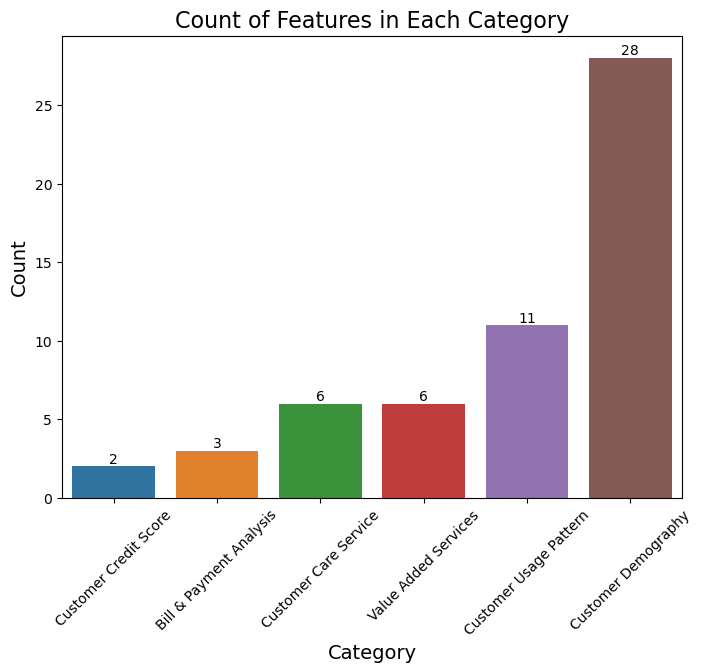

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_data = data_dictionary[
    ~data_dictionary["Category"].isin(["Customer ID", "Response Variable"])
]
_ = sns.countplot(
    x="Category",
    data=plot_data,
    order=plot_data["Category"].value_counts(ascending=True).index,
)
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ".0f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )
ax.set_title("Count of Features in Each Category", fontsize=16)
ax.set_ylabel("Count", fontsize=14)
ax.set_xlabel("Category", fontsize=14)
plt.xticks(rotation=45)

if output_img:
    fig.savefig("./img/m3_fig0.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

The bar chart provides an overview of the distribution of features across different categories within the dataset. Among the six categories analysed, Customer Demography is the most represented, with 28 features, highlighting its significance in understanding customer behaviour. 

Customer Usage Pattern follows with 11 features, reflecting its importance in capturing customer activity and engagement. Categories such as Customer Care Service and Value Added Services are equally represented with 6 features each, while Bill & Payment Analysis and Customer Credit Score are less prevalent, comprising 3 and 2 features respectively.

### Data Summary
The dataset comprises various types of variables, reflecting its diverse data structure. Specifically, it contains 7 discrete variables, 19 continuous variables, 41 binary variables, and 1 identifier variable. Notably, there are no categorical variables, as these have been converted into binary indicators through one-hot encoding. This preprocessing step ensures compatibility with machine learning algorithms that require numerical inputs. The predominance of binary variables highlights the importance of categorical data that has been encoded into a numerical format, while the inclusion of continuous and discrete variables allows for more detailed quantitative analysis. 

In [11]:
discrete_vars, categorical_vars, continuous_vars, binary_vars, id_vars = (
    get_variable_category(X_train)
)

In [12]:
print(f"Number of Discrete Variables: {len(discrete_vars)}")
print(f"Number of Categorical Variables: {len(categorical_vars)}")
print(f"Number of Continuous Variables: {len(continuous_vars)}")
print(f"Number of Binary Variables: {len(binary_vars)}")
print(f"Number of ID Variables: {len(id_vars)}")

Number of Discrete Variables: 8
Number of Categorical Variables: 0
Number of Continuous Variables: 18
Number of Binary Variables: 41
Number of ID Variables: 0


There are no categorical variables because they have all been one-hot encoded.

In [13]:
# Sanity Check
assert len(binary_vars) + len(categorical_vars) + len(discrete_vars) + len(
    id_vars
) + len(continuous_vars) == len(X_train.columns)

#### Discrete Variables
The visualisations depict the distributions of discrete variables, stratified by churn status, to better understand the differences between churners and non-churners. The y-axis represents the proportion of individuals within each category, providing a clearer comparison between the two groups.

In the case of handset_models, most individuals are concentrated in the lower categories, with minimal differences between churners and non-churners. Variables such as retention_calls and retention_offers_accepted exhibit significant skewness, with the majority of individuals having no values, highlighting the rarity of these interactions. 

Similarly, referrals_made_by_subscriber shows limited activity across both groups. For income_group and credit_rating, the distributions appear more varied, suggesting these variables may provide valuable insights into churn behaviour. 

In sum, while some variables show minimal variation between churn groups, others such as income_group demonstrate potential relevance for further analysis.

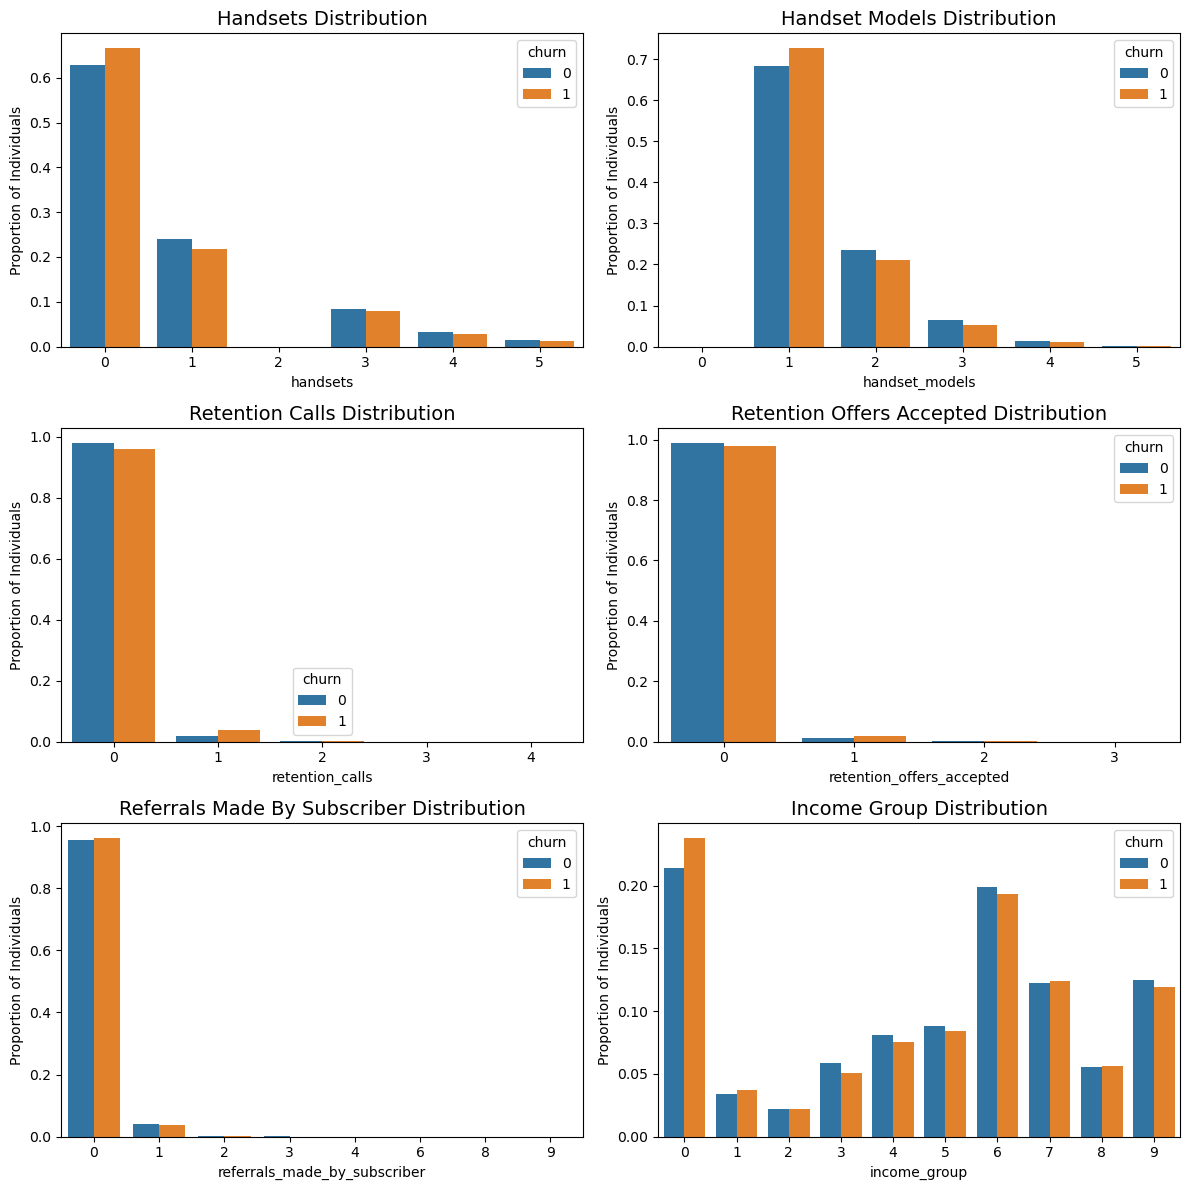

In [14]:
train = pd.concat([X_train, y_train], axis=1)

fig, ax = plt.subplots(3, 2, figsize=(12, 12))

for ax, column in zip(ax.ravel(), discrete_vars[1:]):  # Drop ID
    counts = (
        train[[column, "churn"]]
        .groupby("churn")
        .value_counts(normalize=True)
        .reset_index()
    )
    counts = counts.sort_values(column)

    sns.barplot(x=column, y="proportion", data=counts, ax=ax, hue="churn")
    ax.set_title(f"{split_snake_case(column)} Distribution", fontsize=14)
    ax.set_ylabel("Proportion of Individuals")
    ax.set_xlabel(column)
    if counts[column].dtype in ['float64', 'float32']:
        ax.set_xticklabels(ax.get_xticks(), rotation=0, fontsize=10)
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels([f"{int(tick)}" for tick in ax.get_xticks()])

plt.tight_layout()

In [15]:
if output_img:
    fig.savefig('./img/m3_fig1.png', format='png', dpi=300, bbox_inches='tight')

#### Continuous Variables
##### Continuous Variable Distributions (First 16)
The first grid of histograms visualises the distributions of the first 16 continuous variables in the dataset, separated by churn status (indicated by colour). 
Many features, such as perc_change_minutes and perc_change_revenues, exhibit symmetrical distributions centred around zero, with noticeable variations between churners and non-churners, suggesting these variables may hold predictive value. Other features, including months_in_service and current_equipment_days, display heavily right skewed distributions. 

Additionally, features like age_hh1 and age_hh2 show distinct peaks, indicating clustering around specific demographic values. Variables such as received_calls and overall_usage demonstrate significant overlap between churn groups, suggesting weaker discrimination potential. 

The histograms provide valuable insights into the data structure and suggest which variables may require transformation or further exploration to enhance predictive modelling.

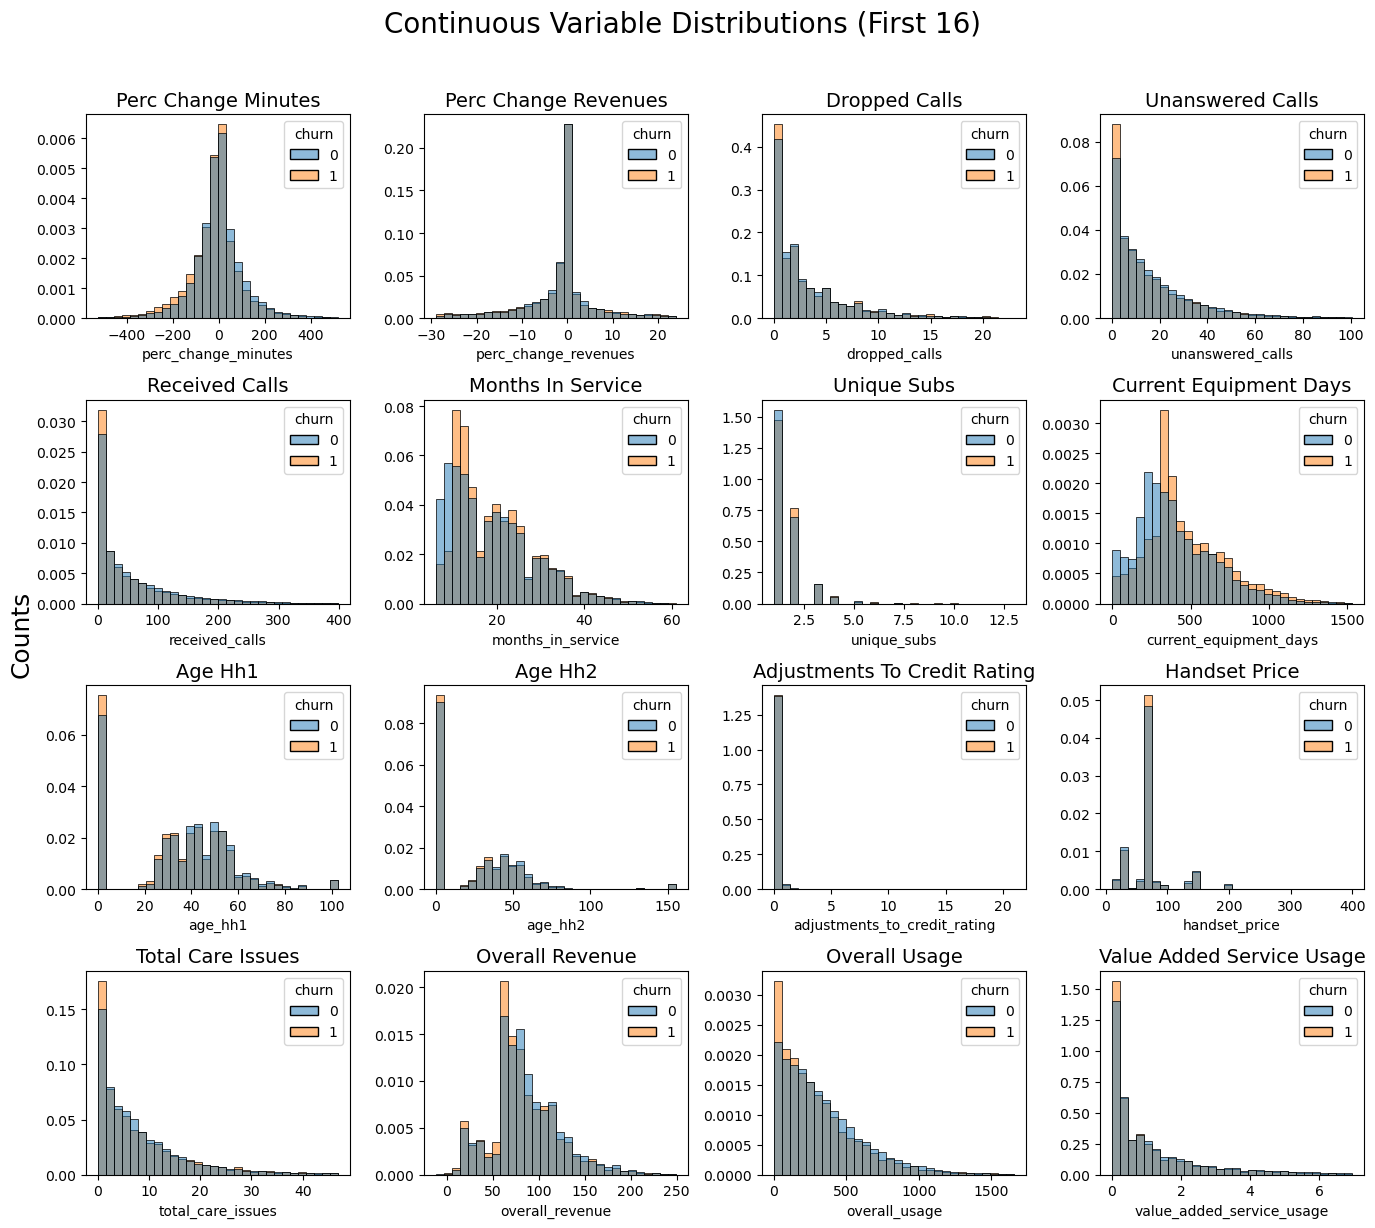

In [16]:
fig, ax = plt.subplots(4, 4, figsize=(14, 12))

for ax, column in zip(ax.ravel(), continuous_vars[:16]):
    sns.histplot(
        x=column,
        data=train[[column, "churn"]],
        bins=30,
        ax=ax,
        hue="churn",
        stat="density",
        common_norm=False,
    )
    ax.set_title(f"{split_snake_case(column)}", fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel(column)
fig.supylabel("Counts", fontsize=18)
fig.suptitle("Continuous Variable Distributions (First 16)", fontsize=20, y=1.02)
plt.tight_layout()

In [17]:
if output_img:
    fig.savefig('./img/m3_fig3a.png', format='png', dpi=300, bbox_inches='tight')

##### Continuous Variable Distributions (Last 2)
The histograms present the distributions of the last two continuous variables: value_added_service_usage and total_calls, separated by churn status. Both variables exhibit heavily skewed distributions, with the majority of observations clustered near lower values. For value_added_service_usage, a significant proportion of both churners (churn = 1) and non-churners (churn = 0) show no usage.

Similarly, the distribution for total_calls is right-skewed, with churners predominantly making fewer calls compared to non-churners. 

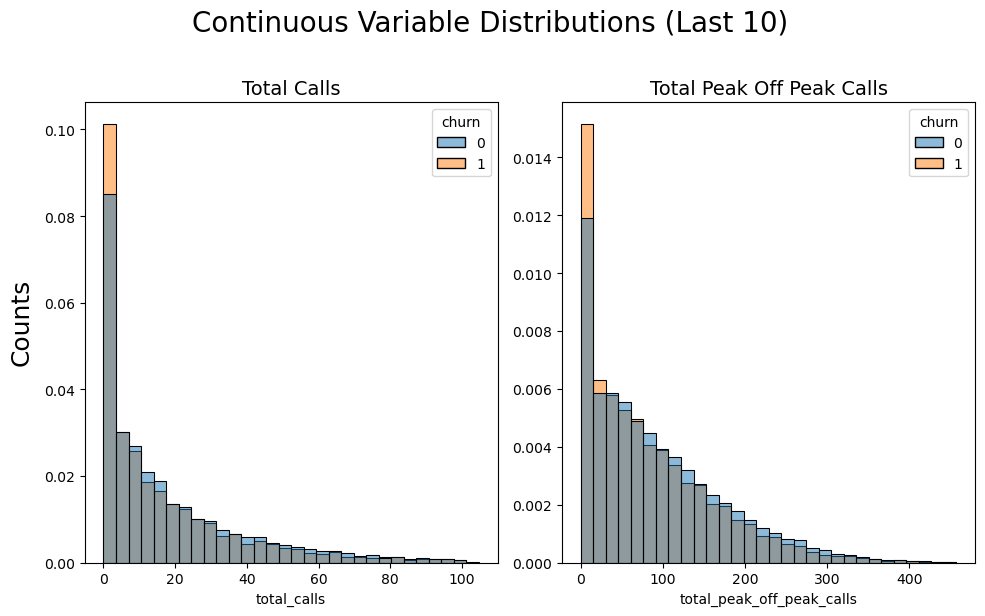

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

axes = ax.ravel()
for ax, column in zip(axes, continuous_vars[16:]):
    sns.histplot(
        x=column, 
        data=train[[column, "churn"]], 
        bins=30, 
        ax=ax, 
        hue="churn", 
        stat="density", 
        common_norm=False
    )
    ax.set_title(f'{split_snake_case(column)}', fontsize=14)
    ax.set_ylabel('')
    ax.set_xlabel(column)
fig.supylabel('Counts', fontsize=18)
fig.suptitle('Continuous Variable Distributions (Last 10)', fontsize=20, y=1.02)

plt.tight_layout()

In [19]:
if output_img:
    fig.savefig('./img/m3_fig3b.png', format='png', dpi=300, bbox_inches='tight')

##### Box Plots


The box plots illustrate the differences between churners (churn = 1) and non-churners (churn = 0) across the first 16 continuous variables. Age-related features, such as Age Hh1 and Age Hh2, reveal that churners tend to have slightly higher median ages compared to non-churners. For Age Hh1, churners exhibit less variability in age.
For Age Hh2, churners and non-churners show a similar distribution, having a median age of approximately 35 years.


Variables such as Unique Subs, Active Subs, and Adjustments to Credit Rating exhibit heavily skewed distributions, with most values concentrated near zero for both churners and non-churners.


All three variables contain extreme outliers, particularly among non-churners.
Additionally, features such as Perc Change Minutes, Perc Change Revenues, Dropped Calls, Unanswered Calls, Received Calls, Months in Service, Current Equipment Days, Total Care Issues, and Overall exhibit comparable distributions with overlapping interquartile ranges and outliers for both groups. This suggests that while these features may offer insights into churn, they are not highly distinctive on their own.


Finally, the box plot for Overall Revenue indicates that non-churners have lower revenue outliers compared to churners.


Despite this difference, the distributions of the two groups are broadly similar, with overlapping interquartile ranges at the higher end. This suggests that Overall Revenue may have some association with churn, but it is unlikely to serve as a strong standalone predictor.

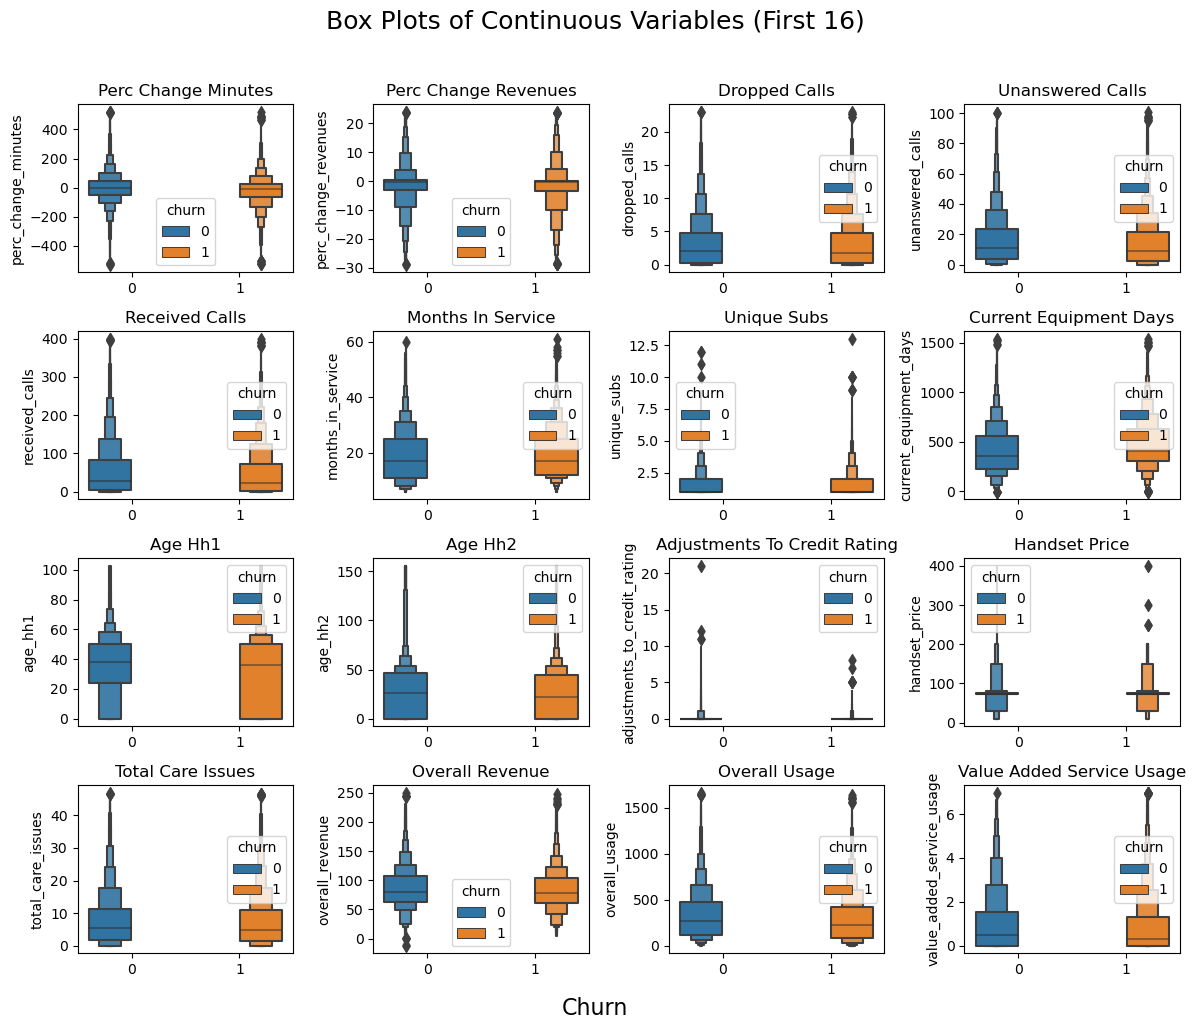

In [20]:
fig, ax = plt.subplots(4, 4, figsize=(12, 10))  

for ax, feature in zip(ax.ravel(), continuous_vars[:16]):

    _=sns.boxenplot(
        x="churn", 
        y=feature, 
        data=train,
        hue='churn', 
        ax=ax
    )
    ax.set_title(split_snake_case(feature).title())
    ax.set_xlabel("")

plt.suptitle("Box Plots of Continuous Variables (First 16)", fontsize = 18, y=1.02)
fig.supxlabel("Churn", fontsize=16)
plt.tight_layout()

In [21]:
if output_img:
    fig.savefig('./img/m3_fig3c.png', format='png', dpi=300, bbox_inches='tight')

#### Binary Variables

In [22]:
# Remove zero-inflated dummies
binary_vars_to_plot = [var for var in binary_vars if var.split("_")[-1] != 'zero']
binary_vars_to_plot

['children_in_hh',
 'handset_refurbished',
 'handset_web_capable',
 'truck_owner',
 'rv_owner',
 'homeownership',
 'buys_via_mail_order',
 'responds_to_mail_offers',
 'opt_out_mailings',
 'non_us_travel',
 'owns_computer',
 'has_credit_card',
 'new_cellphone_user',
 'owns_motorcycle',
 'made_call_to_retention_team',
 'prizm_code_Rural',
 'prizm_code_Suburban',
 'prizm_code_Town',
 'occupation_Crafts',
 'occupation_Homemaker',
 'occupation_Other',
 'occupation_Professional',
 'occupation_Retired',
 'occupation_Self',
 'occupation_Student',
 'marital_status_Unknown',
 'marital_status_Yes']

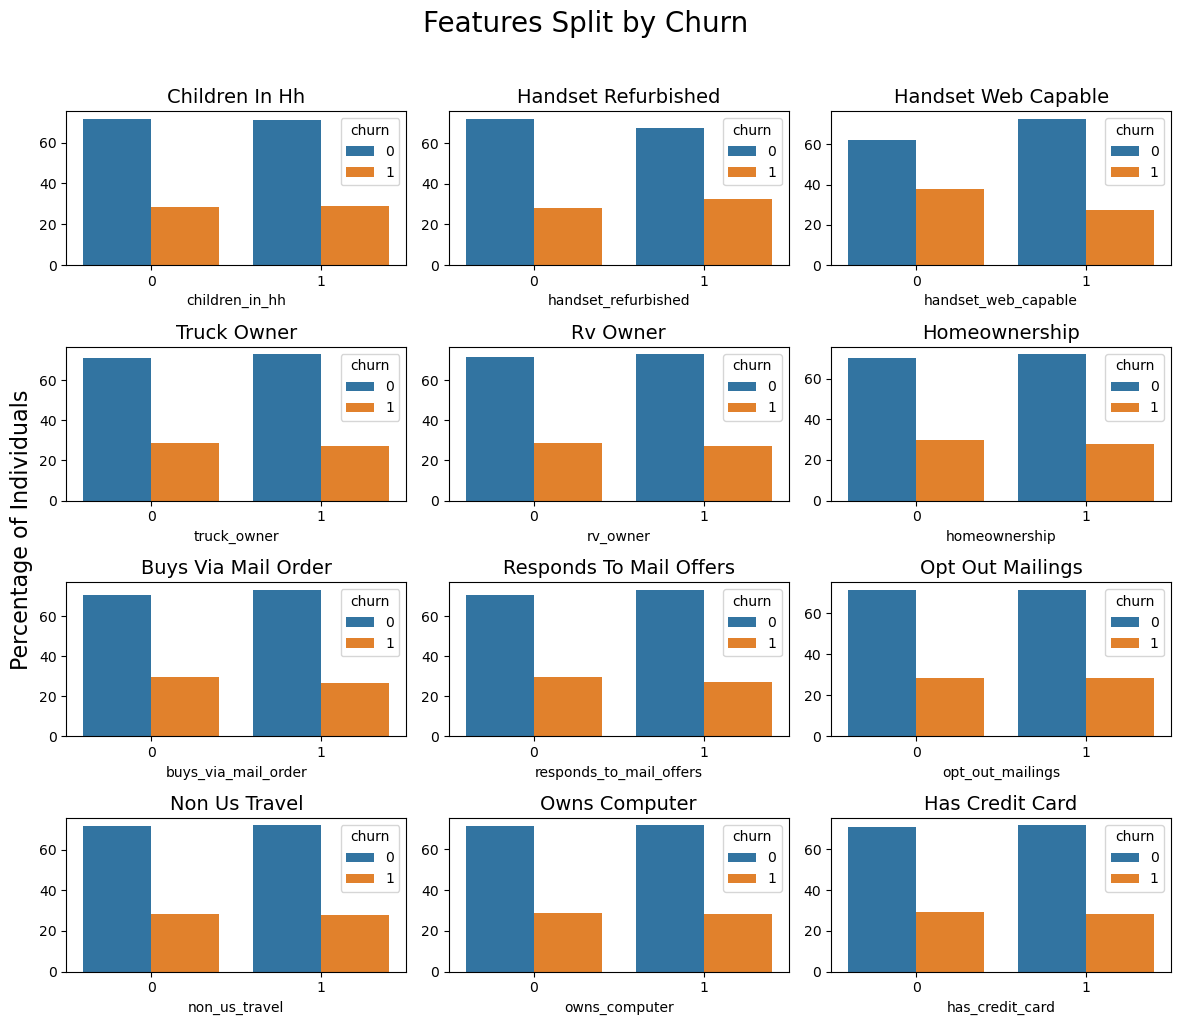

In [23]:
fig, ax = plt.subplots(4, 3, figsize=(12, 10))  

for ax, feature in zip(ax.ravel(),binary_vars_to_plot[:12]): # Drop Response Variable - Churn
    plot_data = train[[feature, "churn"]]
    grouped_data = plot_data.groupby([feature, "churn"]).size().reset_index(name="count")
    grouped_data["percentage"] = grouped_data.groupby(feature)["count"].transform(lambda x: x / x.sum() * 100)
    
    _ = sns.barplot(
        x=feature, 
        y="percentage",
        hue="churn",
        data=grouped_data,
        ax=ax
    )
    ax.set_title(f"{split_snake_case(feature)}", fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel(f"{feature}")

fig.supylabel("Percentage of Individuals", fontsize=16)
plt.suptitle("Features Split by Churn", fontsize=20, y=1.02)
plt.tight_layout()

In [24]:
if output_img:
    fig.savefig('./img/m3_fig4.png', format='png', dpi=300, bbox_inches='tight')

The bar plots display the distributions of selected binary variables, split by churn status (churn = 0 for non-churners and churn = 1 for churners).

For most features, the proportion of non-churners consistently exceeds that of churners across both binary outcomes, indicating a general trend of lower churn rates. For example, features like Children In Hh, Handset Refurbished, and Handset Web Capable have similar patterns, where having or not having these attributes does not clearly separate churners from non-churners.Other variables, such as Homeownership, Non Us Travel, and Has Credit Card, also exhibit comparable distributions, suggesting limited predictive power for distinguishing between churn groups. 
 
Overall, these plots indicate that while binary variables provide some insights into churn behaviour, the overlap between groups suggests they may need to be used in combination with other features to enhance predictive modelling.

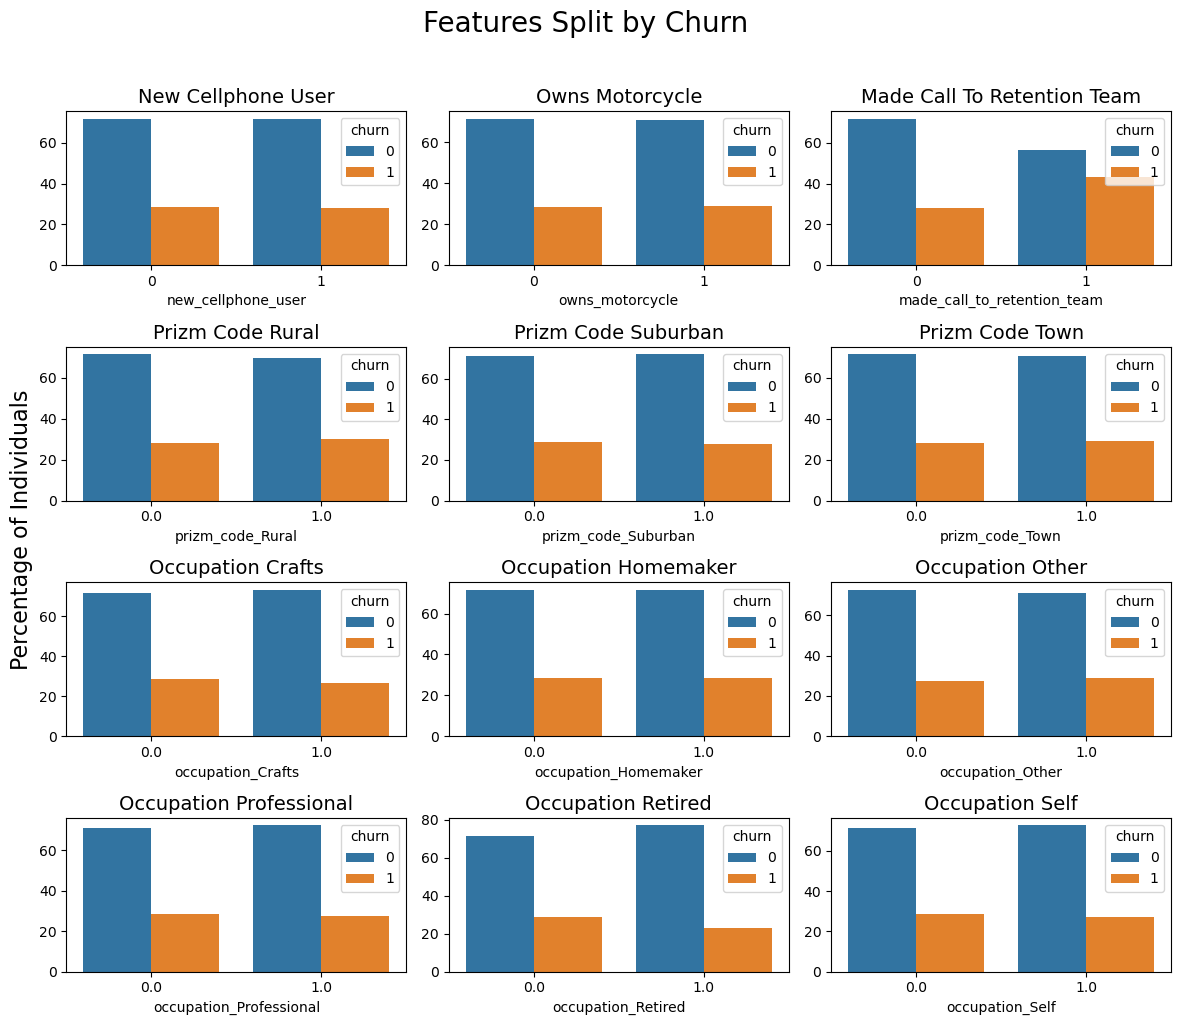

In [25]:
fig, ax = plt.subplots(4, 3, figsize=(12, 10))  

for ax, feature in zip(ax.ravel(),binary_vars_to_plot[12:]): # Drop Response Variable - Churn
    plot_data = train[[feature, "churn"]]
    grouped_data = plot_data.groupby([feature, "churn"]).size().reset_index(name="count")
    grouped_data["percentage"] = grouped_data.groupby(feature)["count"].transform(lambda x: x / x.sum() * 100)
    
    _ = sns.barplot(
        x=feature, 
        y="percentage",
        hue="churn",
        data=grouped_data,
        ax=ax
    )
    ax.set_title(f"{split_snake_case(feature)}", fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel(f"{feature}")

fig.supylabel("Percentage of Individuals", fontsize=16)
plt.suptitle("Features Split by Churn", fontsize=20, y=1.02)
plt.tight_layout()

Most binary variables, such as New Cellphone User, Owns Motorcycle, and various Prizm Code categories, display similar patterns between churners (churn = 1) and non-churners (churn = 0). The proportions in both groups are comparable, with no clear distinction that separates churners from non-churners. These variables appear to have limited predictive power when considered individually.

However, certain features stand out. The variable Made Call To Retention Team shows a noticeable difference, with churners being more likely to have interacted with the retention team. This suggests that customers who contact retention services may already be considering cancellation.

Occupation Retired shows a lower proportion of churners compared to non-churners in the retired category, indicating that retired individuals may have unique behavioural patterns influencing churn. These two variables may hold stronger predictive value.

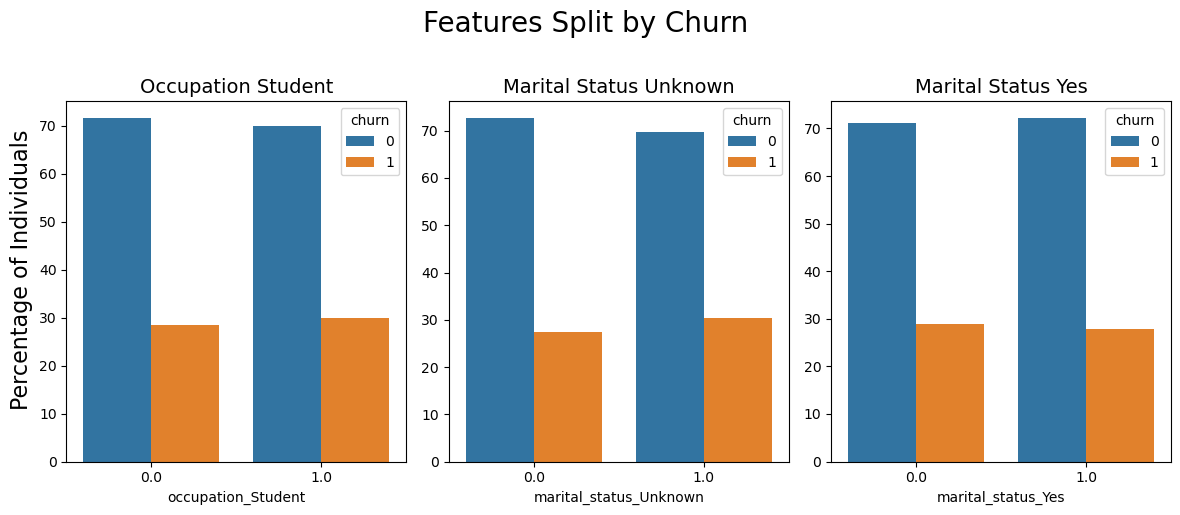

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))  

for ax, feature in zip(ax.ravel(),binary_vars_to_plot[24:]): # Drop Response Variable - Churn
    plot_data = train[[feature, "churn"]]
    grouped_data = plot_data.groupby([feature, "churn"]).size().reset_index(name="count")
    grouped_data["percentage"] = grouped_data.groupby(feature)["count"].transform(lambda x: x / x.sum() * 100)
    
    _ = sns.barplot(
        x=feature, 
        y="percentage",
        hue="churn",
        data=grouped_data,
        ax=ax
    )
    ax.set_title(f"{split_snake_case(feature)}", fontsize=14)
    ax.set_ylabel("")
    ax.set_xlabel(f"{feature}")

fig.supylabel("Percentage of Individuals", fontsize=16)
plt.suptitle("Features Split by Churn", fontsize=20, y=1.02)
plt.tight_layout()

Most of the binary variables in this set, such as Occupation Student, Marital Status Unknown, and Marital Status Yes, show similar distributions between churners (churn = 1) and non-churners (churn = 0). In all three cases, the proportion of non-churners is consistently higher than that of churners across both categories (0 and 1). This indicates that these features may not strongly differentiate between the two groups.

## Exploratory Data Analysis

### Deeper Understanding of the Data

*While basic EDA is important, you should aim to provide a deeper understanding of the data through your analysis. This can be achieved by identifying patterns, trends, class imbalances, and outliers in the data. Additionally, explore the relationships between variables and identify any potential confounding variables that may impact the analysis.*

1. Trends: We explored the trend using the only temporal feature "MonthsInService"
   - Initial drop: The churn rate begins at approximately 0.2 and declines slightly.
   - Sharp increase: A sharp increase in churn rate is observed around the 10-month mark. This might indicate that users are bound by a contractual agreement lasting 10 months.
   - Stablisation: Following the spike at the 10th month, the churn rate slightly declines and stabilises, fluctuating between 0.2 and 0.4 over the subsequent months.
   - Large fluctuation >50 months: Towards the end of the timeline, the data exhibits significant fluctuations, with a spike at the final point suggesting a potential outlier.
3. Class imbalance: Class imbalance was previously identified and addressed in Milestone 2 (MS2).
4. Outliers:
   - We can identify from the box plot and distribution plots that there are outliers in the dataset. Instead of removing the outliers right now, we'll use different methods such as (1) Cook's distance (if using linear regression) and (2) principal component analysis (PCA) to handle outliers. 
5. Relationship between variables:
   Strong correlations were identified between certain features, potentially leading to multicollinearity. This was evident in both the heatmap and pair plots. To address this issue, we will explore:
   - Removing one of the correlated features
   - PCA
   - Feature selection methods, to determine the optimal approach for mitigating multicollinearity.

   Examples of correlated features include:
      - unique_subs & unique_subs: 0.786
      - age_hh1 & age_hh2: 0.693
      - dropped_calls & unanswered_calls: 0.52


   However, no single feature was found to have a strong direct correlation with churn. This is intriguing, as we anticipated at least a weak correlation between some features and churn. This suggests that churn may depend on more complex interactions between multiple variables.



#### Trends

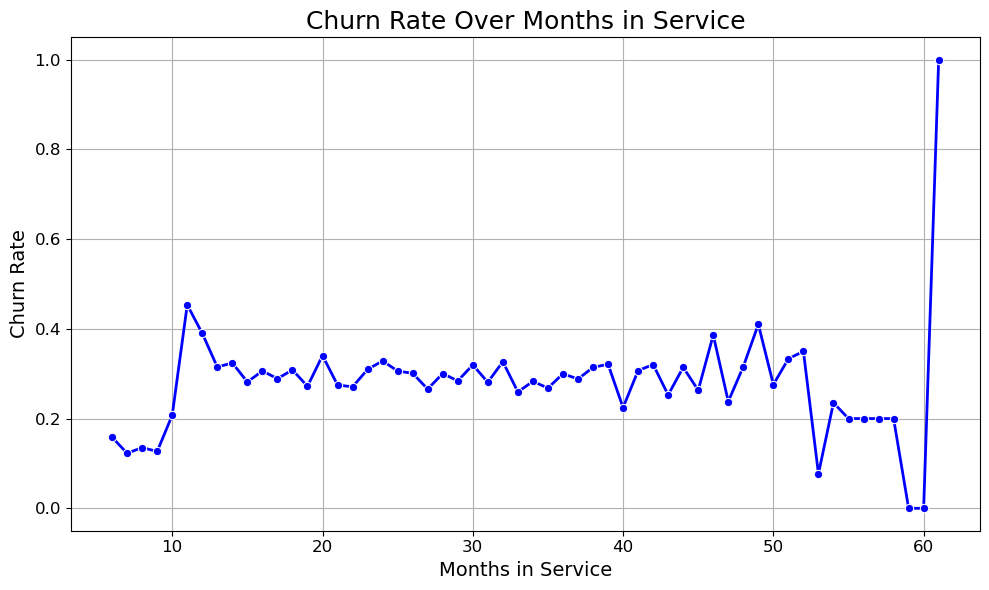

In [27]:
# Identifying the trend using time trended variable: "MonthsInSerivce"

monthly_churn_rate = train.groupby('months_in_service')['churn'].mean().reset_index()
plt.figure(figsize=(10, 6))

sns.lineplot(
    x='months_in_service', 
    y='churn', 
    data=monthly_churn_rate, 
    marker='o', 
    color='b', 
    linestyle='-', 
    linewidth=2, 
    markersize=6
)

plt.title('Churn Rate Over Months in Service', fontsize = 18)  
plt.xlabel('Months in Service', fontsize = 14)  
plt.ylabel('Churn Rate', fontsize=14) 


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.tight_layout()

if output_img:
    plt.savefig('./img/m3_fig5.png', format='png', dpi=300, bbox_inches='tight')



The plot shows the churn rate over "Months in Service," highlighting key trends in customer retention. The churn rate starts around 0.2, peaks sharply at the 10th month (likely due to contract expirations), and then stabilises between 0.2 and 0.4 for most of the timeline. After 50 months, fluctuations increase, with a notable spike at the 60th month, possibly due to outliers. These patterns suggest critical points for targeted interventions to reduce churn.

#### Correlation Matrices

In [28]:
batches = list(zip(list(range(0, len(continuous_vars)+1, 6)), list(range(0, len(continuous_vars)+1, 6))[1:]))

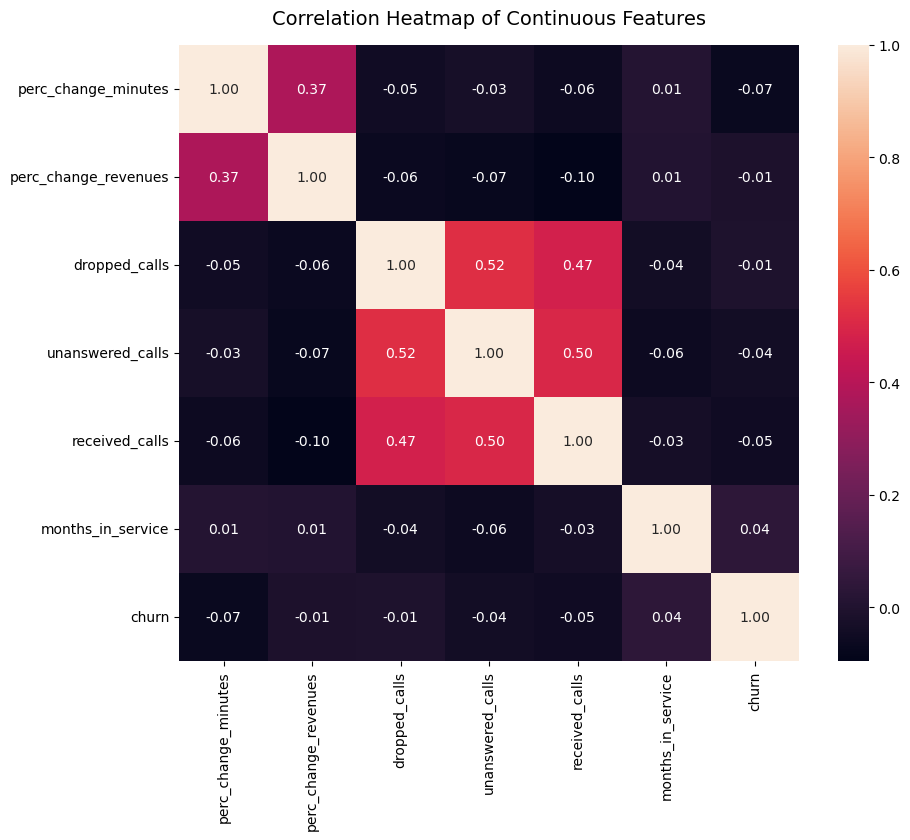

Strong correlations:
                       perc_change_minutes  perc_change_revenues  \
perc_change_minutes                   1.0                   NaN   
perc_change_revenues                  NaN                   1.0   
dropped_calls                         NaN                   NaN   
unanswered_calls                      NaN                   NaN   
received_calls                        NaN                   NaN   
months_in_service                     NaN                   NaN   
churn                                 NaN                   NaN   

                      dropped_calls  unanswered_calls  received_calls  \
perc_change_minutes             NaN               NaN             NaN   
perc_change_revenues            NaN               NaN             NaN   
dropped_calls                   1.0               NaN             NaN   
unanswered_calls                NaN               1.0             NaN   
received_calls                  NaN               NaN             1.0   
mon

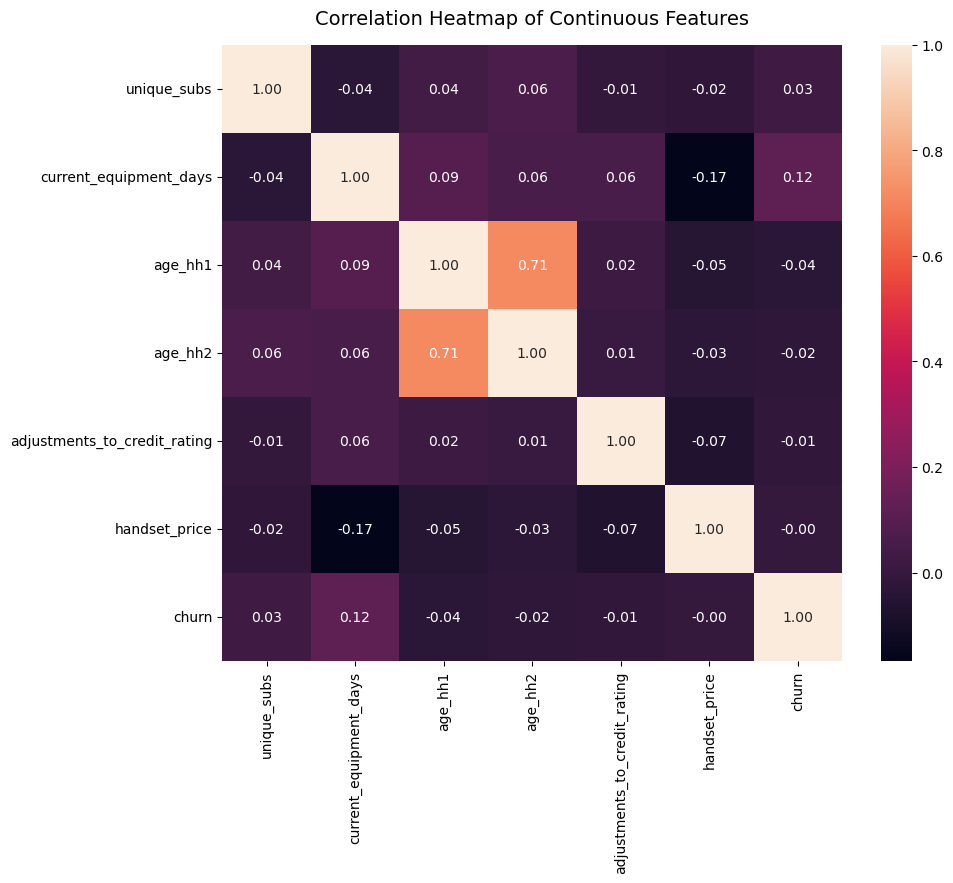

Strong correlations:
                               unique_subs  current_equipment_days   age_hh1  \
unique_subs                           1.0                     NaN       NaN   
current_equipment_days                NaN                     1.0       NaN   
age_hh1                               NaN                     NaN  1.000000   
age_hh2                               NaN                     NaN  0.714777   
adjustments_to_credit_rating          NaN                     NaN       NaN   
handset_price                         NaN                     NaN       NaN   
churn                                 NaN                     NaN       NaN   

                               age_hh2  adjustments_to_credit_rating  \
unique_subs                        NaN                           NaN   
current_equipment_days             NaN                           NaN   
age_hh1                       0.714777                           NaN   
age_hh2                       1.000000                   

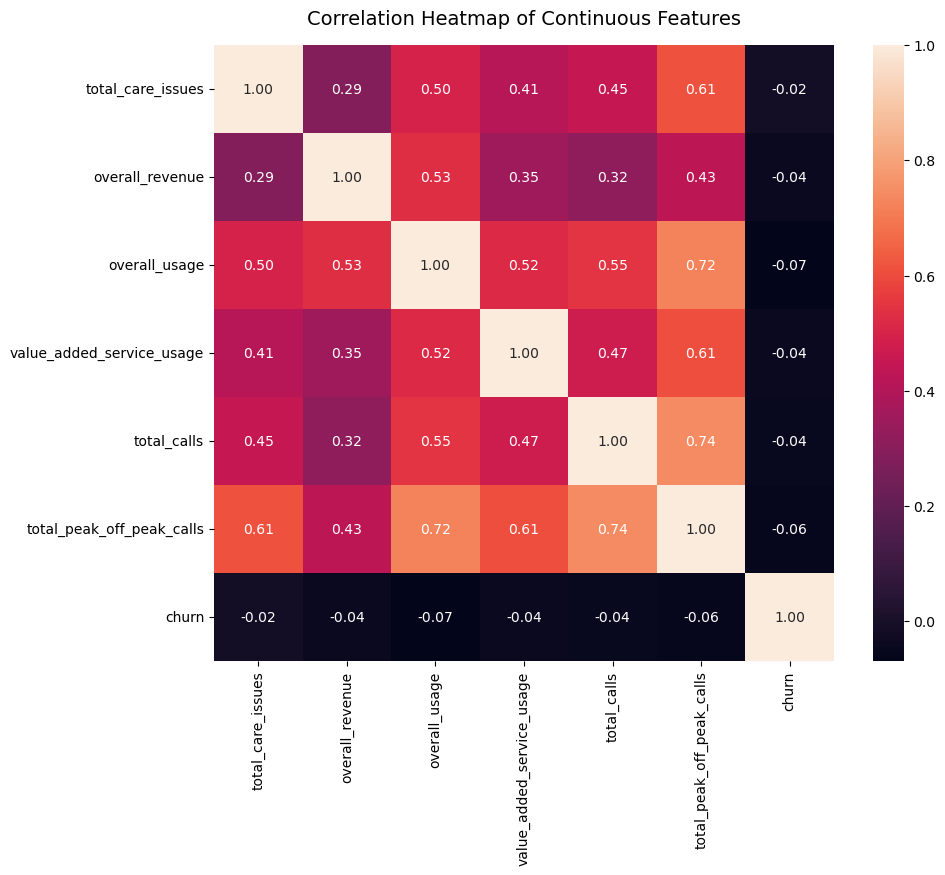

Strong correlations:
                            total_care_issues  overall_revenue  overall_usage  \
total_care_issues                   1.000000              NaN            NaN   
overall_revenue                          NaN              1.0            NaN   
overall_usage                            NaN              NaN       1.000000   
value_added_service_usage                NaN              NaN            NaN   
total_calls                              NaN              NaN            NaN   
total_peak_off_peak_calls           0.614673              NaN       0.723019   
churn                                    NaN              NaN            NaN   

                           value_added_service_usage  total_calls  \
total_care_issues                                NaN          NaN   
overall_revenue                                  NaN          NaN   
overall_usage                                    NaN          NaN   
value_added_service_usage                   1.000000         

In [29]:
# Correlation heatmap for continuous variables

for letter, batch in zip(string.ascii_lowercase, batches):
    correlation_matrix = pd.concat([train[continuous_vars[batch[0]:batch[1]]], train['churn']], axis=1).corr(method='pearson')
    fig, ax = plt.subplots(figsize=(10, 8))  
    sns.heatmap(
        correlation_matrix, 
        annot=True,
        fmt=".2f",
        ax=ax
    )
    ax.set_title('Correlation Heatmap of Continuous Features', fontsize=14, y=1.02)
    plt.show();

    # Identify strong correlations (greater than 0.6 or less than -0.6)
    strong_corr = correlation_matrix[(correlation_matrix > 0.6) | (correlation_matrix < -0.6)]
    print("Strong correlations:\n", strong_corr)

    if output_img:
        fig.savefig(f'./img/m3_fig6{letter}.png', format='png', dpi=300, bbox_inches='tight')

The first heatmap visualises the correlations among continuous features in the dataset, offering insights into their relationships. Strong correlations are evident between several variables. For example, a high correlation exists between dropped_calls and unanswered_calls (0.52) as well as between unanswered_calls and received_calls (0.51), indicating potential multicollinearity among these features. This suggests that these variables may be capturing similar underlying behaviours in customer interactions. Interestingly, features such as perc_change_minutes, perc_change_revenues, and months_in_service exhibit relatively low correlations with churn, suggesting that customer churn is influenced by more complex interactions rather than strong linear relationships with individual features. This analysis highlights the need for further exploration using advanced feature selection or dimensionality reduction techniques to mitigate multicollinearity and identify the most impactful predictors of churn.

The second correlation heatmap highlights relationships among selected continuous features. A strong positive correlation is observed between unique_subs and active_subs (0.79), indicating that these variables capture similar aspects of subscriber activity. Additionally, age_hh1 and age_hh2 are moderately correlated (0.69), reflecting potential similarities in household age demographics. Interestingly, no significant correlations are found between churn and any other feature, with the highest being a weak positive correlation of 0.12 with current_equipment_days. This suggests that churn may not be strongly influenced by individual continuous variables in this dataset, pointing towards the need for more complex interaction terms or categorical features to explain churn behaviour effectively.

The third correlation heatmap reveals significant relationships among various continuous features. Notably, overall_usage shows a moderate positive correlation with total_calls (0.55), value_added_service_usage (0.51), and overall_revenue (0.53), indicating that higher usage is associated with increased service utilisation and revenue generation. Similarly, total_care_issues correlates positively with value_added_service_usage (0.41) and total_calls (0.45), suggesting that customers with higher service interactions may also experience more technical issues. 

However, no strong correlations are observed between churn and any of the continuous features, with the highest being a weak negative correlation of -0.07 with overall_usage. 

In [30]:
# Calculate correlations with response
correlations = train[continuous_vars].corrwith(train["churn"])

# Sort correlations in descending order (absolute values for strength)
sorted_correlations = correlations.abs().sort_values(ascending=False)
top5_features = list(sorted_correlations.head(5).index) + ["churn"]
top5_features

['current_equipment_days',
 'perc_change_minutes',
 'overall_usage',
 'total_peak_off_peak_calls',
 'received_calls',
 'churn']

### Pairplot of selected features
The pairplot visualises the relationships among the top five continuous features most correlated with the target variable (churn). These features include current_equipment_days, overall_usage, perc_change_minutes, total_peak_off_peak_calls, and received_calls. The scatter plots reveal potential patterns and distributions across these features, separated by the churn status (presented by colour).

Key observations include a noticeable clustering of churners (churn = 1) in areas where current_equipment_days and overall_usage are lower, suggesting that customers with shorter equipment usage durations or lower service usage might be more likely to churn. Similarly, while total_peak_off_peak_calls and received_calls show widespread distributions, no distinct separations are evident between churn and non-churn groups. This indicates that churn behaviour might depend on complex, non-linear relationships or interactions between features rather than direct correlations with individual variables.

c:\Users\Kai_R\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Kai_R\AppData\Local\Temp\ipykernel_21112\307333484.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


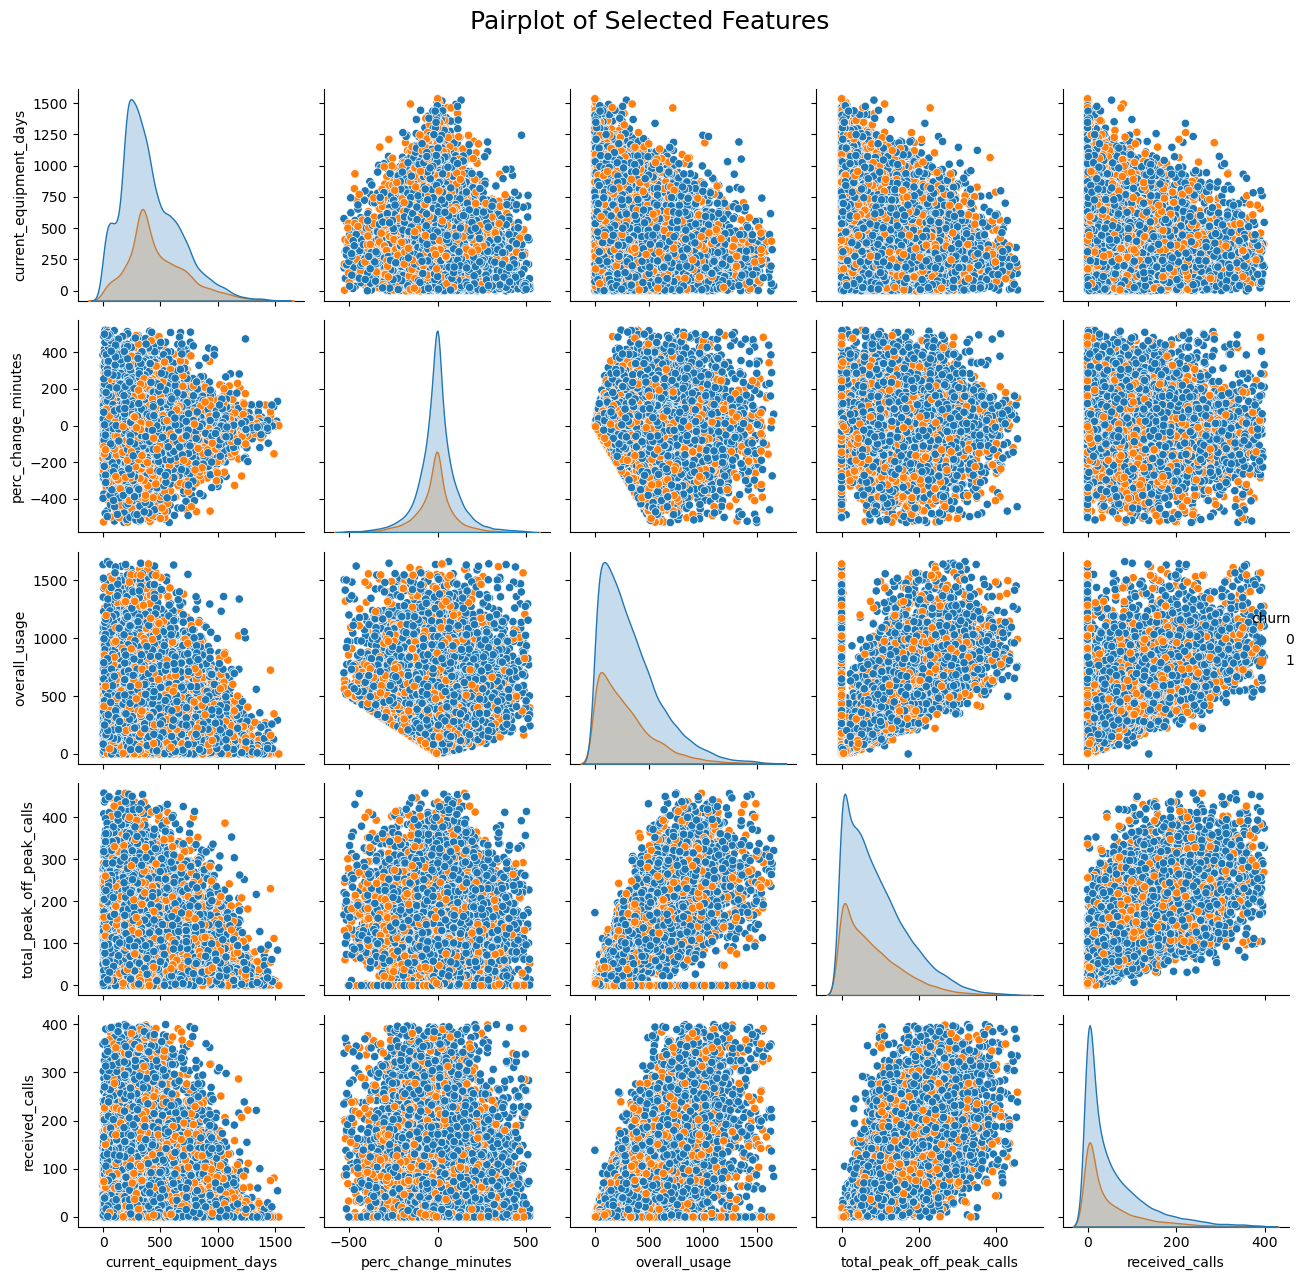

In [31]:
# Pairplot of selected features
pairplot = sns.pairplot(
    train[top5_features], 
    hue='churn'
)
plt.suptitle('Pairplot of Selected Features', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

In [32]:
if output_img:
    pairplot.savefig(f'./img/m3_fig7.png', format='png', dpi=300, bbox_inches='tight')

### Noteworthy Findings

#### Service Quality Impact
- Based on the correlation heatmap and pair plot, there is no strong direct correlation between `DroppedCalls` and `Churn`. This suggests that while service quality may impact `churn`, `DroppedCalls` alone does not demonstrate a significant linear relationship with churn.

#### Financial Patterns
- **Revenue & Charges**: The correlation heatmap highlights a strong relationship between `MonthlyRevenue` and `OverageMinutes` (0.79), as well as `MonthlyRevenue` and `MonthlyMinutes` (0.71). 
- **Churn Correlation**: Financial variables such as ``MonthlyRevenue` and `TotalRecurringCharge` show very weak or negligible correlations with `churn`, suggesting that `churn` is likely driven by more complex interactions between these variables rather than by any single factor.

#### Demographic Insights
- **Credit Rating**:The distribution of credit ratings reveals a higher density of churn among customers with a medium (2-High) credit rating.
- **Income Group**: Income Group 6 has the highest representation, while Income Group 0 displays a more varied churn rate.

#### Continuous Variables Analysis
- **Monthly Revenue**: The distribution is heavily right-skewed, with most customers having a low monthly revenue.
- **Monthly Minutes**: Similarly, this variable is right-skewed, showing that most customers have low usage, but a small number consume a significantly higher number of minutes.
- **Total Recurring Charge**: This right-skewed distribution suggests that the majority of customers incur low recurring charges.

#### Churn Trends Over Time
- **10-Month Spike**:  The churn rate chart exhibits a significant spike around the 10-month mark, possibly reflecting a contract term or milestone prompting churn.
- **Long-Term Fluctuations**: After stabilising around 20-40% for most of the service period, the churn rate begins fluctuating after 50 months, with a sharp peak at the end.

#### Correlation Insights
- **Feature Correlations**: The heatmap shows strong correlations between features like `MonthlyRevenue` & `OverageMinutes` (0.79) and `MonthlyMinutes` & `ReceivedCalls` (0.83),  indicating potential multicollinearity, which may require attention during modelling.
- **No Strong Correlation with Churn**: None of the variables exhibit a strong correlation with churn, underscoring the likelihood that churn is influenced by complex interactions rather than by individual features.


## Research Question

Now that we've established a exhaustive EDA, we now present the research questions that will guide our empirical analysis. 

1. **Which variables influence churn, and which model can most effectively predict customer churn?**

2. **What is the causal estimate for the features "call to retention center" and "responds to mail offers"?**



## Baseline Models

This section focuses on the development and evaluation of two baseline models 1) A naive model that predicts random labels based on the class distribution and 2) a bare bones logistic regression model. These two models serve as the baseline metric to beat going forward. A variety of metrics were employed to comprehensively assess the differences in their predictive performance, such as f1-score and accuracy.

### Naive Model

To establish a baseline for comparison, a naive model was developed using the DummyClassifier with the stratified strategy. This approach randomly predicts labels based on the class distribution observed in the training data. The rationale for selecting this strategy is that it provides a realistic yet minimal benchmark, reflecting the predictive power of a model with no meaningful features or training. This baseline ensures that future models are assessed against a metric more robust than a simple majority class prediction.

On the training dataset, the naive model achieved an accuracy of 59%, consistent with the class distribution (72% for churn = 0 and 28% for churn = 1). The macro-average F1-score was 0.50, reflecting balanced performance across classes. For churn = 0, the precision, recall, and F1-score were 0.72, indicating effective identification of non-churners but limited ability to distinguish them from churners. For churn = 1, all metrics were much lower at 0.28, highlighting the model's poor ability to detect churners, with low recall showing many missed predictions and low precision indicating frequent false positives.

In [33]:
naive_model = DummyClassifier(strategy="stratified")
naive_model.fit(X_train, y_train)
y_pred_naive = naive_model.predict(X_train)

print ("Naive Model - Train Data")
print ("="*53)
print (classification_report(y_train, y_pred_naive))

Naive Model - Train Data
              precision    recall  f1-score   support

           0       0.71      0.71      0.71     19425
           1       0.28      0.28      0.28      7726

    accuracy                           0.59     27151
   macro avg       0.50      0.50      0.50     27151
weighted avg       0.59      0.59      0.59     27151



On the test dataset, the model's accuracy dropped slightly to 58%, with a macro-average F1-score remaining at 0.50. For churn = 0, performance metrics were similar to the training set, with a precision, recall, and F1-score of 0.70. For churn = 1, recall improved slightly to 0.30, but precision and F1-score showed little change. These results underscore the naive model’s inability to provide meaningful predictions, particularly for churners, reinforcing the need for more sophisticated approaches to improve predictive performance.

In [34]:
naive_model = DummyClassifier(strategy="stratified")
naive_model.fit(X_test, y_test)
y_pred_naive = naive_model.predict(X_test)


print ("Naive Model - Test Data")
print ("="*53)
print (classification_report(y_test, y_pred_naive))

Naive Model - Test Data
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      4775
           1       0.29      0.29      0.29      2013

    accuracy                           0.58      6788
   macro avg       0.49      0.49      0.49      6788
weighted avg       0.58      0.58      0.58      6788



### Naive - Logistic Regression

The baseline model was designed as a straightforward Logistic Regression model with the following specifications:
- No regularisation (penalty=None).
- Class weights were set to balanced (class_weight="balanced") to address class imbalance.
- The model was trained on a subset of features (top5_features), selected based on their correlation to churn found in the EDA section.

In [35]:
if "churn" in top5_features:
    top5_features.remove("churn")

In [36]:
logit_model = LogisticRegression(
    penalty=None, random_state=random_state, class_weight="balanced"
)
logit_model.fit(X_train[top5_features], y_train.values.ravel())

y_pred_logit = logit_model.predict(X_train[top5_features])

print("Logit Model - Train Data")
print ("="*53)
print(classification_report(y_train, y_pred_logit))

Logit Model - Train Data
              precision    recall  f1-score   support

           0       0.77      0.58      0.66     19425
           1       0.35      0.57      0.43      7726

    accuracy                           0.58     27151
   macro avg       0.56      0.58      0.55     27151
weighted avg       0.65      0.58      0.60     27151



In [37]:
y_pred_logit = logit_model.predict(X_test[top5_features])

print("Logit Model - Test Data")
print ("="*53)
print(classification_report(y_test, y_pred_logit))

Logit Model - Test Data
              precision    recall  f1-score   support

           0       0.75      0.56      0.64      4775
           1       0.35      0.56      0.43      2013

    accuracy                           0.56      6788
   macro avg       0.55      0.56      0.54      6788
weighted avg       0.63      0.56      0.58      6788



The performance of the baseline logistic regression reveals challenges due to class imbalance, with class 0 (14,663 samples) dominating class 1 (5,857 samples). The model achieves a modest overall accuracy of 0.56, performing better on class 0 (precision: 0.75, recall: 0.56) compared to class 1 (precision: 0.35, recall: 0.56). 

The low f1-score of 0.43 for class 1 highlights difficulties in effectively distinguishing the minority class, likely caused by overlapping feature distributions or inadequate class representation.

The macro average metrics (precision: 0.55, recall: 0.56, F1-score: 0.54) indicate moderate performance across both classes, while the weighted averages slightly favour class 0. To improve, techniques like oversampling (e.g., SMOTE), feature engineering, or hyperparameter tuning should be employed. 

## Models

### Logistic Regression
Building on the baseline model, the improved logistic regression model incorporates advanced techniques to address key challenges, including feature selection, class imbalance, and dimensionality reduction:

- L1 Regularisation `penalty="l1"`: L1 regularisation encourages sparsity in the feature set by penalizing the absolute values of coefficients, facilitating automatic feature selection.

- Hyperparameter Optimization: The $C = \frac{1}{\lambda}$ hyperparameter was optimised using cross-validation with LogisticRegressionCV. This parameter controls the strength of regularisation, with lower values increasing the penalty on coefficients.

- Class Imbalance Handling: The training dataset was pre-processed using SMOTE to ensure balanced class distributions, improving model robustness on the minority class.

- Solver Selection: The liblinear solver was used because it handles L1 regularisation efficiently and does not suffer from convergence issues with small datasets.

- Principal Component Analysis (PCA): PCA was applied to reduce the dimensionality of binary variables while retaining 90% of the variance, which helps mitigate multicollinearity and reduce overfitting.


#### Justification for Parameter Choices
1. L1 Regularisation: L1 regularisation was chosen for feature selection because it shrinks coefficients to zero for irrelevant features, simplifying the model and reducing overfitting.

2. Balanced Class Weights: The class_weight="balanced" parameter was used to account for the class imbalance, ensuring the model does not overly favor the majority class.

3. SMOTE: SMOTE was selected for its ability to synthesize new samples for the minority class, effectively addressing the imbalance while avoiding duplicating existing samples. SMOTE works by sampling the feature space between existing samples, sampling the lines that connect minority points. The hope is that it aids the model in learning how to distinguish the minority class more effectively.

4. PCA for Binary Variables: PCA was applied only to binary variables to reduce dimensionality, retain 90% of the variance, and mitigate potential multicollinearity issues. This is a necessary step since one-hot encoding increased the dimension of the data to a large degree.

*Note that the choice of $k=5$ for k-fold cross validation is arbitrary. It has been shown that there is no unbiased estimator of for the variance of k-fold cross validation (Bengio & Grandvalet, 2004). Furthermore, there have been studies to suggest that $k=10$ is the ideal (Kohavi, n.d.).*

#### Model Flow

<p align="center">
<img src="./img/log_flow.png" alt="drawing" width="600"/>
</p>

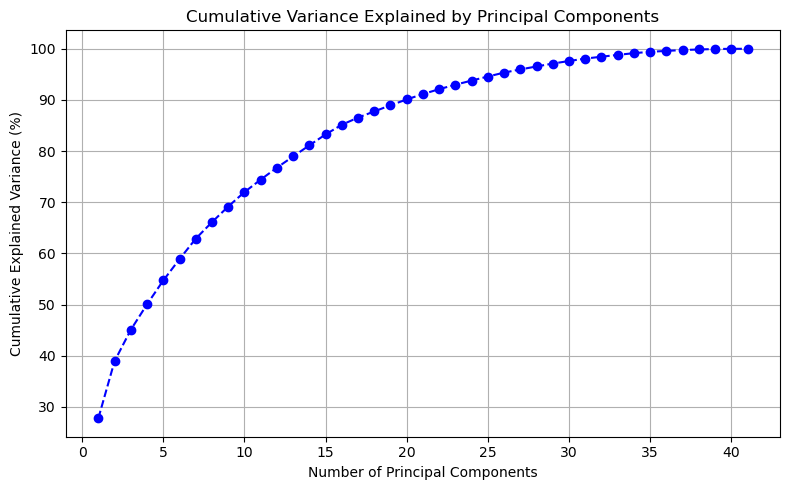

20 components explain 90.0% of the variance.


In [ ]:
# Perform PCA
pca = PCA()
pca.fit(X_train[binary_vars])

# Plot the cumulative explained variance, scree plot
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance (%)')  
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(True)
plt.tight_layout()
plt.show()

# Select components that explain 90% of the variance
cutoff = 0.90
best_n_components = np.argmax(cumulative_variance > cutoff) + 1
print(f"{best_n_components} components explain {cutoff * 100}% of the variance.")

In [39]:
nonbinary_vars = [var for var in continuous_vars if var not in binary_vars]

numeric_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), nonbinary_vars),
        ('pca', PCA(n_components=best_n_components), binary_vars)
    ], 
    remainder='passthrough', #binary variables passthrough
)

#### Model Pipeline
The following steps were implemented in the model pipeline to ensure a robust and reproducible process:
1. Scaling: Feature scaling was performed before SMOTE to avoid data leakage. If scaling is applied after SMOTE, the scaling process may inadvertently incorporate knowledge of the synthetic data into the validation sets, leading to an inflated test error.

2. SMOTE: The Synthetic Minority Oversampling Technique (SMOTE) was used to oversample the minority class, addressing the class imbalance problem effectively.

3. Logistic Regression: The logistic regression model was fitted using optimised hyperparameters, including L1 regularisation for feature selection and a balanced class weight to account for the class imbalance as an extra measure.

4. A pipeline was constructed to ensure that SMOTE operates only on the training data and is not applied to the test set, preserving the integrity of the evaluation process. This means that SMOTE is only applied to the training folds and not the validation folds during cross-validation.

In [40]:
nonbinary_vars = [var for var in continuous_vars if var not in binary_vars]

numeric_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), nonbinary_vars),
        ('pca', PCA(n_components=best_n_components), binary_vars)
    ], 
    remainder='passthrough', #binary variables passthrough
)


pipeline_logit = Pipeline(
    steps=[
        ('preprocessor', numeric_transformer),
        ("smote", SMOTE(sampling_strategy="auto", random_state=random_state)),
        (
            "clf",
            LogisticRegressionCV(
                Cs=np.logspace(-6, 6, 13),
                cv=5,
                penalty="l1",
                solver="liblinear",
                random_state=random_state,
                max_iter=2000,
                n_jobs=-1,
                class_weight="balanced",
                scoring="accuracy",
            ),
        ),
    ]
)


pipeline_logit.fit(X_train, y_train.values.ravel())

print(
    "Train Accuracy: {:.4f}".format(pipeline_logit.score(X_train, y_train)),
)


Train Accuracy: 0.5761


In [41]:
# Get out the components of the pipelines
X_train_scaled = pipeline_logit.named_steps["preprocessor"].transform(X_train)
X_train_smote, y_train_smote = pipeline_logit.named_steps["smote"].fit_resample(X_train_scaled, y_train)

X_test_scaled = pipeline_logit.named_steps["preprocessor"].transform(X_test)
X_test_smote, _ = pipeline_logit.named_steps["smote"].fit_resample(X_test_scaled, y_test)

best_logit_model = pipeline_logit.named_steps["clf"]

#### Tune Threshold

Threshold tuning is essential, particularly for imbalanced datasets, as it determines the optimal decision boundary for a classification model. It is often a strong assumption to claim that a threshold of 0.5 is universally optimal for all models, as it assumes equal costs for false positives and false negatives, which may not align with specific problem requirements. In this case, we tune the threshold to identify the best decision boundary for our model, using the F1 score as the metric. The F1 score is particularly suited to imbalanced datasets, as it balances precision and recall, ensuring fair evaluation of both classes.

Lowering the threshold increases sensitivity (recall), reducing false negatives at the expense of precision, while raising it improves precision but increases false negatives. This trade-off necessitates careful adjustment to optimise the model’s performance. Using TunedThresholdClassifierCV, the optimal threshold is identified via cross-validation based on the macro F1 score. This ensures a balanced approach between false positives and false negatives, addressing class imbalance effectively and improving the model’s applicability to the task.

In [42]:
best_logit_model_tuned = TunedThresholdClassifierCV(
    estimator = LogisticRegression(
        penalty='l1',
        C=best_logit_model.C_[0],
        solver='liblinear',
        random_state=random_state,
        max_iter=2000,
        class_weight='balanced'
    ),
    scoring = "f1_macro",
    n_jobs = -1,
    random_state = random_state
).fit(X_train, y_train.values.ravel())

In [43]:
print ("Optimal Threshold {:.4f}".format(best_logit_model_tuned.best_threshold_))

Optimal Threshold 0.5399


The optimal threshold was found to be slightly above the default value of 0.5. This suggest the model wants to sacrifice a bit of precision for recall. Even though this is counter to what we expected, since the baseline models had difficulty predicting the positive class.

#### Classification Report 

##### Train Set

In [45]:
# classification report using train data
y_train_pred_logit = best_logit_model_tuned.predict(X_train)
print("Classification Report on Training Data:")
print(classification_report(y_train, y_train_pred_logit , zero_division=0))

Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.76      0.73      0.75     19425
           1       0.39      0.44      0.41      7726

    accuracy                           0.65     27151
   macro avg       0.58      0.58      0.58     27151
weighted avg       0.66      0.65      0.65     27151



##### Test Set

In [46]:
# classification report using test data
y_test_pred_logit = best_logit_model_tuned.predict(X_test.values)
print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred_logit, zero_division=0))


Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.75      0.72      0.73      4775
           1       0.39      0.43      0.41      2013

    accuracy                           0.63      6788
   macro avg       0.57      0.57      0.57      6788
weighted avg       0.64      0.63      0.64      6788



c:\Users\Kai_R\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


The model demonstrates consistent performance across the training and test datasets, with an accuracy of 0.65 on the training set and 0.63 on the test set. This similarity suggests that the model is not overfitting, as the performance does not degrade significantly on unseen data.

Using the F1 score as the primary metric, we observe comparable results across the datasets. On the training data, the F1 score is 0.75 for class 0 and 0.41 for class 1, while on the test data, it is 0.73 for class 0 and 0.41 for class 1. The macro average F1 score remains consistent at 0.58 for the training set and 0.57 for the test set, indicating that the model’s ability to balance performance between the two classes generalises well.

When compared to the baseline logistic regression, the tuned model exhibits a slight improvement in F1 scores across both datasets. This improvement is evident for class 1, where the minority class's F1 score benefits from the use of techniques such as regularisation, SMOTE, and threshold tuning. These results highlight the robustness of the tuned model and its improved ability to handle imbalanced datasets effectively.

#### Confusion Matrix

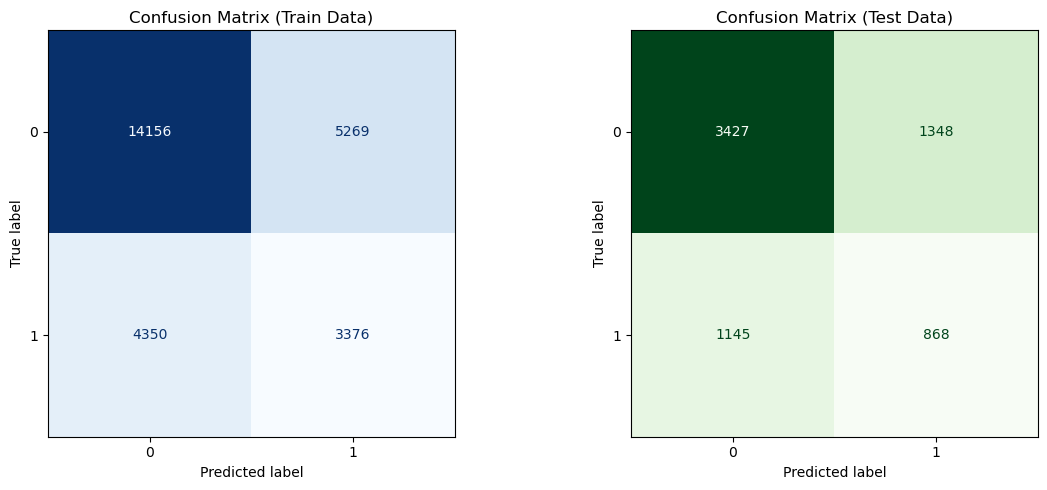

In [47]:
# CM Train data
cm_train = confusion_matrix(y_train, y_train_pred_logit)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=pipeline_logit.classes_)

#  CM Test Data
cm_test = confusion_matrix(y_test, y_test_pred_logit)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=pipeline_logit.classes_)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp_train.plot(ax=axes[0], cmap='Blues', colorbar=False)
axes[0].set_title('Confusion Matrix (Train Data)')

disp_test.plot(ax=axes[1], cmap='Greens', colorbar=False)
axes[1].set_title('Confusion Matrix (Test Data)')
plt.tight_layout()

Overall, the model performs suboptimally, with a high incidence of both false positives and false negatives. There does not appear to be a pronounced bias towards either type of error, as the errors are relatively balanced between Type I errors (false positives) and Type II errors (false negatives). This balance is likely a consequence of tuning the decision threshold to a value other than the default 0.5.

#### Feature Importance 

In [48]:
# extract features that have coefficient > shreshold
coefficients = best_logit_model.coef_.flatten()
threshold = 0.2
selected_features = [
    feature
    for feature, coef in zip(X_train.columns, coefficients)
    if abs(coef) > threshold
]
selected_coefficients = [coef for coef in coefficients if abs(coef) > threshold]

# Convert feature names to Title Case directly
selected_features_title_case = [" ".join(word.capitalize() for word in feature.split("_")) for feature in selected_features]

top_coefficients = pd.DataFrame(
    {"feature": selected_features, "coefficient": selected_coefficients}
).sort_values("coefficient", ascending=True, key=abs)

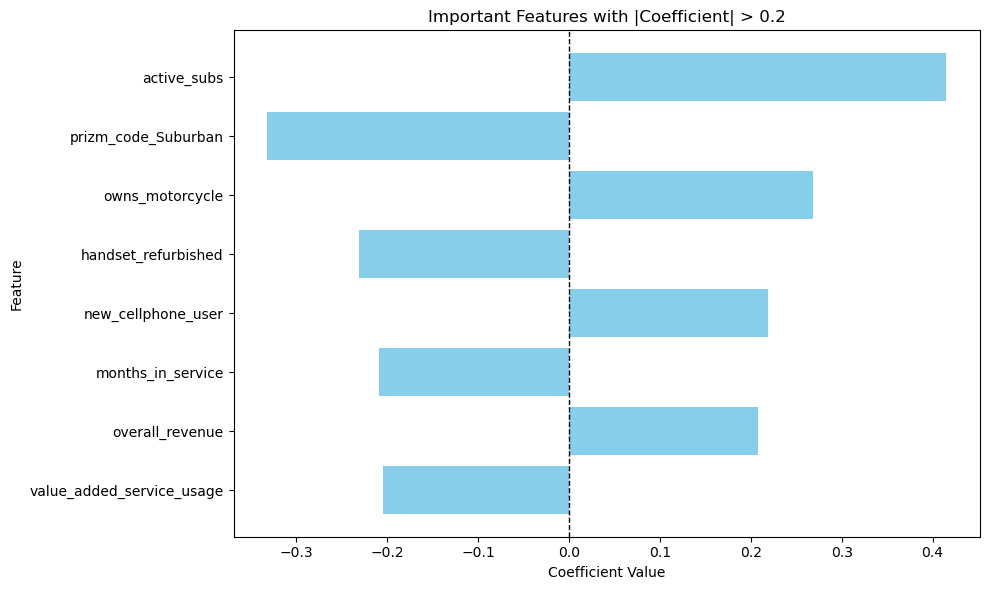

In [50]:
plt.figure(figsize=(10, 6))
plt.barh(top_coefficients["feature"], top_coefficients["coefficient"], color="skyblue")  
plt.axvline(0, color="black", linestyle="--", linewidth=1) 
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title(f"Important Features with |Coefficient| > {threshold}")
plt.tight_layout()
plt.show()

The top features based on coefficients are shown above. These are the ones with an absolute magnitude greater than 0.2. Interestingly, the dummy for suburban is the most important feature followed by prizm_code_Suburban. Months in service makes sense because it might be reflecting the end of the phone contract.

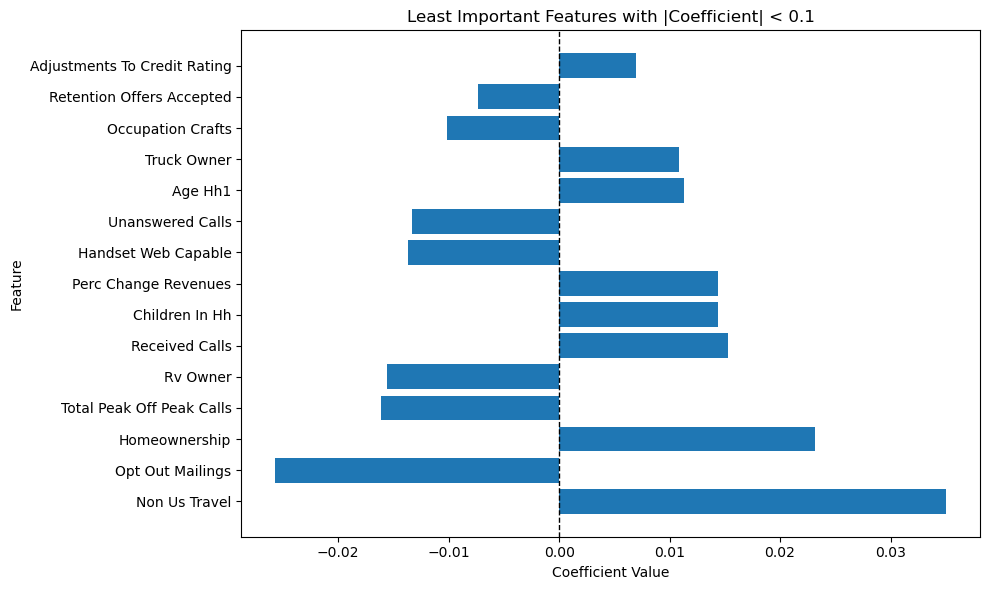

In [56]:
# Filter coefficients with |coefficient| < 0.1
filtered_coefficients = [coef for coef in coefficients if abs(coef) < 0.1]
filtered_features = [
    feature for feature, coef in zip(X_train.columns, coefficients) if abs(coef) < 0.1
]

# Convert feature names to Title Case
filtered_features_title_case = [" ".join(word.capitalize() for word in feature.split("_")) for feature in filtered_features]

# Create DataFrame for least important features
bottom_coefficients = pd.DataFrame(
    {"feature": filtered_features_title_case, "coefficient": filtered_coefficients}
).sort_values("coefficient", ascending=False, key=abs).tail(15)


plt.figure(figsize=(10, 6))
plt.barh(bottom_coefficients["feature"], bottom_coefficients["coefficient"])  
plt.axvline(0, color="black", linestyle="--", linewidth=1) 
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title(f"Least Important Features with |Coefficient| < 0.1")
plt.tight_layout()
plt.show()


The model identified 15 features with coefficients close to zero ($∣\text{coefficient}∣<0.1$), indicating minimal influence on predictions. Notable features like "Retention Offers Accepted," "RV Owner," and "Non US Travel" exhibit weak predictive power, aligning with the expectation that these variables have limited relevance to churn. Interestingly, "Retention Calls" and "Opt Out Mailings," which might be expected to play a larger role, also show minimal impact, suggesting weaker-than-anticipated associations with churn.

While these features do not significantly affect the model's performance, they may still provide domain-specific insights or guide future feature refinement efforts. The use of L1 regularisation effectively highlights their limited contribution by shrinking their coefficients toward zero.

#### Model Performance: AUC-ROC Curve


In [57]:
def plot_roc_curves_binary(models, X, y_trues, data_label = 'Train'):
    plt.figure(figsize=(7, 5))
    
    # Dictionary to store AUC for each model
    aucs = {}
    
    for name, model in models.items():
        # Get probability predictions (we want probability of class 1)
        # y_score = cross_val_predict(model, X[name], y_true, method='predict_proba', cv=5)[:, 1]
        y_score = model.predict_proba(X[name])[:, 1]
        y_true = y_trues[name]
        
        # Calculate ROC curve and ROC area
        fpr, tpr, _ = roc_curve(y_true, y_score)

        roc_auc = roc_auc_score(y_true, y_score)
        
        aucs[name] = roc_auc_score(y_true, y_score)
        
        # Plot ROC curve for this model
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
    

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {data_label}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return aucs

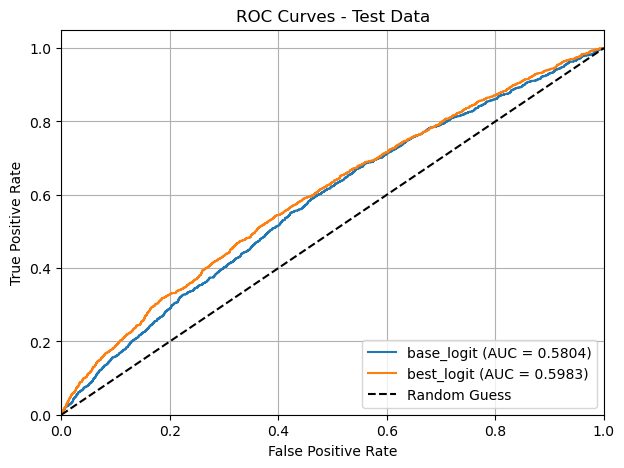

In [58]:
models = {
    'base_logit': logit_model,
    'best_logit': best_logit_model,
}
X_trains = {
    'base_logit': X_test[top5_features],
    'best_logit': X_test_scaled,
}

y_trains = {
    'base_logit': y_test,
    'best_logit': y_test,
}

aucs = plot_roc_curves_binary(models, X_trains, y_trains, data_label='Test Data')

The ROC curve comparison demonstrates a clear improvement in performance between the our tuned logistic model and the Baseline Model. The Baseline Model achieves an AUC of 0.5804 on the test data, indicating weak discriminatory power and limited generalisation capability. In contrast, the Improved Model shows an improvement, with an AUC 0.5983 on the test data, reflecting its stronger ability to distinguish between classes and generalise effectively. We use AUC-ROC as a performance metric because it has been shown to be a better performance metric than accuracy (Ling et al., 2003).



### Random Forest

In this section, we look to improve predictive performance with a random forest model. We opt for a random forest model because, unlike logistic regression, random forest is able to generate decision boundaries beyond the geometries capable of logistic regression. It is also more performant than a single decision tree, which is prone to overfitting. Lastly, random forest generates de-correlated trees, which makes the model more generalizable.


In this section, class imbalance is left as is because trees are robust to class imbalance and prior research on this data set has shown that resampling techniques do not improve model performance (Abdulkadir, 2022). We opt instead for class weights, computed per bootstrap sample by setting the class weights parameter to "balanced_subsample". The data will not be scaled because scaling does not make a difference with tree based models. Scaling only changes the distance and not the ordering of the points. The model evaluation metric is the f1-score because it is more reliable than accuracy in the presence of imbalanced classes.

Our strategy for building the Random Forest model is as follows:


1. The first experiment we run is to determine the optimal number of estimators. Note that random forest models do not overfit, instead the test error plateaus. This is shown by Theorem 1.2 in the Appendix, adapted from "Random Forests" (Breiman, 2001). Regardless, finding the point where the test error plateaus is important in order to save computational resources. We will use the OOB error (Definition 2) to determine the number of estimators because 1) it provides a good estimate of the test error and 2) is computationally efficient. For speed, we will use large step sizes to get a general sense of where the test error plateaus. For this experiment we do not prune the trees because it was recommended not to do so in the original paper (Breiman 2001).


2. The second experiment determines whether to use a balanced or unbalanced. We will keep the number of estimators fixed and vary the max depth and the max leaf nodes. When using max depth the tree grows in a level-order fashion. In contrast when “max_leaf_nodes” is used, the tree grows in a best-first fashion. We will use the OOB error to compare the two models.


The model that achieves a greater max OOB error will be chosen. OOB was chosen because it provides a good estimate of the test error and is generated during training, removing the need to create validation folds. This stems from the fact that $\frac{1}{e}$ of the data is not used to train each tree due to bootstrapping properties (Lemma 2). Although, f1-score is the primary metric used in this project, we allow this discrepancy due to the extensive run time of using validation folds. Finally note that OOB error is equivalent to LOOCV for large $B$ (Lemma 5), therefore the OOB error has high variance but low bias.


**Mathematical Aside**


Recall that the average of $B$ i.i.d random variables with variance $\sigma^2$ has variance $\frac{\sigma^2}{B}$. If the variables are identically distributed but not independent with correlation $\rho$, the variance of the average is given by


$$
Var(X) = \rho \sigma^2 + \frac{1-\rho}{B} \sigma^2
$$


, where $X = \sum_{i=1}^B X_i$. When you have decorrelated trees, as with the case of random forest, the first term vanishes. This formula underpins the motivation for using Random Forest since each tree is identically distributed because all trees have the same hyperparameters.



#### Model Flow

<p align="center">
<img src="./img/rf_flow.png" alt="drawing" width="600"/>
</p>

The diagram above outlines the flow of the Random Forest model. Unlike other models, there was no data preprocessing because Random Forest is fairly robust to class imbalance and does not require feature scaling. Scaling is a monotonic transformation that preserves the order of the data.

#### Experiment 1 - Finding Number of Estimators


For this experiment we set `max_leaf_nodes` and `max_depth` to "None" in order to grow the tree deep. The point of this experiment is to see where the test error plateaus. As stated before, we set the class weights to be balanced within the subsample, this means that class weights are adjusted to each individual bootstrapped sample. If the parameter was set to "balanced", the class weights will be calculated from the entire training set, with each tree given the same class weights.

In [151]:
res_df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])
criterion = ['gini', 'entropy']

# Set large because we want to see where the overfitting happens
initial_n = 100
end_n = 800
step = 50

# Find max leaf nodes
results = []
for cur_criterion in criterion:      
    for n_estimator in range(initial_n, end_n, step):
        
        rf = RandomForestClassifier(
            n_estimators=n_estimator, 
            criterion=cur_criterion, 
            min_samples_split=2,
            min_samples_leaf=1,
            max_leaf_nodes=None, 
            max_depth=None,
            random_state=random_state, 
            class_weight='balanced_subsample',
            oob_score=True
        ).fit(X_train, y_train.values.ravel())
                
        cur_results = {
            'criterion': cur_criterion,
            'n_estimators': n_estimator,
            'mean_cv': rf.oob_score_
        }
        results.append(cur_results)
res_df = pd.DataFrame(results)

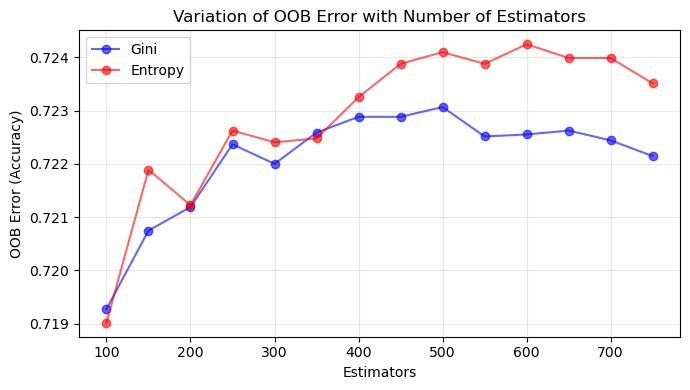

In [152]:
plt.figure(figsize=(7, 4))

#Gini Plot
plt.plot(
    res_df[res_df.criterion == 'gini'].n_estimators,
    res_df[res_df.criterion == 'gini'].mean_cv, 
    'b-', 
    marker='o', 
    alpha = 0.6, 
    label='Gini'
)
# Entropy Plot
plt.plot(
    res_df[res_df.criterion == 'entropy'].n_estimators,
    res_df[res_df.criterion == 'entropy'].mean_cv, 
    'r-', 
    marker='o', 
    alpha = 0.6, 
    label='Entropy'
)

plt.ylabel("OOB Error (Accuracy)")
plt.xlabel("Estimators")
plt.title('Variation of OOB Error with Number of Estimators')
plt.legend()
plt.grid(alpha = 0.3)

plt.tight_layout()
plt.show()

From the plot above we see that the optimal number of estimators is around 400-500 since the OOB error plateaus. It is interesting that the OOB error for entropy increases and doesn't show a plateau quite yet but for the sake of computation time we will choose 400 estimators. An added bonus of this result shows that entropy performs slightly better than Gini. Recall that entropy as a measure is more harsh than Gini, meaning it is more sensitive to changes near the decision boundary. This means entropy can lead to finer splits and potentially better performance.

Experiment 1 Results
- Criteria: Entropy
- Number of Estimators: 500

#### Experiment 2 - Balanced vs Unbalanced Tree


Here, we determine whether growing a tree in a level-order fashion (max depth) or a best-first fashion (max leaf nodes) is better. We keep the number of estimators fixed at 400 because in the prior experiment we determined this is the number where the test error flattens. Like the prior experiment, the class weights are set to be balanced within the subsample. All other parameters are set such that the trees are allowed to grow deep. The tree that achieves the highest maximum OOB error will be chosen.

In [172]:
initial_depth = 10
end_depth = 100
step = 10

exp2_results = []

for depth in range(initial_depth, end_depth, step):
        
    rf = RandomForestClassifier(
        n_estimators=500, 
        criterion="entropy", 
        min_samples_split=2,
        min_samples_leaf=1,
        max_depth=depth,
        random_state=random_state, 
        class_weight='balanced_subsample',
        oob_score=True
    ).fit(X_train, y_train.values.ravel())
            
    cur_results = {
        'max_depth': depth,
        'mean_cv': rf.oob_score_
    }
    print (cur_results)
    exp2_results.append(cur_results)

{'max_depth': 10, 'mean_cv': 0.6047291075835144}
{'max_depth': 20, 'mean_cv': 0.7135280468491032}
{'max_depth': 30, 'mean_cv': 0.7234356008986778}
{'max_depth': 40, 'mean_cv': 0.7233987698427314}
{'max_depth': 50, 'mean_cv': 0.7236934182903024}
{'max_depth': 60, 'mean_cv': 0.7240985599057125}
{'max_depth': 70, 'mean_cv': 0.7240985599057125}
{'max_depth': 80, 'mean_cv': 0.7240985599057125}
{'max_depth': 90, 'mean_cv': 0.7240985599057125}


In [181]:
initial_nodes = 4000
end_nodes = 7000
step = 500

exp2_results_unbalanced = []

for max_node in range(initial_nodes, end_nodes, step):
        
    rf = RandomForestClassifier(
        n_estimators=500, 
        criterion="entropy", 
        min_samples_split=2,
        min_samples_leaf=1,
        max_leaf_nodes=max_node,
        random_state=random_state, 
        class_weight='balanced_subsample',
        oob_score=True
    ).fit(X_train, y_train.values.ravel())
            
    cur_results = {
        'max_leaf_nodes': max_node,
        'mean_cv': rf.oob_score_
    }
    print (cur_results)
    exp2_results_unbalanced.append(cur_results)

{'max_leaf_nodes': 4000, 'mean_cv': 0.7217045412691981}
{'max_leaf_nodes': 4500, 'mean_cv': 0.7215572170454126}
{'max_leaf_nodes': 5000, 'mean_cv': 0.7231041213951604}
{'max_leaf_nodes': 5500, 'mean_cv': 0.7229936282273213}
{'max_leaf_nodes': 6000, 'mean_cv': 0.7229936282273213}
{'max_leaf_nodes': 6500, 'mean_cv': 0.7229936282273213}


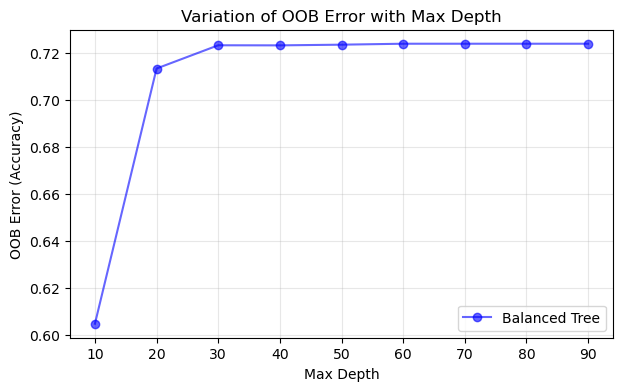

In [182]:
plt.figure(figsize=(7, 4))

exp2_results = pd.DataFrame(exp2_results)

# Balanced Tree
plt.plot(
    exp2_results.max_depth,
    exp2_results.mean_cv,
    'b-', 
    marker='o', 
    alpha = 0.6, 
    label='Balanced Tree'
)
plt.ylabel("OOB Error (Accuracy)")
plt.xlabel("Max Depth")
plt.title('Variation of OOB Error with Max Depth')
plt.legend()
plt.grid(alpha = 0.3)

plt.show()

The OOB error plateaus at a max depth of 30. Even though this may seem quick, trees grow by a factor of 2^n. A max depth limit of 30 is equivalent to setting a limit of 1 billion nodes.

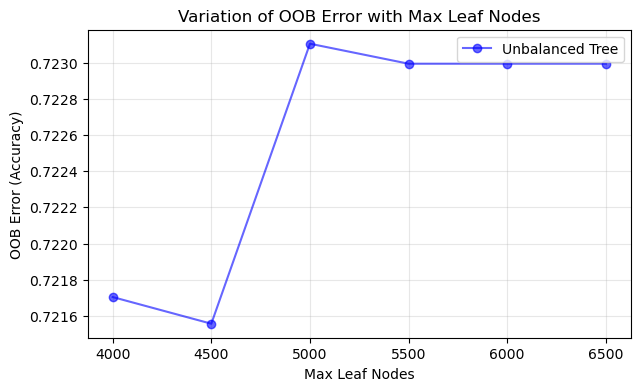

In [183]:
plt.figure(figsize=(7, 4))

exp2_results_unbalanced = pd.DataFrame(exp2_results_unbalanced)

# Unbalanced Tree
plt.plot(
    exp2_results_unbalanced.max_leaf_nodes,
    exp2_results_unbalanced.mean_cv,
    'b-', 
    marker='o', 
    alpha = 0.6, 
    label='Unbalanced Tree'
)
plt.ylabel("OOB Error (Accuracy)")
plt.xlabel("Max Leaf Nodes")
plt.title('Variation of OOB Error with Max Leaf Nodes')
plt.legend()
plt.grid(alpha = 0.3)

plt.show()

We see that a balanced tree tops out a 0.724 OOB accuracy while the unbalanced tree has a peak of 0.723. The maximum depth at the peak was 60. The quick experiment showed that it doesn't matter much if the tree is balanced or unbalanced. Regardless, we'll use the balanced tree going forward.


Experiment 2 Results
- Tied, but we will choose a balanced tree.


#### Hyperparameter Tuning


Our hyperparameter tuning strategy is as follows:


1. We will use `RandomSearchCV` to find areas in the hyperparameter space that are promising. Once we identified these areas we will sort based on performance and take the range of hyperparameters that performed the best. The motivating reason behind random search is that the dimensions of the hyperparameter space is theoretically infinite. All hyperparameters $h \in \mathbb{R}^+$ except for `min_impurity_decrease`, which is between [0, 1]. However it has been shown that there are an infinite number of rational numbers between two real numbers (Pugh 2013). So again the space is infinite. 
2. We will then use `GridSearchCV` to find the optimal hyperparameters within the range we identified in step 1. This is a more efficient method than grid searching right off the bat because it uses information from random searching to restrict to a smaller search space.
3. We will then tune the threshold to find the optimal threshold for the model, optimizing for f1-score.


In [184]:
rf_model = RandomForestClassifier(
    n_estimators=500, 
    criterion="entropy", 
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=60,
    random_state=random_state, 
    class_weight='balanced_subsample',
)

In [185]:
rf_tuned = TunedThresholdClassifierCV(
    estimator = rf_model,
    scoring = "f1_macro",
    n_jobs = -1,
    random_state = random_state
).fit(X_train, y_train.values.ravel())

In [186]:
print ("Best Threshold: {:.4f}".format(rf_tuned.best_threshold_))

Best Threshold: 0.3327


The best threshold is less than the default of 0.5. This aligns with what we witnessed in the baseline model results, where the positive class was difficult to predict. This result further substantiates the fact that the models have difficulty predicting a positive class.

#### Model Results

In [192]:
# classification report using train data
y_train_pred_rf = rf_tuned.predict(X_train)
print("Classification Report on Training Data:")
print(classification_report(y_train, y_train_pred_rf, zero_division=0))

Classification Report on Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19425
           1       1.00      1.00      1.00      7726

    accuracy                           1.00     27151
   macro avg       1.00      1.00      1.00     27151
weighted avg       1.00      1.00      1.00     27151



In [193]:
# classification report using test data
y_test_pred_rf = rf_tuned.predict(X_test)
print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred_rf, zero_division=0))

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.77      0.74      0.75      4775
           1       0.43      0.47      0.45      2013

    accuracy                           0.66      6788
   macro avg       0.60      0.60      0.60      6788
weighted avg       0.67      0.66      0.66      6788



The results of the training data show that the model is overfitting, as counterintuitive as it sounds, this is exactly what we seek. Provided that the data is bootstrapped and random forest's trees are decorrelated there is no fear of a low test error. The results on the test data show this is true. We achieved the highest f1-score, which is around 0.60, an improvement over the logistic regression model.

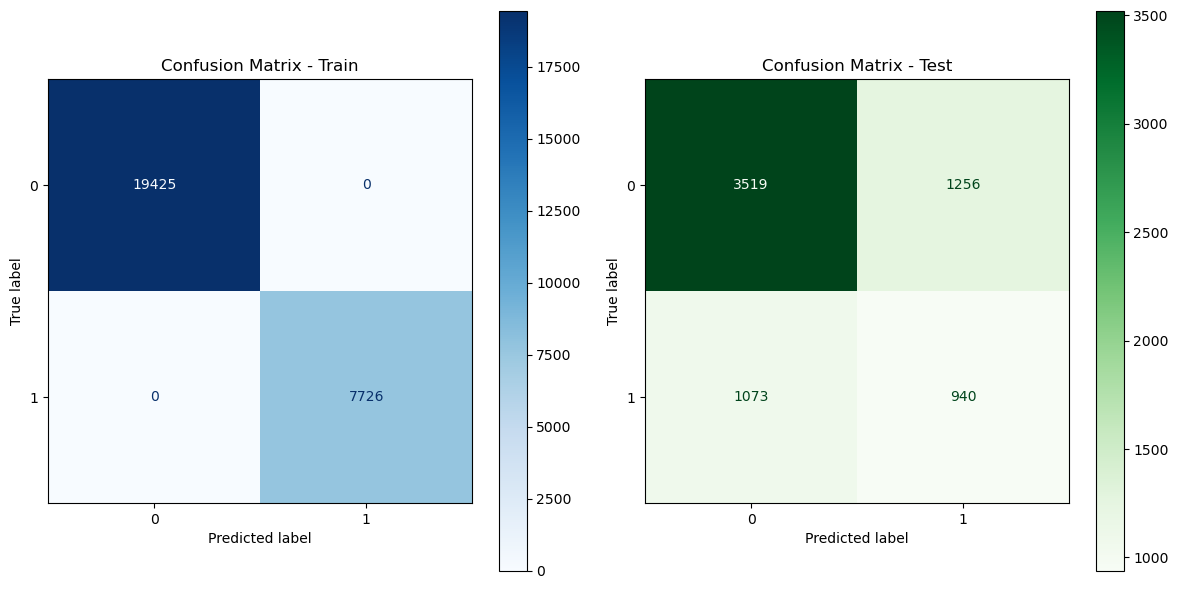

In [194]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

ConfusionMatrixDisplay.from_predictions(
    y_train,
    rf_tuned.predict(X_train),
    cmap=plt.cm.Blues,
    ax=axes[0]
)
axes[0].set_title('Confusion Matrix - Train')

ConfusionMatrixDisplay.from_predictions(
    y_test,
    rf_tuned.predict(X_test),
    cmap=plt.cm.Greens,
    ax=axes[1] 
)
axes[1].set_title('Confusion Matrix - Test')

plt.tight_layout()


The confusion matrices reiterate what was shown in the prior printouts, so we'll be brief. The model has successfully overfit on the train but the test error is low because the averaging of the trees has reduced the variance. The off diagonal elements are still high and the model has difficulty predicting the positive class. 

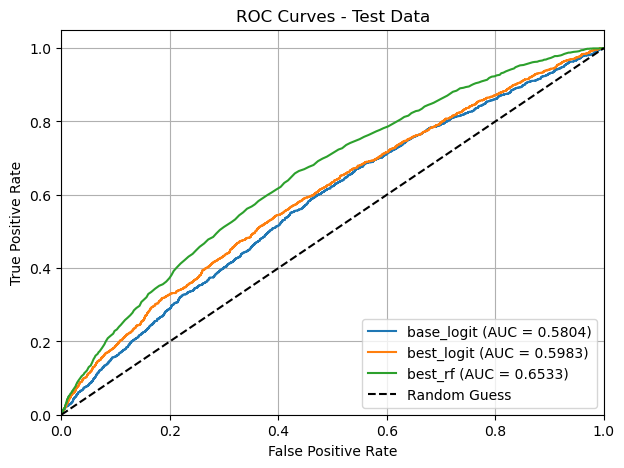

In [195]:
models = {
    'base_logit': logit_model,
    'best_logit': best_logit_model,
    'best_rf': rf_tuned.estimator_
}
X_trains = {
    'base_logit': X_test[top5_features],
    'best_logit': X_test_scaled,
    'best_rf': X_test,
}

y_trains = {
    'base_logit': y_test,
    'best_logit': y_test,
    'best_rf': y_test,
}

aucs = plot_roc_curves_binary(models, X_trains, y_trains, data_label='Test Data')

Following the paper's methodology, we constructed a random forest model with deep trees, relying on the averaging to reduce variance. We used entropy as the criterion because it is more sensitive to changes near the decision boundary. As such, entropy can lead to finer splits and potentially better performance. The AUC has shown a marked improvement compared to the prior models and the test accuracy and f1 score have also improved, see Model Performance Table for comparison.

#### Feature Importance

##### MDI

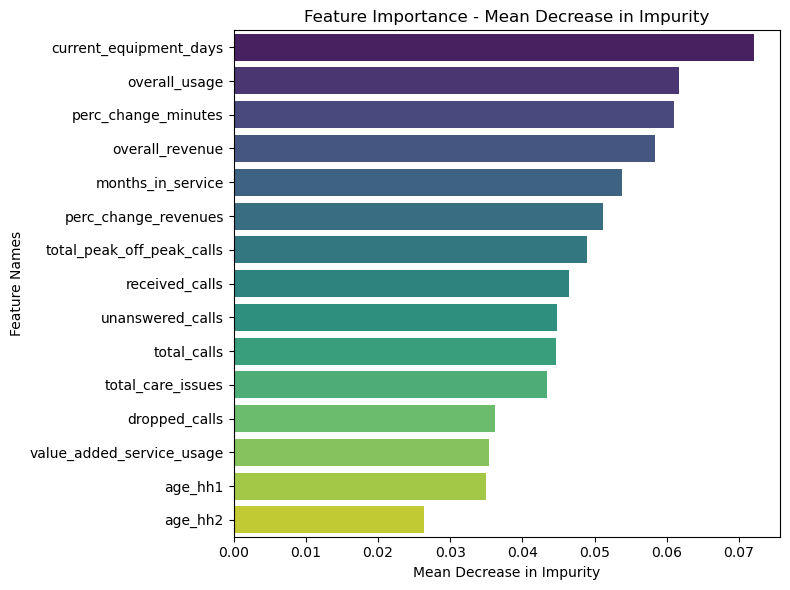

In [191]:
feature_importance = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": rf_tuned.estimator_.feature_importances_}
).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=feature_importance.head(15), 
    palette="viridis",
    hue="Feature"
)
plt.title("Feature Importance - Mean Decrease in Impurity")
plt.xlabel("Mean Decrease in Impurity")
plt.ylabel("Feature Names")
plt.tight_layout()

**MDI: Mean Decrease Impurity**

MDI ranks variables by their contribution to reducing impurity in decision trees. The metric essentially finds every split that uses a given feature $q$ and computes the decrease in impurity from parent node to child nodes. The decreases are summed up over the tree and averaged over all trees in the forest to yield the MDI. Definition can be found in the Appendix. 

The top 3 features based on MDI are:
- current_equipment_days
- overall_usage
- perc_change_minutes

The one drawback of MDI is that it slightly favors features with high cardinality. Features with high cardinality by definition have more splits and therefore have a greater chance of appearing in tree splits (Lecture 20, Slide 48). This leads us to conduct a second feature importance test which is permutation importance.

##### Permutation Importance

In [ ]:
result = permutation_importance(
    rf_tuned.estimator_, 
    X_train, 
    y_train,
    n_repeats=5,
    random_state=random_state
)

# Create dataframe of permutation importances
perm_imp = pd.DataFrame({
    # 'feature': X_train_dt.columns,
    'feature': X_train.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values('importance_mean', ascending=False)

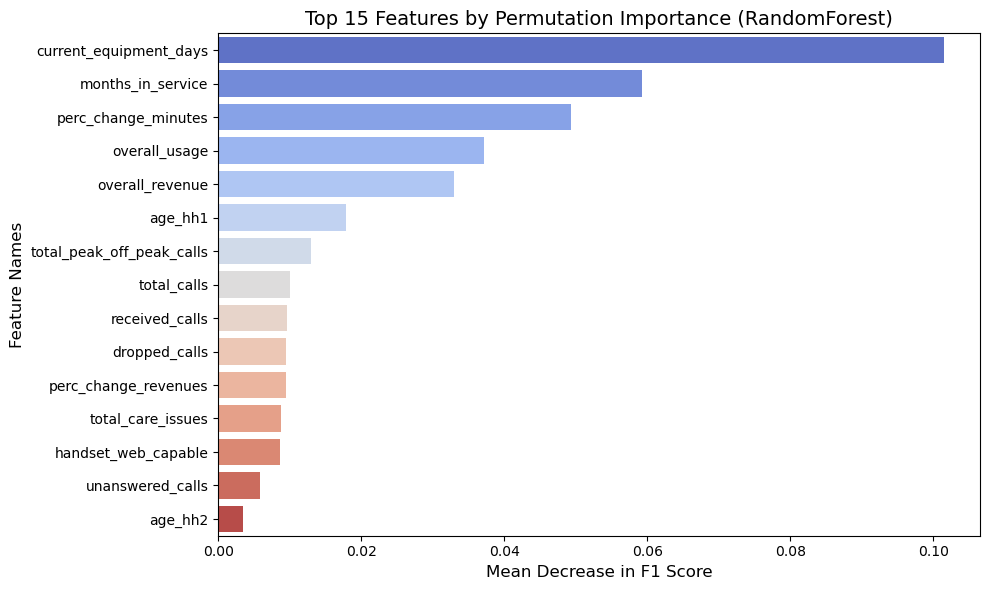

In [200]:
pi_df_sorted = perm_imp.sort_values("importance_mean", ascending=False).reset_index(
    drop=True
)

plt.figure(figsize=(10, 6))

sns.barplot(
    x="importance_mean", 
    y="feature", 
    data=pi_df_sorted.head(15), 
    palette="coolwarm",
    hue="feature"
)
plt.title("Top 15 Features by Permutation Importance (RandomForest)", fontsize=14)
plt.xlabel("Mean Decrease in F1 Score", fontsize=12)
plt.ylabel("Feature Names", fontsize=12)
plt.tight_layout()

**Permutation Importance**


The permutation importance of a feature is the drop in model accuracy when a given feature is shuffled. For $K$ shuffles, the value is


$$
s - \frac{1}{K} \sum_{i=1}^K s_{k}
$$


where $s$ is the original score and $s_{k}$ is the score for the $k$-th shuffle.


The top 3 features based on permutation importance are:
- current_equipment_days
- months_in_service
- perc_change_minutes


Notice that the features in permutation importance and MDI don't necessarily agree, although in our case it comes quite close. The reason is that MDI focuses on the impurity reduction of a single split. This means that MDI may miss the interaction effects that a given feature has with other features. Permutation importance on the other hand captures these interaction effects because it shuffles the feature and any interaction effects that include the feature will be lost as well.

...

### Boosted Models

**Overview**


For our final prediction model, we opt for a boosting algorithm. Boosting differs from bagging because optimization occurs in function space and not the parameter space. Rather than finding the optimal set of parameters, the objective is to find the optimal function $\hat{f}: X \rightarrow y$. The optimal mapping is found by minimizing the loss function; MSE for regression and log-loss for classification. Focusing on classification, each subsequent tree predicts the residuals which is defined as $r_i = y_i - \hat{y}_i$, where $\hat{y}_i = \hat{p}_i$, the predicted probability of the majority class. The reason why we fit on the residuals is because the residuals are the negative gradient of the loss function (Lecture 21, Slide 22).


Another important note is that minimizing the loss function directly results in $\hat{y} = y$. However doing so would pose two problems: the first is that the solution gives no mapping $X \rightarrow y$ and the second is that any model that predicts this is surely to overfit. The solution is to restrict the learners to select a family of functions, which will then be used to approximate the residuals. For classification, the family of functions is restricted to the set of shallow classification trees.


Our choice of models are AdaBoost and Gradient Boosting (classification trees). We'll use the same pipeline as before. All results are displayed at the end of the section.


**Methodology**


The first tree, in the case of gradient boosting, is a stump that predicts the probability of the majority class. The subsequent trees are trained recursively on the residuals of the previous tree. As a result, we do not get the benefit of averaging over many uncorrelated samples and trees, making overfitting a concern. The objective of the first experiment is to find the number of trees for which the boosted model will overfit.


From there we conduct hyperparameter tuning. As mentioned in the prior section, the space of possible hyperparameters is theoretically infinite. Therefore we will do the search in stages:


1) Random search to find promising areas in the hyperparameter space using `RandomSearchCV`.
2) Using the range of the top 5 hyperparameters from step 1, we will construct another, smaller set of hyperparameters to search over
3) We will then use `GridSearchCV` to find the optimal hyperparameters within the range we identified in step 2. This restricts the search space to a smaller area and allows us to find the optimal hyperparameters.
4) We tune the threshold, optimizing for f1-score



### AdaBoost

#### Model Flow

<p align="center">
<img src="./img/ada_flow.png" alt="drawing" width="500"/>
</p>

The diagram above outlines the flow for the Adaboost model. It visually represents what we just discussed in the methodology section.

#### Random Search

The random search was conducted to find promising areas in the hyperparameter space. The range of values was set to be large and step size was set to be large as well. The search was conducted using 10 iterations for fast experimentation. The top 3 hyperparameters were selected for further tuning because top 5 hyperparameters resulted in a range that was too large.

In [201]:
nonbinary_vars = [var for var in continuous_vars if var not in binary_vars]

ada_pipeline = Pipeline(steps=[
    ('preprocessor',ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), nonbinary_vars)
        ],
        remainder='passthrough'
    )),
    ('classifier', AdaBoostClassifier(
        estimator = DecisionTreeClassifier(max_depth=1),
        algorithm="SAMME"
    ))
])

param_grid = {
    'classifier__n_estimators': np.arange(50, 800, 50),
    'classifier__learning_rate': np.logspace(-4, 0, 8),
    'classifier__estimator__max_depth': np.arange(1, 10, 1),
}

rsearch = RandomizedSearchCV(
    ada_pipeline,
    param_distributions=param_grid,
    n_iter=10,
    scoring='f1_macro',
    n_jobs=-1,
    cv=5,
    random_state=random_state,
    verbose=1
).fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [202]:
top_5_results = rsearch.cv_results_['mean_test_score']
top_5_indices = np.argsort(top_5_results)[-5:][::-1]
top_5_params = rsearch.cv_results_['params']
top_5_scores = top_5_results[top_5_indices]

In [203]:
ada_top_5 = pd.DataFrame(top_5_params).iloc[top_5_indices]
ada_top_5['score'] = top_5_scores
ada_top_3 = ada_top_5.head(3)
ada_top_3

classifier__n_estimators  classifier__learning_rate  \
9                       300                        1.0   
2                       150                        1.0   
7                       650                        1.0   

   classifier__estimator__max_depth     score  
9                                 7  0.562746  
2                                 5  0.546309  
7                                 2  0.511491

The top 3 hyperparameters give us the range of values to grid search over. This is what we will do in the next step.


A side note, the learning rate is an additional dampening multiplier on the contribution of each tree. Adaboost on its own has a $\lambda$ that is found by minimizing the exponential loss. The learning rate in Sklearn multiplies this. Interestingly, results show that the optimal lambda is the best. An additional dampening factor is not necessary.

#### Grid Search

We now use the range of values from the random search to grid search over. The grid search is conducted over 5 folds and the best hyperparameters are selected based on the f1-score.

In [204]:
restricted_est = np.arange(
    ada_top_3["classifier__n_estimators"].min(),
    ada_top_3["classifier__n_estimators"].max() + 1,
    50,
)
restricted_depth = np.arange(
    ada_top_3["classifier__estimator__max_depth"].min(),
    ada_top_3["classifier__estimator__max_depth"].max() + 1,
    1,
)

In [205]:
ada_boost_param_grid = {
    'classifier__n_estimators': restricted_est,
    'classifier__learning_rate': [1],
    'classifier__estimator__max_depth': restricted_depth,
}

In [206]:
gsearch = GridSearchCV(
    ada_pipeline,
    param_grid=ada_boost_param_grid,
    scoring='f1_macro',
    n_jobs=-1,
    cv=5,
    verbose=1
).fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 66 candidates, totalling 330 fits


In [207]:
gsearch.best_params_

{'classifier__estimator__max_depth': np.int64(6),
 'classifier__learning_rate': 1,
 'classifier__n_estimators': np.int64(300)}

#### Tune Threshold

In [209]:
best_adaboost_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(
        max_depth=gsearch.best_params_["classifier__estimator__max_depth"]
    ),
    n_estimators=gsearch.best_params_["classifier__n_estimators"],
    learning_rate=gsearch.best_params_["classifier__learning_rate"],
    algorithm="SAMME"
)

In [210]:
best_adaboost_model_tuned = TunedThresholdClassifierCV(
    estimator = best_adaboost_model,
    scoring = "f1_macro",
    n_jobs = -1,
    random_state = random_state
).fit(X_train, y_train.values.ravel())
print ("Optimal Threshold {:.4f}".format(best_adaboost_model_tuned.best_threshold_))

Optimal Threshold 0.4793


The optimal threshold like the prior model is less than 0.5, which indicates the model has difficulty predicting the positive class. This seems to be an underlying data issue. As shown in the EDA section, there are essentially no features with a strong correlation with churn.

In [211]:
# classification report using train data
y_train_pred_ada = best_adaboost_model_tuned.predict(X_train)
print("Classification Report on Training Data:")
print(classification_report(y_train, y_train_pred_ada, zero_division=0))

Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     19425
           1       0.62      0.66      0.64      7726

    accuracy                           0.79     27151
   macro avg       0.74      0.75      0.75     27151
weighted avg       0.79      0.79      0.79     27151



In [212]:
# classification report using test data
y_test_pred_ada = best_adaboost_model_tuned.predict(X_test)
print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred_ada, zero_division=0))

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      4775
           1       0.40      0.41      0.41      2013

    accuracy                           0.65      6788
   macro avg       0.58      0.58      0.58      6788
weighted avg       0.65      0.65      0.65      6788



The results show that the AdaBoost model performs slightly worse than the Random Forest model. The f1-score is slightly lower, same for accuracy. Results between models will be summarized in the Model Performance Table.

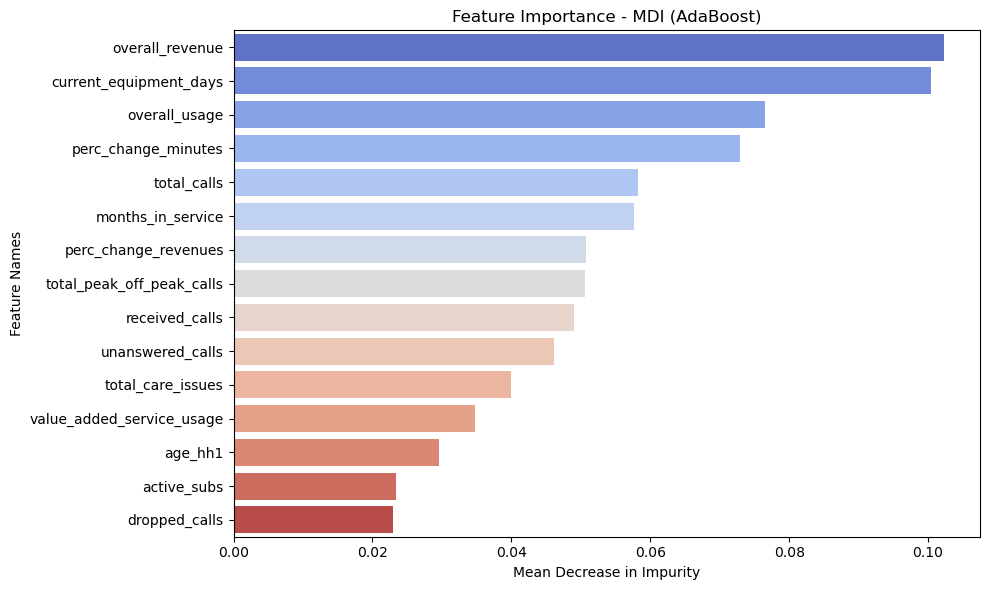

In [213]:
best_model = best_adaboost_model_tuned.estimator_

feature_importance = best_model.feature_importances_

importance_df = pd.DataFrame(
    {"Feature": X_train.columns, "Importance": feature_importance}
)

importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df.head(15), 
    palette="coolwarm",
    hue="Feature"
)
plt.title("Feature Importance - MDI (AdaBoost)")
plt.xlabel("Mean Decrease in Impurity")
plt.ylabel("Feature Names")
plt.tight_layout()
plt.show()

The top 3 features based on MDI are:
- overall_revenue
- current_equipment_days
- overall_usage


The interesting takeaway from this chart is how close overall revenue is to current equipment days. In all prior feature importance plots there has been a distinctive winner.

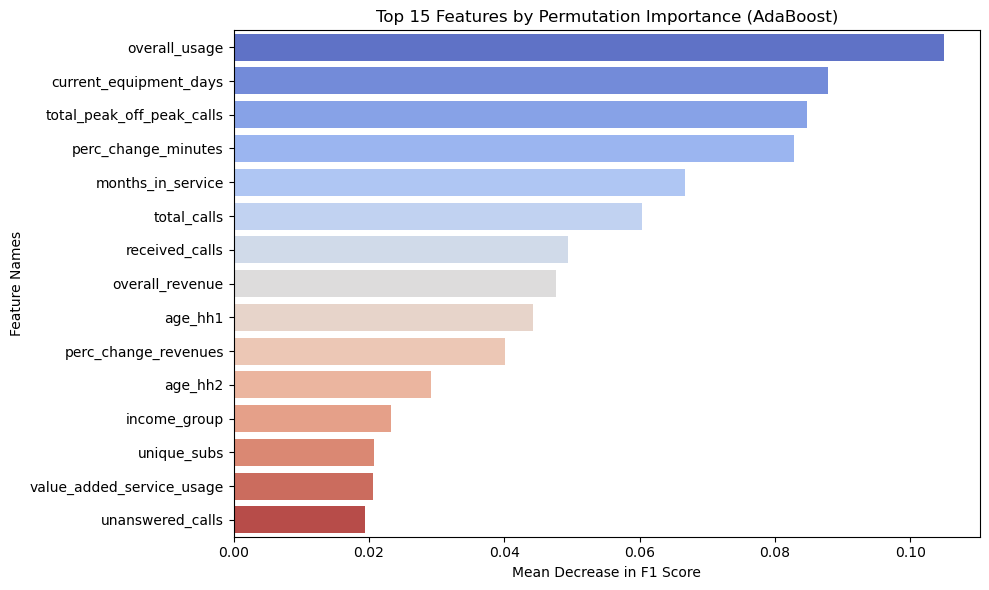

In [214]:
pi_results = permutation_importance(
    best_adaboost_model_tuned.estimator_,
    X_train,
    y_train,
    n_repeats=5,
    random_state=random_state,
    scoring="f1",
)

pi_data = {
    "Feature": X_train.columns,
    "Importance Mean": pi_results["importances_mean"],
    "Importance Std": pi_results["importances_std"],
}
pi_df = pd.DataFrame(pi_data)


pi_df_sorted = pi_df.sort_values("Importance Mean", ascending=False).reset_index(
    drop=True
)

plt.figure(figsize=(10, 6))

sns.barplot(
    x="Importance Mean", 
    y="Feature", 
    data=pi_df_sorted.head(15), 
    palette="coolwarm",
    hue="Feature"
)
plt.title("Top 15 Features by Permutation Importance (AdaBoost)")
plt.xlabel("Mean Decrease in F1 Score")
plt.ylabel("Feature Names")
plt.tight_layout()

The top 3 features based on Permutation Importance are:
- overall_usage
- current_equipment_days
- total_peak_off_peak_calls

As with this test, there is a clear winner: "overall usage". Again this test is preferred to MDI because it captures interaction effects and is not biased to high cardinality features.

### Gradient Boosting

The final predictive model in our project is gradient boosting. For gradient boosting, we had a lot of trouble with run-time being an issue, having initially used `GradientBoostingClassifier`. After doing some research, we found a few papers on Histogram Based Gradient Boosting, which is much more efficient than regular gradient boosting because it bins continuous variables, resulting in fewer splits to be checked. Empirical studies have shown that histogram based boosting performs just as well or better than traditional boosting (Guryanov, 2019). In this section we will use the `HistGradientBoostingClassifier` from sklearn.


Another optimization we made was to leverage a new feature in sklearn 1.5.0 which allows native support for categorical variables. This means we don’t need to one-hot-encode categorical features, giving the model fewer features to scan through, thus aiding in performance. This is why we use the `x_train_cat` and `x_test_cat` dataframes.


To ease the computational burden even further, just like Adaboost we use the random search plus grid search approach in order to find areas in the hyperparameter space that are most promising. Then we tune the threshold, optimizing for f1-score.

#### Model Flow

<p align="center">
<img src="./img/gb_flow.png" alt="drawing" width="500"/>
</p>

The diagram above illustrates what was just discussed.

In [232]:
ohe_vars = [
    "prizm_code",
    "occupation",
    "marital_status"
]

cat_dict = dict(zip(ohe_vars, ["category"]*len(ohe_vars)))

# We leverage the native support of categorical variables in sklearn 1.5.0
X_train_cat = pd.read_csv("./data/prod/X_train_cat.csv", dtype=cat_dict)
y_train_cat = pd.read_csv("./data/prod/y_train_cat.csv", dtype=cat_dict)

X_test_cat = pd.read_csv("./data/prod/X_test_cat.csv", dtype=cat_dict)
y_test_cat = pd.read_csv("./data/prod/y_test_cat.csv", dtype=cat_dict)


non_categorical_vars = X_train_cat.select_dtypes(exclude=["object", "category"]).columns.tolist()
non_categorical_vars = list(non_categorical_vars)
categorical_mask = X_train_cat.dtypes.apply(lambda dtype: dtype.name == 'category')

#### Random Search

Just like before, we apply a random search to find promising areas in the hyperparameter space. Both the range and step size were set to be large. The search was conducted using 30 iterations for fast experimentation. Like before, the top 3 hyperparameters were selected instead of 5 because it resulted in a range that was too large. We also set the tolerance to 1e-04 because from prior experiments in Random Forest we observed convergence when validation error only changes by 1e-04. We set our patience to 5 out of computational concerns because in prior attempts the runtime was in the order of hours therefore we set this value to be low in order to save computational resources.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), non_categorical_vars)
    ],
    remainder='passthrough'
)

preprocessor.fit(X_train_cat)
transformed_columns = preprocessor.get_feature_names_out()
categorical_mask = [col.split('__')[-1] in ohe_vars for col in transformed_columns]

In [234]:
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(
        early_stopping=True,
        tol=1e-04,
        n_iter_no_change=5,
        random_state=random_state,
        categorical_features=categorical_mask
    ))
])

param_grid = {
    'classifier__max_iter': np.arange(50, 800, 50),
    'classifier__learning_rate': np.logspace(-4, 0, 8),
    'classifier__max_leaf_nodes': np.arange(50, 800, 50),
    'classifier__l2_regularization': np.logspace(-4, 0, 8),
}

rsearch = RandomizedSearchCV(
    gb_pipeline,
    param_distributions=param_grid,
    n_iter=30,
    scoring='f1_macro',
    n_jobs=-1,
    cv=5,
    random_state=random_state,
    verbose=1
).fit(X_train_cat, y_train_cat.values.ravel())

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Users/kayleeyvo/y/envs/cs109a/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [235]:
top_5_results = rsearch.cv_results_['mean_test_score']
top_5_indices = np.argsort(top_5_results)[-5:][::-1]
top_5_params = rsearch.cv_results_['params']
top_5_scores = top_5_results[top_5_indices]

In [236]:
gb_top_5 = pd.DataFrame(top_5_params).iloc[top_5_indices]
gb_top_5['score'] = top_5_scores
gb_top_3 = gb_top_5.head(3)
gb_top_3

classifier__max_leaf_nodes  classifier__max_iter  \
15                         250                   350   
29                          50                   650   
28                         250                   350   

    classifier__learning_rate  classifier__l2_regularization     score  
15                        1.0                       0.000100  0.555994  
29                        1.0                       0.268270  0.554150  
28                        1.0                       0.000373  0.553910

The random search yields the following top 3 hyperparameters. We will use these to construct the range of values to grid search over. The one issue here is that the l2 regularization range is too large so we'll just select the two values closest to each other which are 1e-04 and 3e-04.

#### Grid Search

Just like the prior AdaBoost model, we perform grid search over the range of values found in the random search. The grid search is conducted over 5 folds and the best set of hyperparameters are selected based on the f1-score.

In [ ]:
# Set the values for the grid search over the restricted range
restricted_leaf = np.arange(
    gb_top_3["classifier__max_leaf_nodes"].min(),
    gb_top_3["classifier__max_leaf_nodes"].max() + 1,
    50,
)

restricted_iter = np.arange(
    gb_top_3["classifier__max_iter"].min(),
    gb_top_3["classifier__max_iter"].max() + 1,
    50,
)

restricted_reg = np.arange(
    gb_top_3["classifier__l2_regularization"].min(),
    gb_top_3["classifier__l2_regularization"].max() + 1,
    0.1,
)

In [ ]:
g_boost_param_grid = {
    'classifier__max_iter': restricted_iter,
    'classifier__learning_rate': [1],
    'classifier__max_leaf_nodes': restricted_leaf,
    'classifier__l2_regularization': [0.0001, 0.0003], # Use only two since range was too large
}

In [239]:
gsearch = GridSearchCV(
    gb_pipeline,
    param_grid=g_boost_param_grid,
    scoring='f1_macro',
    n_jobs=-1,
    cv=5,
    verbose=1
).fit(X_train_cat, y_train_cat.values.ravel())

Fitting 5 folds for each of 70 candidates, totalling 350 fits


In [240]:
gsearch.best_params_

{'classifier__l2_regularization': 0.0001,
 'classifier__learning_rate': 1,
 'classifier__max_iter': np.int64(350),
 'classifier__max_leaf_nodes': np.int64(150)}

#### Tune Threshold

Following the same procedure as before, we now tune the threshold to find the optimal threshold for the model, optimizing for f1-score. The expectation is that the threshold will be less than 0.5 because all prior models have shown that the data makes it difficult for models to distinguish the positive class.

In [241]:
categorical_mask = X_train_cat.dtypes.apply(lambda dtype: dtype.name == 'category')

In [242]:
best_gb_model = HistGradientBoostingClassifier(
    max_iter=gsearch.best_params_["classifier__max_iter"],
    learning_rate=1,
    max_leaf_nodes=gsearch.best_params_["classifier__max_leaf_nodes"],
    l2_regularization=gsearch.best_params_["classifier__l2_regularization"],
    early_stopping=True,
    tol=1e-04,
    n_iter_no_change=5,
    random_state=random_state,
    categorical_features=categorical_mask
)

In [243]:
best_gb_model_tuned = TunedThresholdClassifierCV(
    estimator = best_gb_model,
    scoring = "f1_macro",
    n_jobs = -1,
    random_state = random_state
).fit(X_train_cat, y_train_cat.values.ravel())
print ("Optimal Threshold {:.4f}".format(best_gb_model_tuned.best_threshold_))

Optimal Threshold 0.3941


As expected, the optimal threshold results are all less than 0.5. This alignment across models is strong evidence that the underlying data has no features that are strongly predictive of Churn. All the models struggle to predict the positive class. This can be due to a variety of reasons such as poor data quality and improper data collection. 

In [244]:
# classification report using train data
y_train_pred_xg = best_gb_model_tuned.predict(X_train_cat)
print("Classification Report on Training Data:")
print(classification_report(y_train, y_train_pred_xg, zero_division=0))

Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86     19425
           1       0.64      0.62      0.63      7726

    accuracy                           0.79     27151
   macro avg       0.74      0.74      0.74     27151
weighted avg       0.79      0.79      0.79     27151



In [245]:
# classification report using test data
y_test_pred_xg = best_gb_model_tuned.predict(X_test_cat)
print("Classification Report on Test Data:")
print(classification_report(y_test, y_test_pred_xg, zero_division=0))

Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.74      0.76      0.75      4775
           1       0.40      0.38      0.39      2013

    accuracy                           0.65      6788
   macro avg       0.57      0.57      0.57      6788
weighted avg       0.64      0.65      0.65      6788



The results of the gradient boosting model are very close to the AdaBoost model. The gradient boosting model fails to outperform the Random Forest model. The f1-score is slightly lower, as is the case for accuracy. 

#### Feature Importance

For the `HistGradientBoostingClassifier` there is no MDI, therefore we will only report permutation importance. This isn't much of a setback because permutation importance is preferred to MDI due to issues addressed in the prior feature importance sections.

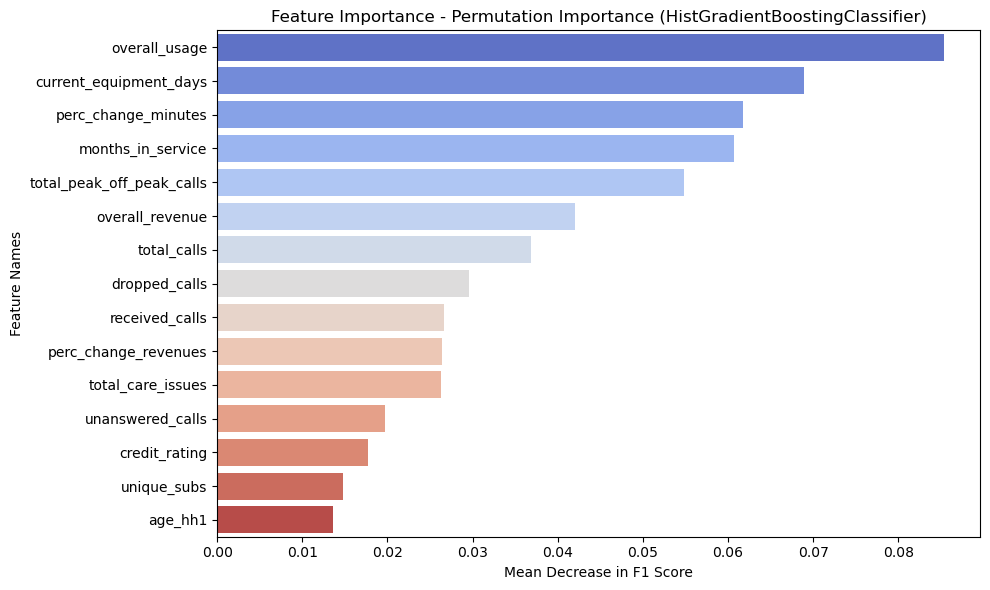

In [ ]:
best_model = best_gb_model_tuned.estimator_

# Permutation Importance (more robust)
result = permutation_importance(
    best_model, 
    X_train_cat, 
    y_train_cat.values.ravel(),
    n_repeats=5,
    random_state=random_state
)

# Create dataframe of permutation importances
importance_df = pd.DataFrame({
    'Feature': X_train_cat.columns,
    'Importance': result.importances_mean,
    'Importance Std': result.importances_std
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Importance", 
    y="Feature", 
    data=importance_df.head(15), 
    palette="coolwarm",
    hue="Feature"
)
plt.title("Feature Importance - Permutation Importance (HistGradientBoostingClassifier)")
plt.xlabel("Mean Decrease in F1 Score")
plt.ylabel("Feature Names")
plt.tight_layout()
plt.show()

The top 3 features based on Permutation Importance for the Gradient Boosted model are:
- overall_usage
- current_equipment_days
- perc_change_minutes

## Model Performance

We summarize the performance across models in the table below. The table shows the f1-score and test accuracy.

**Model Performance:**

| Model               | Test Accuracy | Test F1 Score |
|---------------------|---------------|---------------|
| Baseline Logit      |          0.56 |          0.54 |
| Tuned Logit         |          0.62 |          0.57 |
| Tuned Random Forest |          **0.66** |           **0.60** |
| Adaboost            |          0.65 |          0.58 |
| Gradient Boosting   |          0.65 |          0.57 |

The random forest model outperforms all other models in both test accuracy and test f1-score. Adaboost is a close second. Interestingly, gradient boosting and the tuned logit model performed similarly. It may be the case that we underfit for the gradient boosting model by setting the parameters to stop too early in order to save on computational complexity. If time permitted, we would have explored experiments that allow the gradient boosting model to run longer.

Now we move on to feature importance to see if the models agree on the most important features.

**Feature Importance Summary**

|  | Random Forest             | AdaBoost                  | Gradient Boosting         |
|------|---------------------------|---------------------------|---------------------------|
| 1st  | Current Equipment Days    | Overall Usage             | Overall Usage             |
| 2nd  | Months in Service         | Current Equipment Days    | Current Equipment Days    |
| 3rd  | Percentage Change Minutes | Total Peak Off Peak Calls | Percentage Change Minutes |

The feature that appeared in the top 3 for all the tree based models is current equipment days. It is interesting that this feature is unrelated to the service quality. Current equipment days is most likely a measure that captures the end of a phone contract. This hypothesis is supported by the fact that months in service is a top 3 feature for Random Forest. Overall usage is the top feature in all models except Random Forest. This feature most likely measures how much a customer values a given service.

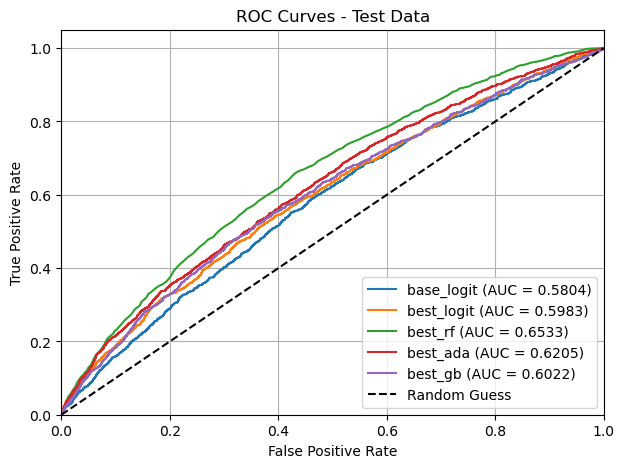

In [247]:
models = {
    'base_logit': logit_model,
    'best_logit': best_logit_model,
    'best_rf': rf_tuned.estimator_,
    'best_ada': best_adaboost_model_tuned.estimator_,
    'best_gb': best_gb_model_tuned.estimator_,
}
X_trains = {
    'base_logit': X_test[top5_features],
    'best_logit': X_test_scaled,
    'best_rf': X_test,
    'best_ada': X_test,
    'best_gb': X_test_cat,
}

y_trains = {
    'base_logit': y_test,
    'best_logit': y_test,
    'best_rf': y_test,
    'best_ada': y_test,
    'best_gb': y_test_cat,
}

aucs = plot_roc_curves_binary(models, X_trains, y_trains, data_label='Test Data')

Finally we arrive at the final model performance metric, ROC (AUC). In terms of AUC, the best model is also the random forest model with AdaBoost coming in second. The AUC tests the model under a variety of thresholds and is a good measure of how well the model can distinguish between classes.

In summary, all performance metrics point to the Random Forest model being the best model. The Random Forest model outperforms all other models in terms of test accuracy, f1-score, and AUC. The feature importance results show that the top 3 features are relatively consistent across models. The optimum thresholds are also consistent across models. This consistency is a good sign that the models are learning the same underlying patterns given in the data.

In [101]:
...

Ellipsis

## Causal Inference

In this section, we conduct a causal inference analysis to identify the average treatment effect (ATE) of a given variable on Churn. We will use both matching and inverse probability weighting to create a pseudo-random population.

The ATE is defined as

$$
ATE = E[Y | T = 1] - E[Y | T = 0].
$$

Since this is an observational study, we do not have the luxury of random assignment, instead we will use propensity scores as your strategy to estimate the ATE. Propensity scores are defined as

$$
e(x) = P(T = 1 | X)
$$

where $T$ is the treatment variable and $X$ is the matrix of covariates. The propensity score represents the probability of receiving the treatment conditional on the covariates. The hope is to find individuals who have similar scores but different treatment assignments. Visually, this means we'll see an overlap in the distribution of propensity scores between the treated and untreated groups. The motivation is because the fundamental problem of causal inference is that we only observe one potential outcome for a given individual, either $Y_i(1)$ or $Y_i(0)$, but not both. By matching we are creating a counterfactual for each individual. 

If matching is successful we can simply compute the ATE by taking the difference in means between the treated and control groups. 

### Identify Treatment Variable

There isn't a clear-cut treatment variable in the dataset. In order to determine the candidates for a possible treatment variable we will iterate through the features to see which one yields the largest discrepancy in churn rates. 

$$
\bigg(\frac{1}{|\{i: X_i = 1\}|} \sum_{i: X = 1} \bold{1}(Churn_i = 1)\bigg) - \bigg(\frac{1}{|\{j: X_j = 1\}|} \sum_{j: X=0} \bold{1}(Churn_j = 1)\bigg)
$$

The feature with the largest churn discrepancy will be selected as the treatment variable.

In [155]:
X_train = pd.read_csv("./data/prod/X_train_ohe.csv")
y_train = pd.read_csv("./data/prod/y_train_ohe.csv")

In [156]:
# Let's find the binary feature that has largest discrepancy in churn rate
def find_sorted_discrepancy_features(X_train, y_train):
    # Find binary features
    binomial_features = X_train.columns[X_train.nunique() == 2]

    discrepancies = []

    for feature in binomial_features:
        # Calculate churn rate discrepancy
        churn_rate_0 = y_train[X_train[feature] == 0].mean().values[0]
        churn_rate_1 = y_train[X_train[feature] == 1].mean().values[0]

        discrepancy = abs(churn_rate_1 - churn_rate_0)
        discrepancies.append((feature, discrepancy))

    sorted_discrepancies = sorted(discrepancies, key=lambda x: x[1], reverse=True)

    return sorted_discrepancies


# Let's see which features have large discrepancies
sorted_features = find_sorted_discrepancy_features(X_train, y_train)
print("Features sorted by churn rate discrepancy:")
for feature, discrepancy in sorted_features[:5]:
    print(f"Feature: {feature}, Discrepancy: {discrepancy:.4f}")

Features sorted by churn rate discrepancy:
Feature: made_call_to_retention_team, Discrepancy: 0.1532
Feature: retention_calls_is_zero, Discrepancy: 0.1532
Feature: retention_offers_accepted_is_zero, Discrepancy: 0.1230
Feature: handset_web_capable, Discrepancy: 0.1044
Feature: unanswered_calls_is_zero, Discrepancy: 0.0662


The results show that the feature with the largest churn descrepancy is `made_call_to_retention_team`. The plot of the churn rate separated by this feature is shown below.

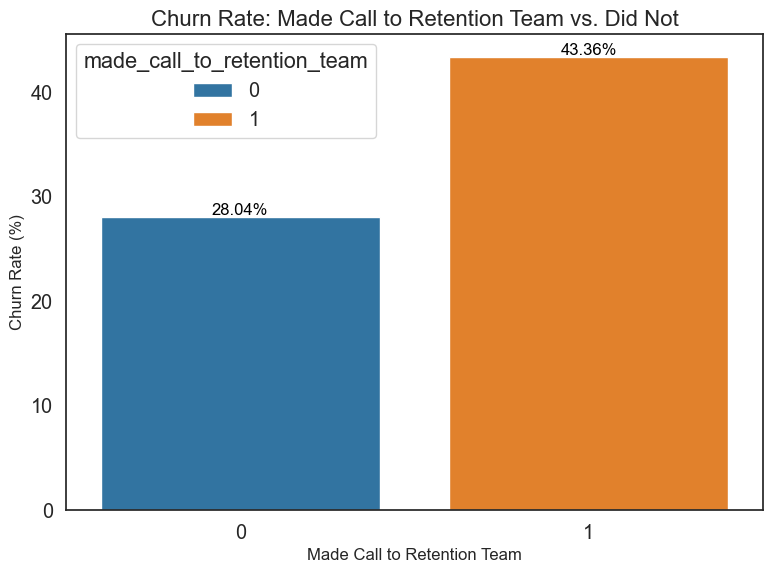

In [157]:
churn_rate_by_call = pd.concat(
    [X_train["made_call_to_retention_team"], y_train], axis=1
)
churn_rate_by_call.columns = ["made_call_to_retention_team", "churn"]

grouped_data = (
    churn_rate_by_call.groupby("made_call_to_retention_team")["churn"]
    .mean()
    .reset_index()
)
grouped_data["churn_rate"] = grouped_data["churn"] * 100

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    x="made_call_to_retention_team",
    y="churn_rate",
    data=grouped_data,
    ax=ax,
    hue="made_call_to_retention_team",
    palette=[
        "#1f77b4",
        "#ff7f0e",
    ],  # Set colors for the bars (blue for no churn, orange for churn)
)

ax.set_title("Churn Rate: Made Call to Retention Team vs. Did Not", fontsize=16)
ax.set_xlabel("Made Call to Retention Team", fontsize=12)
ax.set_ylabel("Churn Rate (%)", fontsize=12)

for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(
            f"{p.get_height():.2f}%",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            fontsize=12,
            color="black",
            xytext=(0, 5),
            textcoords="offset points",
        )

plt.tight_layout()
plt.show()

### Analysis 1: Call to Retention Team <a class="anchor" id="analysis-1"></a>


Our hypothesis for this subsection:


- Does making a call to the retention team (`made_call_to_retention_team`) causally affect the churn rate, or is it merely correlated with it?


Based on the binary feature exploration, we find that the feature `made_call_to_retention_team` has the highest discrepancy in churn rate. Let's explore if this discrepancy implies causality. It’s important to investigate whether the act of calling the retention team leads to an increase in churn, or if other underlying factors (e.g., customer dissatisfaction or prior retention efforts) are influencing both the likelihood of calling and the likelihood of churn.


The findings from this causal analysis will guide our next steps, helping us decide whether to (1) retrain the retention team or (2) reward them for their performance.


As with most causal inference studies, we will assume that SUTVA (Stable Unit Treatment Value Assumption) holds. The SUTVA assumption stipulates no interference of spillovers, namely that one unit does not affect the outcome of another unit. Possible violation of SUTVA in our study could be an overloaded call center, in which case one's call would affect another person's call. SUTVA also claims that there are no hidden levels in the treatment. This means all calls get treated with the same protocol. If the call center reroutes certain customers then it would be in violation.

#### Inverse Probability of Treatment Weighting (IPTW)

For this analysis, instead of matching we'll use IPTW. IPTW is a method that assigns weights to each observation based on the inverse of the propensity score. The weights are then used to estimate the ATE. The formula for the weights is

$$
w_{treatment} = \frac{1}{e(X)},
$$

$$
w_{control} = \frac{1}{1 - e(X)}.
$$

We start with the set of features given by the naive logistic regression model. We then calculate the standardized mean differences to determine additional features to add to our propensity score model. We then calculate the propensity scores and corresponding weights. Finally we calculate the ATE in two ways 1) by reporting the coefficient on the treatment variable and 2) by calculating the mean difference in predicted probabilities between the two groups.

In [158]:
top5_features = [
    "current_equipment_days",
    "perc_change_minutes",
    "overall_usage",
    "total_peak_off_peak_calls",
    "received_calls",
]

In [ ]:
effect_size_df = X_train.reset_index().copy()
effect_size_df['churn'] = y_train
effect_size_df.rename(columns={"index": "user_id"}, inplace=True)

In [160]:
is_zero_cols = effect_size_df.filter(like='_is_zero', axis=1).columns
covariate_cols = X_train.columns
treatment_col = "made_call_to_retention_team"
ignore_cols = [treatment_col, "retention_calls", "retention_offers_accepted"]
ignore_cols.extend(is_zero_cols)

We remove the one-hot-encoding zero inflation dummies and the two variables that are multicollinear with `made_call_to_retention_team`.

##### Standardized Mean Differences

We compute the standard mean differences to check covariate balance between the treated and control groups. The standardized mean difference is defined as 

$$
SMD = \frac{\bar{X}_{treatment} - \bar{X}_{control}}{\sqrt{\frac{s^2_{treatment} + s^2_{control}}{2}}}.
$$

Any variables with an SMD that is greater than 0.1 needs to be accounted for (Austin, 2011). We do this by including the variable in the propensity score model.

In [161]:
additional_covariates = list()
for col in covariate_cols:
    
    if col in ignore_cols:
        continue
    
    treatment_mean = effect_size_df[effect_size_df[treatment_col] == 1][col].mean()
    control_mean = effect_size_df[effect_size_df[treatment_col] == 0][col].mean()
    treatment_std = effect_size_df[effect_size_df[treatment_col] == 1][col].std()
    control_std = effect_size_df[effect_size_df[treatment_col] == 0][col].std()

    smd = (treatment_mean - control_mean) / ((treatment_std + control_std) / 2)

    if smd > 0.1:
        print(f"SMD for {col} before matching: {smd}")
        additional_covariates.append(col)

SMD for dropped_calls before matching: 0.13434752441002304
SMD for months_in_service before matching: 0.4639490364039492
SMD for handsets before matching: 0.6109246844050835
SMD for handset_models before matching: 0.5288298116967166
SMD for handset_refurbished before matching: 0.3958030611222112
SMD for adjustments_to_credit_rating before matching: 0.11497436441543633
SMD for total_care_issues before matching: 0.1265894547496388
SMD for marital_status_Unknown before matching: 0.10916540280798646


In [162]:
additional_covariates

['dropped_calls',
 'months_in_service',
 'handsets',
 'handset_models',
 'handset_refurbished',
 'adjustments_to_credit_rating',
 'total_care_issues',
 'marital_status_Unknown']

The variables above are additional variables that we will include in our propensity model. Next we calculate the decrease in effect size if we decide to match on these variables. This is just to check if the propensity score is doing its job. We are not performing a matching analysis.

##### Check Balance

In [163]:
exclusion_set = list(set(effect_size_df.columns) - set(top5_features) - set(additional_covariates))
exclusion_set.remove("user_id")
exclusion_set.remove("made_call_to_retention_team")

In [164]:
psm_obj = PsmPy(
    effect_size_df,
    treatment="made_call_to_retention_team",
    indx="user_id",
    exclude = exclusion_set
)

In [165]:
psm_obj.logistic_ps(balance=False)

In [166]:
psm_obj.knn_matched(
    matcher='propensity_logit', 
    replacement=False, #False is 1:1 matching
    caliper=None,
    drop_unmatched=True
)

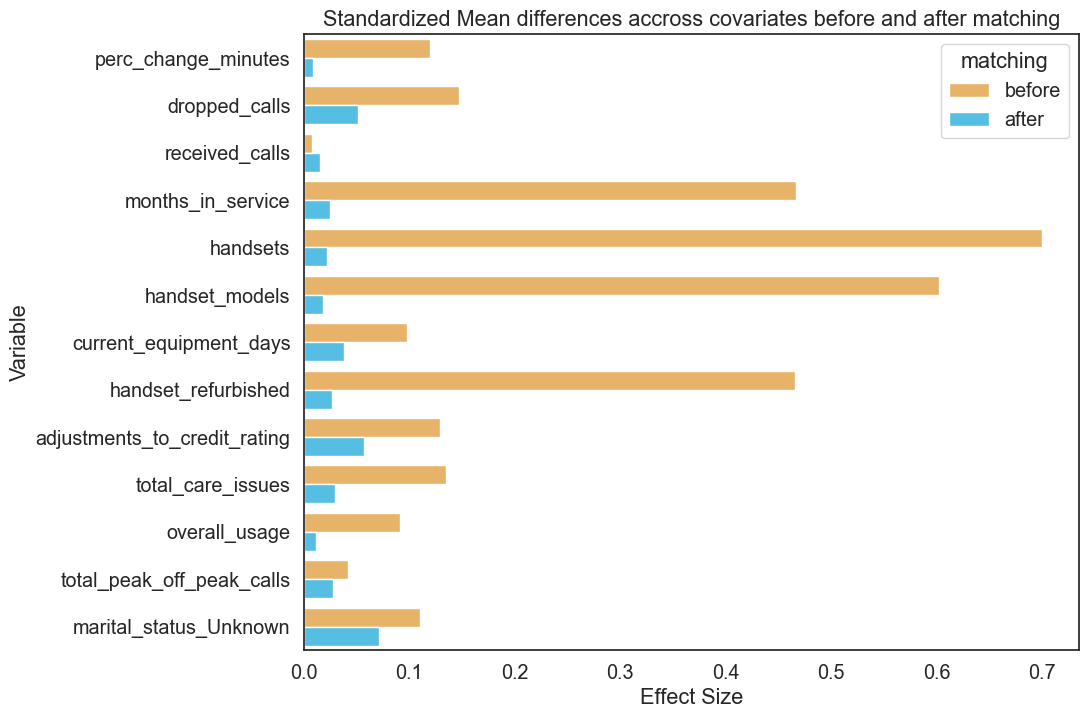

In [167]:
# Effect size should go down after matching
psm_obj.effect_size_plot()

It seems like this logistic regression model specification adequately accounts for covariate imbalance. Post 1:1 matching the effect size of all the covariates are now less than 0.1. We can now be sure that our propensity model specification is adequate. Now we will manually compute the propensity scores and calculate the IPTW weights.

##### Compute Weights


We do not regularize the propensity logit model because counterintuitively we want the logistic regression to be a 'bad' classifier. It doesn't matter that the model predicts poorly, what matters is that the propensity scores it generates leads to a population that is balanced on the covariates.

In [168]:
additional_covariates

['dropped_calls',
 'months_in_service',
 'handsets',
 'handset_models',
 'handset_refurbished',
 'adjustments_to_credit_rating',
 'total_care_issues',
 'marital_status_Unknown']

Train Accuracy: 0.9726


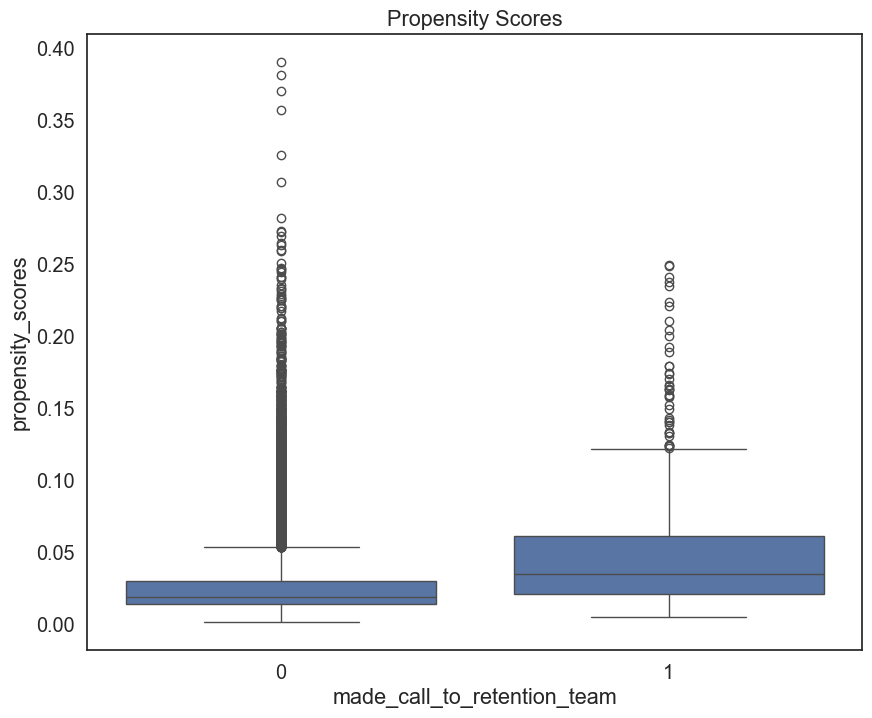

In [169]:
# Target variable: 'made_call_to_retention_team'
y_train_ci_1 = X_train['made_call_to_retention_team']
X_train_ci_1 = X_train.drop(columns=['made_call_to_retention_team'])
X_train_ci_1 = X_train_ci_1[top5_features + additional_covariates]

# Lasso Like Logistic Regression
logit = LogisticRegression(
    solver='liblinear', # converges with liblinear
    random_state=random_state,
    max_iter=1000
)

logit.fit(X_train_ci_1, y_train_ci_1)

y_pred = logit.predict(X_train_ci_1)
accuracy = accuracy_score(y_train_ci_1, y_pred)
print(f"Train Accuracy: {accuracy:.4f}")

# Estimate propensity score
propensity_scores = logit.predict_proba(X_train_ci_1)[:, 1]
X = X_train_ci_1.copy()
X['propensity_scores'] = propensity_scores
X['made_call_to_retention_team'] = y_train_ci_1 

# Visualize the propensity scores
ax = sns.boxplot(y='propensity_scores', x='made_call_to_retention_team', data=X)
ax.set_title("Propensity Scores")
plt.show()

The propensity scores have sufficient overlap for us to work with. We now proceed with the IPTW weight calculation. We will use these weights in a logistic regression model. This is analogous to using weighted least squares for a regression problem. The coefficient on the treatment variable (`made_call_to_retention_team`) will give us the ATE in terms of odds.


In order to estimate the true ATE we assume that the weights create a population where the exchangeability assumption holds. This means conditional on the weights, the units treated and control groups can be substituted for one another. Another way to put this is that there are no confounders that are not accounted for in the propensity score model.


The last assumption is positivity, defined as


$$
0 < e(X) < 1.
$$


A quick check shows this is true. There are no values of the propensity score that are 0 or 1.





In [170]:
# Check positivity assumption
X['propensity_scores'].describe()

count    27151.000000
mean         0.027577
std          0.025108
min          0.001731
25%          0.014330
50%          0.019544
75%          0.030897
max          0.390525
Name: propensity_scores, dtype: float64

In [171]:
# There are barely any overlap between the two group. Let's try adjusting for covariates using weights
# Calculate the weights for each unit based on propensity scores
treated_weight = 1 / propensity_scores
control_weight = 1 / (1 - propensity_scores)

# Combine weights with the data
weights = np.where(y_train_ci_1 == 1, treated_weight, control_weight)

# Rebalance the data by applying the weights
X_weighted = X_train_ci_1.copy()
X_weighted['weights'] = weights

In [ ]:
outcome_df = X_weighted.copy()
outcome_df["treatment"] = y_train_ci_1

In [173]:
formula = "churn" + " ~ " + " + ".join(X_weighted.columns[:-1]) + " + treatment"

In [174]:
fit = smf.glm(
    formula=formula,
    family=sm.families.Binomial(),
    data=pd.concat([y_train, outcome_df], axis=1),
    freq_weights=X_weighted["weights"],
).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                27151
Model:                            GLM   Df Residuals:                 53099.79
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33068.
Date:                Mon, 09 Dec 2024   Deviance:                       66136.
Time:                        17:56:12   Pearson chi2:                 5.34e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1104
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.9909      0.038    -25.869      0.000      -1.066      -0.916
current_equipment_days           0.0010   6.33e-05     15.754      0.000       0.001       0.001
perc_change_minutes             -0.0016   8.03e-05    -19.738      0.000      -0.002      -0.001
overall_usage                 -4.08e-05   5.31e-05     -0.768      0.442      -0.000    6.33e-05
total_peak_off_peak_calls       -0.0015      0.000     -6.366      0.000      -0.002      -0.001
received_calls                  -0.0013      0.000     -5.495      0.000      -0.002      -0.001
dropped_calls                    0.0378      0.003     11.300      0.000       0.031       0.044
months_in_service               -0.0145      0.002     -8.098      0.000      -0.018      -0.011
handsets                         0.1548      0.023      6.693      0.000       0.109       0.200
handset_models                  -0.2049      0.030     -6.818      0.000      -0.264      -0.146
handset_refurbished              0.2846      0.030      9.352      0.000       0.225       0.344
adjustments_to_credit_rating    -0.2149      0.034     -6.410      0.000      -0.281      -0.149
total_care_issues               -0.0086      0.002     -5.429      0.000      -0.012      -0.005
marital_status_Unknown           0.1140      0.020      5.743      0.000       0.075       0.153
treatment                        0.7355      0.019     39.122      0.000       0.699       0.772
================================================================================================
"""

In [175]:
ate = np.exp(fit.params['treatment'])

print ("The ATE in terms of odds is {:.4f}".format(ate))

The ATE in terms of odds is 2.0866


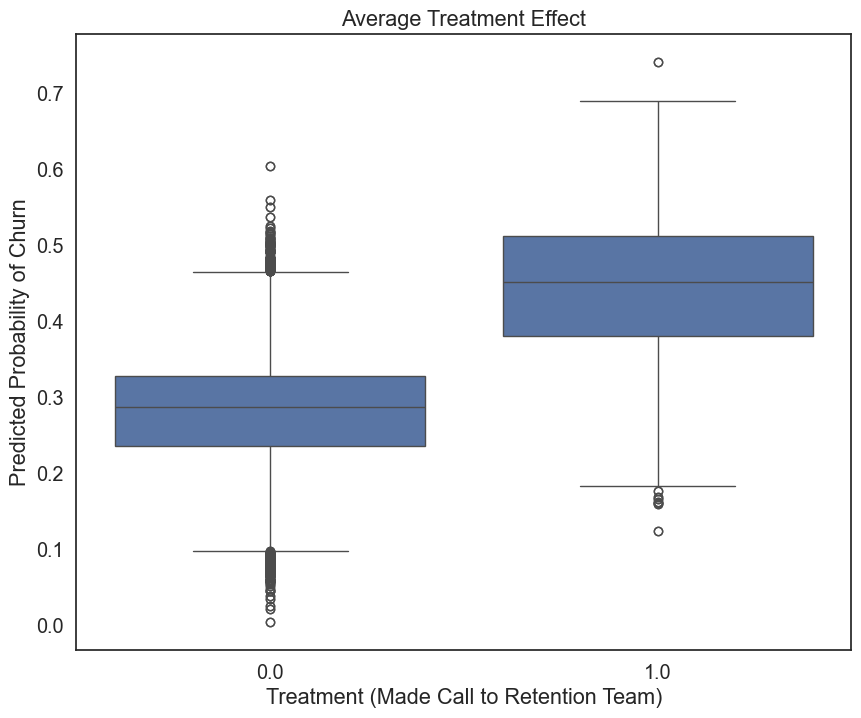

In [176]:
#Visualize predicted probabilities 
predicted_probs = fit.predict()
outcome_df['predicted_probs'] = predicted_probs

ax = sns.boxplot(y='predicted_probs', x='treatment', data=pd.concat([y_train, outcome_df]))
ax.set_title("Average Treatment Effect")
ax.set_xlabel("Treatment (Made Call to Retention Team)")
ax.set_ylabel("Predicted Probability of Churn")
plt.show()

The average treatment effect in terms of odds is 2.09, which implies that the odds of churn are 2.09 times higher for customers who made a call to the retention team compared to those who did not. This is a significant result and suggests that the retention team may need to reevaluate their strategies to reduce churn.

#### Matching


For this section we apply a second iteration of IPTW. We estimated one set of propensity scores in the prior section and computed the IPTW weights. Now we fit another propensity model with the IPTW weights to generate another set of propensity scores.

In [177]:
# although it is not perfect, it is much better. Let's use this 
X_train_df = pd.DataFrame(X_train_ci_1)
X_train_df['id'] = range(0, X.shape[0])
X_train_df['made_call_to_retention_team'] = y_train_ci_1

In [178]:
# Create a PsmPy object for propensity score matching
psm = PsmPy(X_train_df, treatment="made_call_to_retention_team", indx="id", exclude=[])

# Apply logistic propensity score matching
psm.logistic_ps(balance=False)

# Perform k-nearest neighbor matching using propensity scores
psm.knn_matched(
    matcher="propensity_logit",
    replacement=True,
    caliper=None,
    drop_unmatched=True,
)

# To get the means from the matched data:
matched_callers = psm.df_matched[psm.df_matched["made_call_to_retention_team"] == 1][
    "id"
].values
matched_non_callers = psm.df_matched[
    psm.df_matched["made_call_to_retention_team"] == 0
]["id"].values

# Calculate churn rates for both groups
callers_churn = y_train.iloc[matched_callers]
non_callers_churn = y_train.iloc[matched_non_callers]

callers_churn_rate = (callers_churn == 1).mean()
non_callers_churn_rate = (non_callers_churn == 1).mean()

# Print the results
print("Churn Rate (Callers):", callers_churn_rate)
print("Churn Rate (Non-Callers):", non_callers_churn_rate)
print("Adjusted Difference in Churn Rate:", callers_churn_rate - non_callers_churn_rate)

Churn Rate (Callers): churn    0.433557
dtype: float64
Churn Rate (Non-Callers): churn    0.30604
dtype: float64
Adjusted Difference in Churn Rate: churn    0.127517
dtype: float64


In [ ]:
# Match Size
len(matched_callers), len(matched_non_callers)

(745, 745)

In [ ]:
treated_churned = callers_churn.sum()
treated_not_churned = len(callers_churn) - treated_churned

control_churned = non_callers_churn.sum()
control_not_churned = len(non_callers_churn) - control_churned

data = pd.DataFrame({
    'churned': [treated_churned.values[0], control_churned.values[0]],
    'not churned': [treated_not_churned.values[0], control_not_churned.values[0]]
}, index=['treatment', 'control'])
data


churned  not churned
treatment      323          422
control        228          517

In [181]:
chi2, p, dof, expected = chi2_contingency(data)
print("Chi-Squared Statistic:", chi2)
print("p-value:", p)
print("Degrees of Freedom:", dof)

Chi-Squared Statistic: 25.446308290280626
p-value: 4.548672385396034e-07
Degrees of Freedom: 1


Overall, the findings highlight a potential relationship between retention team calls and increased churn, but this cannot be definitively attributed to causation. The results may reflect other underlying, unobservable factors, such as customer dissatisfaction, which are not in the dataset, that drive both the likelihood of calling and churning. However, given the result of this causal inference analysis, we would recommend re-training the customer retention call center team.

The IPTW results show that customers who call the retention team have a 2.06 times higher odds of churning compared to those who do not. The coefficient was also significant at the 0.05 level with a corresponding p-value of 0. This lends evidence that the treatment effect is non-zero and not due to random chance.

The matched analysis shows that customers who call the retention team have a higher churn rate (43.66%) compared to non-callers (25.91%). This suggests a strong association between calling the retention team and churn, even after adjusting for confounders using propensity score matching. Furthermore, the chi-square test shows that the difference between the treatment and control are significant. However, the propensity score distribution had decent overlap between groups (745) but the overlap is still small limiting the comparability and reliability of the casual estimate. While the use of simpler models improved balance, residual bias and unobserved confounders may still influence the results.

### Analysis 2: Responding to Mail Offers <a class="anchor" id="analysis-2"></a>


In our final analysis, we investigate the causal relationship between responding to mail offers and churn. Our hypothesis is the following:


- Does responding to mail offers causally affect churn, or is it just correlated?


For brevity's sake, we will only apply matching and not IPTW.


Based on the model exploration, `responds_to_mail_offers` is one of the only binary variables that was identified as an important feature in predicting churn. Let’s investigate whether responding to mail offers directly reduces churn or if other underlying factors drive both service usage and churn.


The findings from this causal analysis will guide our next steps, helping us decide whether to (1) invest further in mail offers or (2) Maintain the status quo if they have no causal impact on churn rates. As before we will assume that SUTVA holds, that the propensity score model is correctly specified and that the weights create a pseudo-population where the exchangeability assumption holds, specifically


$$
(Y_i(1), Y_i(0)) \perp T_i | X_i.
$$


For our first propensity model we use the entire training set. This ensures that all observable covariates are balanced.



In [385]:
X_train = pd.read_csv("./data/prod/X_train_ohe.csv")
y_train = pd.read_csv("./data/prod/y_train_ohe.csv")

In [386]:
# Target variable: 'responds_to_mail_offers'
y_train_ci_2 = X_train['responds_to_mail_offers']
X_train_ci_2 = X_train.drop(columns=['responds_to_mail_offers'])

# Lasso Like Logistic Regression
logit = LogisticRegression(
    penalty='l1',
    solver='liblinear', # converges with liblinear
    random_state=random_state,
    max_iter=1000,
)

logit.fit(X_train_ci_2, y_train_ci_2)

y_pred = logit.predict(X_train_ci_2)
accuracy = accuracy_score(y_train_ci_2, y_pred)
print(f"Train Accuracy: {accuracy:.4f}")

Train Accuracy: 0.9836


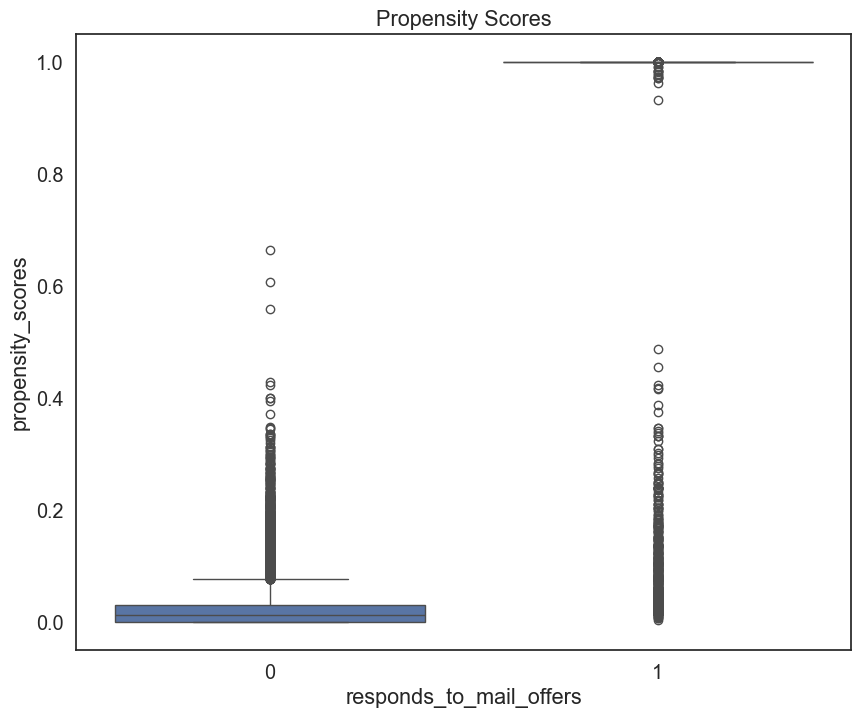

In [387]:
# Estimate propensity score
propensity_scores = logit.predict_proba(X_train_ci_2)[:, 1]
X = X_train_ci_2.copy()
X['propensity_scores'] = propensity_scores
X['responds_to_mail_offers'] = y_train_ci_2 

# Visualize the propensity scores
ax = sns.boxplot(y='propensity_scores', x='responds_to_mail_offers', data=X)
ax.set_title("Propensity Scores")
plt.show()

The distribution of propensity scores look strange but at least there is some overlap in the scores. The one concern is that the scores may have violated the positivity assumption, since a lot of points are clustered near the top. From the quick computation above, that may be the case unfortunately.

In [388]:
# Check positivity assumption
X['propensity_scores'].describe()

count    27151.000000
mean         0.415159
std          0.477462
min          0.000004
25%          0.008398
50%          0.048607
75%          0.999945
max          0.999999
Name: propensity_scores, dtype: float64

Now we compute the IPTW weights and use these weights to fit a logstic regression model. The coefficient on the treatment variable (`responds_to_mail_offers`) will give us the ATE in terms of odds.

In [389]:
# Calculate the weights for each unit based on propensity scores
treated_weight = 1 / propensity_scores
control_weight = 1 / (1 - propensity_scores)

# Combine weights with the data
weights = np.where(y_train_ci_2 == 1, treated_weight, control_weight)

# Rebalance the data by applying the weights
X_weighted = X_train_ci_2.copy()
X_weighted['weights'] = weights

In [390]:
formula = "churn" + " ~ " + " + ".join(X_weighted.columns[:-1]) + " + responds_to_mail_offers"

In [391]:
fit = smf.glm(
    formula=formula,
    family=sm.families.Binomial(),
    data=pd.concat([y_train, X_weighted, y_train_ci_2], axis=1),
    freq_weights=X_weighted["weights"],
).fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                27151
Model:                            GLM   Df Residuals:                 36719.01
Model Family:                Binomial   Df Model:                           66
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20925.
Date:                Mon, 09 Dec 2024   Deviance:                       41849.
Time:                        19:11:47   Pearson chi2:                 3.68e+04
No. Iterations:                   100   Pseudo R-squ. (CS):            0.08075
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               -1.5021      0.397     -3.781      0.000      -2.281      -0.723
perc_change_minutes                     -0.0019      0.000    -15.397      0.000      -0.002      -0.002
perc_change_revenues                     0.0050      0.002      2.943      0.003       0.002       0.008
dropped_calls                            0.0272      0.004      6.207      0.000       0.019       0.036
unanswered_calls                         0.0005      0.001      0.504      0.614      -0.002       0.003
received_calls                        6.446e-06      0.000      0.021      0.983      -0.001       0.001
months_in_service                       -0.0178      0.002     -7.438      0.000      -0.022      -0.013
unique_subs                              0.1502      0.024      6.231      0.000       0.103       0.197
active_subs                             -0.0910      0.032     -2.810      0.005      -0.154      -0.028
handsets                                 0.0360      0.031      1.178      0.239      -0.024       0.096
handset_models                           0.2439      0.040      6.050      0.000       0.165       0.323
current_equipment_days                   0.0018   8.31e-05     21.144      0.000       0.002       0.002
age_hh1                                 -0.0063      0.001     -4.601      0.000      -0.009      -0.004
age_hh2                                 -0.0005      0.001     -0.406      0.684      -0.003       0.002
children_in_hh                           0.0933      0.032      2.905      0.004       0.030       0.156
handset_refurbished                      0.0952      0.039      2.437      0.015       0.019       0.172
handset_web_capable                     -0.2195      0.039     -5.559      0.000      -0.297      -0.142
truck_owner                             -0.0798      0.042     -1.911      0.056      -0.162       0.002
rv_owner                                 0.0733      0.054      1.345      0.178      -0.033       0.180
homeownership                           -0.2284      0.045     -5.118      0.000      -0.316      -0.141
buys_via_mail_order                     -0.1061      0.035     -2.992      0.003      -0.176      -0.037
opt_out_mailings                         0.1270      0.095      1.336      0.182      -0.059       0.313
non_us_travel                           -0.1741      0.057     -3.044      0.002      -0.286      -0.062
owns_computer                          5.39e-05      0.035      0.002      0.999      -0.068       0.068
has_credit_card                          0.2463      0.049      4.981      0.000       0.149       0.343
retention_calls                         -0.4776      0.304     -1.571      0.116      -1.073       0.118
retention_offers_accepted             

In [370]:
ate = np.exp(fit.params['responds_to_mail_offers'])

print ("The ATE in terms of odds is {:.4f}".format(ate))

The ATE in terms of odds is 0.9853


The ATE suggests that the odds of churn are about 0.0147 times lower for customers who respond to mail offers compared to those who do not. The coefficient is significant as well. The model suggests that the mail offers are effective in reducing churn. Now we perform matching to get a matching estimate of the ATE.

In [377]:
X = pd.concat([X_weighted, y_train_ci_2], axis=1)
X = X.drop(columns=['weights'])
X['id'] = range(0, X.shape[0])

In [378]:
# Create a PsmPy object for propensity score matching
psm = PsmPy(X, treatment="responds_to_mail_offers", indx="id", exclude=[])

# # Apply logistic propensity score matching
psm.logistic_ps(balance=False)

# Perform k-nearest neighbor matching using propensity scores
psm.knn_matched(
    # use the propensity scores from the second iteration
    matcher="propensity_logit",
    replacement=True,
    caliper=None,
    drop_unmatched=True,
)

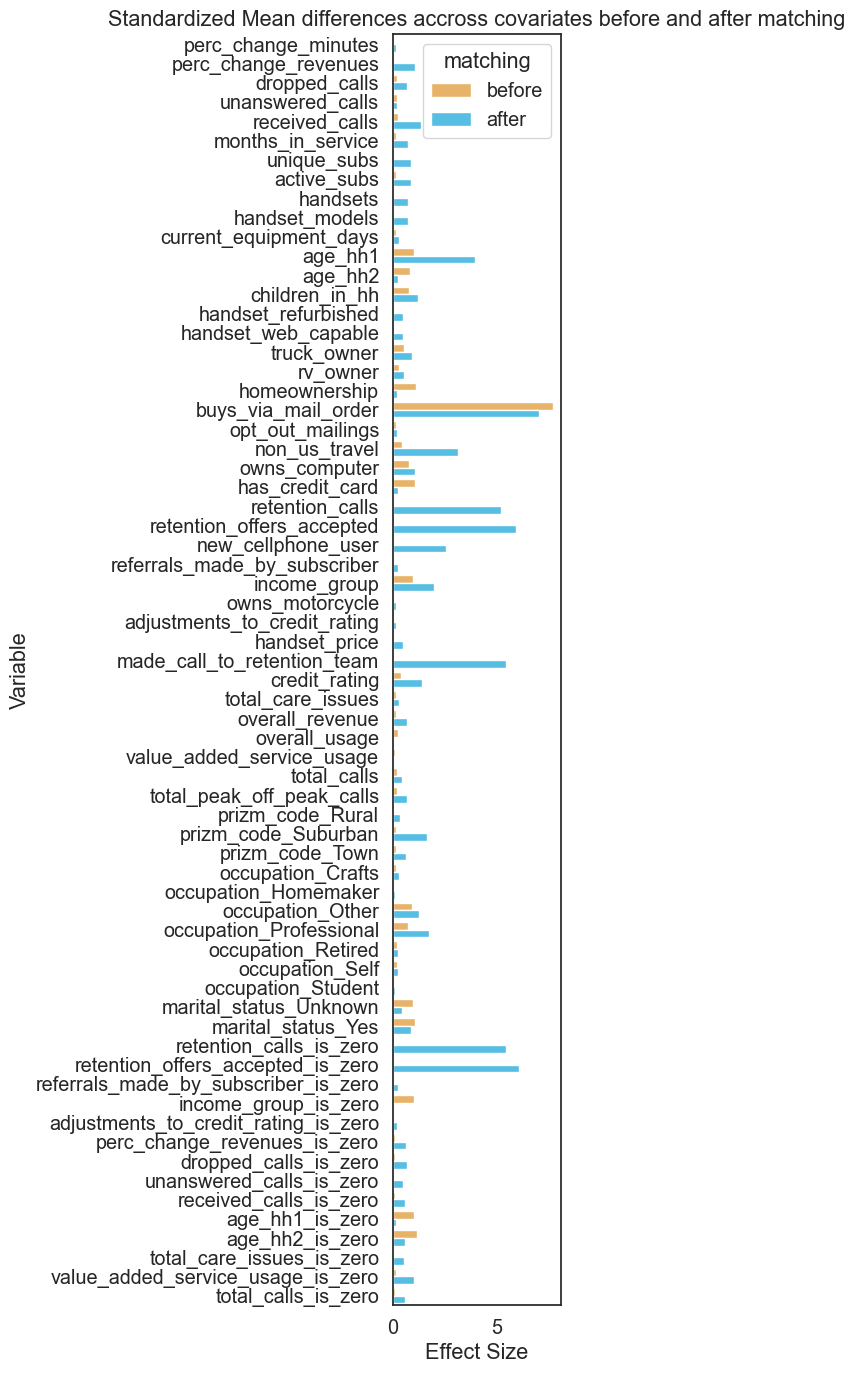

In [380]:
fig, ax = plt.subplots(figsize=(6, 14))

psm.effect_size_plot()
plt.tight_layout()
plt.show()

The matching process didn't work well. Even though we got a larger overlap with the propensity scores, the balance on covariates isn't great. Many of the standardized mean differences increased after matching which is the opposite of what it should do.

In [392]:
# To get the means from the matched data:
matched_responders = psm.df_matched[psm.df_matched["responds_to_mail_offers"] == 1][
    "id"
].values
matched_non_responders = psm.df_matched[psm.df_matched["responds_to_mail_offers"] == 0][
    "id"
].values

# Calculate churn rates for both groups
responders_churn = y_train.iloc[matched_responders]
non_responders_churn = y_train.iloc[matched_non_responders]

responders_churn_rate = (responders_churn == 1).mean()
non_responders_churn_rate = (non_responders_churn == 1).mean()

# Print the results
print("Churn Rate (Responders):", responders_churn_rate)
print("Churn Rate (Non-Responders):", non_responders_churn_rate)
print(
    "Adjusted Difference in Churn Rate:",
    responders_churn_rate - non_responders_churn_rate,
)

Churn Rate (Responders): churn    0.268234
dtype: float64
Churn Rate (Non-Responders): churn    0.97276
dtype: float64
Adjusted Difference in Churn Rate: churn   -0.704525
dtype: float64


In [393]:
# Match Size
len(matched_responders), len(matched_non_responders)

(11270, 11270)

In [394]:
treated_churned = responders_churn.sum()
treated_not_churned = len(responders_churn) - treated_churned

control_churned = non_responders_churn.sum()
control_not_churned = len(non_responders_churn) - control_churned

data = pd.DataFrame({
    'churned': [treated_churned.values[0], control_churned.values[0]],
    'not churned': [treated_not_churned.values[0], control_not_churned.values[0]]
}, index=['treatment', 'control'])
print (data)

chi2, p, dof, expected = chi2_contingency(data)
print("Chi-Squared Statistic:", round(chi2, 4))
print("p-value:", round(p, 4))
print("Degrees of Freedom:", dof)

           churned  not churned
treatment     3023         8247
control      10963          307
Chi-Squared Statistic: 11874.7027
p-value: 0.0
Degrees of Freedom: 1


The analysis indicates that customers who respond to mail offers have a lower churn rate (26.82%) compared to non-responders (97.3%). This suggests a large association between responding to mail offers and reduced churn. The chi-square test shows that the difference is statistically significant, the p-value is smaller than 0.05. Propensity score matching was intended to balance covariates but it didn't make things better as shown by the effect size plot. However, the propensity score distributions did have significant overlaps between the two groups.


The IPTW ATE estimate was in the same direction, suggesting a decrease in churn due to mail offers. The IPTW ATE was much smaller in magnitude than the matching estimate. It is however more believable because the propensity score matching didn't yield balance on covariates.


Overall both results agree but the violations of assumptions make the estimate unreliable.

## Future Work

In this project, we have explored various models to predict customer churn and conducted causal inference analysis to investigate the impact of specific features on churn rates. The results of the models are decent but they still struggle to find a strong relationship between the features and churn. This is a result of the noisy underlying data, making it difficult for a model to identify a clear relationship. The data itself is from a call center which doesn't have the reputation of being the most stringent with data quality controls. Therefore the results may be reflective of the underlying data quality issues.


The best performing model was the Random Forest model. By following the procedure laid out in Breiman's Random Forest paper, we were able to achieve an F1 score of 0.6. However, the model still struggled to find a strong relationship between these features and churn. This suggests that there may be other factors at play that are influencing churn rates.


In addition to the predictive models, we have also conducted causal inference analysis to investigate the impact of specific features on churn rates. Unfortunately, the propensity scores had no overlap which made inference nearly impossible.


For future work, we recommend the following steps to improve the predictive performance and causal inference analysis:


1. **Fix Data Quality Issues**: If possible, address the data quality issues by requesting a new set of data from the call center. This will make the biggest difference, more than any model tuning or feature engineering.
2. **Feature Engineering**: Create new features that may better capture the underlying patterns in the data. Nonlinear and interaction terms were not explored in this project due to computational limitations but there may be a signal in these features.
3. **Advanced Models**: Explore more advanced models ensemble methods like mixture of experts or model stacking. There is the possibility that one can find a combination of models where each focuses on a different part of the feature space.


Thank you for reading our report. We hope you found it informative and insightful. Our emails are listed in the appendix if you have any questions or would like to discuss further.


## Acknowledgements

The authors would like to thank Li Yao for his guidance, support and helpful feedback throughout the project. We would also like to thank the teaching staff for teaching us and providing us with the knowledge to succeed. 

## Sources

Abdulkadir, R. (2022). Customer Churn Prediction on the Cell2Cell Dataset by Deep Learning. Tilburg University - Department of Cognitive Science & Artificial Intelligence. http://arno.uvt.nl/show.cgi?fid=160769

Austin, P. C. (2011). An introduction to propensity score methods for reducing the effects of confounding in observational studies. Multivariate Behavioral Research, 46(3), 399–424. https://doi.org/10.1080/00273171.2011.568786

Bengio, Y., & Grandvalet, Y. (2004). No Unbiased Estimator of the Variance of K-Fold Cross-Validation. Journal of Machine Learning Research, 5. https://www.jmlr.org/papers/volume5/grandvalet04a/grandvalet04a.pdf


Breiman, L. (2001). Random Forests. Machine Learning, 45(1), 5–32. https://doi.org/10.1023/a:1010933404324


Guryanov, A. (2019). Histogram-Based algorithm for building gradient boosting ensembles of piecewise linear decision trees. In Lecture notes in computer science (pp. 39–50). https://doi.org/10.1007/978-3-030-37334-4_4


Kohavi, R. (n.d.). A Study of Cross-Validation and Bootstrap for Accuracy Estimation and Model Selection. Stanford Robotics Journal. https://www.ijcai.org/Proceedings/95-2/Papers/016.pdf


Ling, C. X., Huang, J., & Zhang, H. (2003). AUC: A Better Measure than Accuracy in Comparing Learning Algorithms. In Lecture notes in computer science (pp. 329–341). https://doi.org/10.1007/3-540-44886-1_25

Pugh, C. C. (2013). Real Mathematical analysis. Springer Science & Business Media.

Protopapas, P. (2023, December 5). CS109A Lectures.

## Appendix

### Theorem 1.2. <a class="anchor" id="theorem-1-2"></a>

(Adapted from paper) For a random forest classifier using majority vote as a prediction, as the number of trees increases, for almost surely all sequences $\Theta_1$,...,$\Theta_n$, the $PE^*$ converges to


$$
P_{\bold{X}, y}(P_{\Theta}(h(\bold{X}, \Theta) = y) - max_{j\neq y}P_{\Theta}(h(\bold{X}, \Theta) = j)  < 0)
$$


- Here $X$ is the feature matrix and $y$ is the vector of true labels.
- $\Theta$ denotes the randomness in a Random Forest model. Note that random forest has two sources of randomness, bootstrapping and feature selection.
- $h(\bold{X}, \Theta)$ is the prediction of the Random Forest model.
- $PE^*$ is the OOB error rate.


Here the author defines margin as the difference between the probability that a randomly chosen tree predicts the correct class subtracted by the maximum probability that a randomly chosen tree predicts the wrong class.


$$
P_{\Theta}(h(\bold{X}, \Theta) = y) - max_{j\neq y}P_{\Theta}(h(\bold{X}, \Theta)
$$


As the number of trees increases, the probability of error on the test set converges to the probability that this margin is negative. The implication is that the test error of a Random Forest model plateaus as the number of trees increases, establishing a bound on the test error for Random Forest.


### Definition 1. Mean Decrease in Impurity  <a class="anchor" id="def-mdi"></a>


For a given splits that use feature $q$, and for any given classification criteria, let the decrease in impurity be defined as

$$
\Delta I_q = \frac{n}{N} \bigg[Gini_n - \sum_{m \in Child(n)} \frac{m}{n} Gini_m \bigg].
$$


Here we use Gini but note that it can be substitute. Now for a single tree, the MDI of a given feature $q$ is defined as

$$
MDI_q = \sum_{\text{splits using q}} \Delta I_q.
$$


Normalize by dividing the sum by the total of feature importances in the tree yields


$$
MDI_q' = \frac{MDI_q}{\sum_q^Q MDI_q}
$$


, for all features in $q \in Q$.


Calculating the mean MDI across all $T$ trees in the forest gives the final MDI for a given feature $q$:
$$
MDI'_{q, forest} = \frac{1}{T} \sum_{t=1}^T MDI'_{q,t}
$$





### Definition 2. OOB Error  <a class="anchor" id="def-oob"></a>

For a given point in the training data $\{x_i, y_i\} \in \{\{x_1, y_1\}, \{x_2, y_2\}, ... \{x_N, y_N\} \}$, we select the trees that do not contain $\{x_i, y_i\}$ in their bootstrap sample. Let this set of trees be denoted as $\bold{B} = \{T_1, T_2, ..., T_B\}$. The OOB error is then defined as

$$
Error_{OOB} = \frac{1}{N} \sum_{i=1}^N L(y_i, \hat{y}_i)
$$

where $\hat{y}_i$ is the prediction of all OOB trees on the sample $\{x_i, y_i\}$, 

$$
\hat{y}_i = \frac{1}{|\bold{B}|} \sum_{b=1}^B \hat{y}_{i}^{(b)}.
$$

For regression $L$ is the squared error and for classification $L$ is an indicator function that is 1 if the prediction is incorrect and 0 otherwise.

$$
L_{regression} = (y_i - \hat{y}_i)^2
$$

$$
L_{classification} = \mathbb{1}(y_i \neq \hat{y}_i)
$$

### Definition 3: Principal Component Analysis <a class="anchor" id="def-pca"></a>


Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms the original data into a new set of orthogonal axes called principal components. These components capture the maximum variance in the data. The method for PCA is as follows:

Let the $X$ be the matrix of features, with dimensions $n \times p$, where $n$ is the number of observations and $p$ is the number of features. Each column of $X$ is standardised to have mean 0 and standard deviation of 1:

$$
\widetilde{X} = \frac{X - \bar{x}}{s}
$$

The covariance matrix of the standardised data is then:

$$
S = \frac{1}{n-1} \widetilde{X}^{\top} \widetilde{X}
$$

Perform eigenvalue decomposition on the covariance matrix \(S\):

$$
S = W \Lambda W^\top.
$$

Here the column vectors of the matrix $W$ represents the eigenvectors and $\Lambda$ is matrix with eigenvalues along the diagonal. The number of components is equal to the number of features $p$. The eigenvectors are the principal components and the eigenvalues are proportion of variance explained for each principal component.

Next, the data is projected onto the principal components to form the new feature matrix:

$$
Z = \widetilde{X} W.
$$

The proportion of variance explained by each principal component is given by the eigenvalues. To get the explained variance ratio we divide each eighenvalue by the sum of all eigenvalues. The explained variance ratio for the $q$-th component is 

$$
\text{Explained Variance Ratio}_q = \frac{\lambda_q}{\sum_{j=1}^p \lambda_j}.
$$

To retain a desired proportion of variance (e.g., 90%), we choose the smallest number $m$ that satisfies the condition:

$$
\sum_{i=1}^m \text{Explained Variance Ratio}_i \geq 0.90.
$$

### Lemma 1: Optimal Adaboost Lambda  <a class="anchor" id="lemma-1"></a>

The optimal $\lambda$ for Adaboost is given by $\lambda = \frac{1}{2} \log \bigg( \frac{1 - \epsilon}{\epsilon} \bigg)$, where $\epsilon$ is the error rate of the weak learner. 

<u>Proof:</u>

The proof is straightforward. We have to just take the derivative of the exponential loss function with respect to $\lambda$ and set it equal to zero.

$$
\frac{\partial}{\partial \lambda} \frac{1}{N} \sum_{n=1}^N \exp \bigg( -y_n (T + \lambda^{(i)}S^{(i)}(X_n)) \bigg)
$$

We drop the constant in front since it doesn't change the location of the minimum.

$$
= \sum_{n=1}^N exp(-y_nT) \exp(-y_n\lambda^{(i)}S^{(i)}(X_n))
$$

Split the sum into correct and incorrect cases. Correct cases are when the product of the true label and the weak learner prediction is positive. Incorrect cases are when the product is negative.

$$
= \sum_{correct} e^{-y_nT}e^{-\lambda^{(i)}} + \sum_{incorrect}  e^{-y_nT} e^{\lambda^{(i)}} 
$$

We've done only manipulation so far. Now we apply the definition of weights, differentiate with respect to $\lambda$ and set to 0. For $n > 1$ the weights are $e^{-y_nT}$.

$$
= \sum_{incorrect} w_n e^{\lambda^{(i)}} - \sum_{correct} w_ne^{-\lambda^{(i)}}
$$

We can express the weights in terms of errors. For correct classifications it is $1-\epsilon$ and for incorrect it is $\epsilon$, so then setting the quantity to zero we get

$$
= e^{\lambda^{(i)}}(\epsilon) - e^{-\lambda^{(i)}}(1 - \epsilon) = 0
$$

Solving for $\lambda$ we get

$$
\frac{e^{\lambda^{(i)}}}{e^{\lambda^{(i)}}} = \frac{1 - \epsilon}{\epsilon}
$$

$$
e^{2\lambda^{(i)}} = \frac{1 - \epsilon}{\epsilon} \rightarrow \lambda^{(i)} = \frac{1}{2} \ln \bigg( \frac{1 - \epsilon}{\epsilon} \bigg)
$$

### Lemma 2: Boostrapping Proportion <a class="anchor" id="lemma-2"></a>

For a Random Forest model, the proportion of data not used to train a given tree is $\frac{1}{e}$. 

<u>Informal Proof (sketch):</u>

For a given an inital sample of size $n$, any boostrap sample generated from this sample will also be size $n$. The probability that a given observation is selected at a given draw is then $P(\text{selected}) = \frac{1}{n}$. Taking the logical converse we get the probability of not being selected in a given draw as $P(\text{not selected}) = 1 - \frac{1}{n}$. Since boostrapping is done with replacement, the probability of never being selected for the bootstrap sample is then

$$
P(\text{not selected})^n = \bigg(1 - \frac{1}{n}\bigg)^n.
$$

Taking the limit as $n \to \infty$ we get

$$
\lim_{n \to \infty} \bigg(1 - \frac{1}{n}\bigg)^n = \frac{1}{e} \approx 0.368
$$

### Lemma 3: Variance of Bagged Trees <a class="anchor" id="lemma-3"></a>

Let $X = \sum_{i=1}^B T_i$ where $B$ is the number of i.d. trees and $T_i$ is the individual tree. Using the definition of variance, the variance of $X$ is then

$$
Var(X) = \bold{E}\bigg[(\frac{1}{B} \sum_{i=1}^B X_i - \mu)^2 \bigg]
$$

We factor out the constant and square it using properties of variance to get

$$
= \bigg(\frac{1}{B}\bigg)^2 \bold{E}\bigg[(\sum_{i=1}^B X_i - \mu)^2 \bigg]
$$

Since trees can be correlated we expand the square to get

$$
= \frac{1}{B^2} \bold{E}\bigg[\sum_{i=1}^B (X_i - \mu)(X_j - \mu) \bigg]
$$

The term inside the expectation is just the covariance of $X_i$ and $X_j$. There are now two cases to consider 1) the diagonal elements of the covariance matrix, which means $i=j$ and 2) the off diagonals elements where $i \neq j$. The diagonal elements are just the variance of a single tree, $\sigma^2$. The off diagonal elements are the covariance of two trees, which is $\rho \sigma^2$. There are $B$ diagonal elements and $B(B-1)$ off diagonal elements. Plugging this back into the equation we get

$$
= \frac{1}{B^2} (B^2 - B)\rho\sigma^2 + B\sigma^2 = \rho\sigma^2 + \frac{1-\rho}{B}\sigma^2
$$

Notice that with decision trees the $\rho$ term is high because randomization only occurs at the sampling step and decision trees are prone to using the same strong predictor at the top of the tree. Contrast this with random forests where the $\rho$ term is low because the trees are uncorrelated because randomization happens at sampling and splitting (building the tree). This is how random forests is able to reduce variance. 

### Lemma 4: Averaging Reduces Variance <a class="anchor" id="lemma-4"></a>

The variance of an average is given by $\frac{\sigma^2}{B}$ where $\sigma^2$ is the variance of a single tree and $B$ is the number of trees. The variance of a single prediction on the other hand is given by $\sigma^2$. 

$$
Var(\bar{X}) = \frac{\sigma^2}{B} < \sigma^2 ~~~ \forall B > 1
$$

### Lemma 5: OOB Error is equal to LOOCV Error <a class="anchor" id="lemma-5"></a>

Claim: $B$ sufficiently large, OOB error is virtually equivalent to LOOCV error.

<u>Informal Proof (sketch):</u>

From Lemma 2 we know that the proportion of data not used to train a given tree is $\frac{1}{e}$. The probability that a tree is used as part of the OOB sample is Bin($B, \frac{1}{e}$). The expected value for a binomial distribution is then $E[T_{oob}^{(b)}] = B \cdot \frac{1}{e}$.

As $B \rightarrow \infty$, the set of OOB trees grows to infinity which means that the set of OOB trees more closely approximates an ensemble of trees trained on $n-1$ samples. This is the definition of leave-one-out cross-validation.